# Predictive model for passengers - Team 86

This notebook develops the XGBoost models to estimate the future flow of passengers through land terminals. There is a model for each terminal. In the case of evidence of overfitting, it was regularized by means of the optimal adjustment of the hyperparameters of the model (Random Search).

In [10]:
#Import the libraries, previously you should install the packages, relate in the document requirements.txt

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
import datatable as dt
import xgboost as xgb
import datetime as dt
import pickle


from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# Load the clean dataset
df = pd.read_csv('data_clean.csv', parse_dates = ['FECHA_DESPACHO'])

The model is developed in 3 parts, in the first the terminal is selected and new variables are calculated for the model, in the second the partition is made into training and test and the model is executed and in the third part the main variables are plotted predictors and the model is evaluated with the two metrics used (r2 and rmse)

# T.T. DE APARTADÓ

In [15]:
# 1. Data wrangling

# a. Select the terminal

t_apartado=df[df['TERMINAL'] =='T.T. DE APARTADÓ']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_apartado=t_apartado.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_apartado = data_apartado.rename(columns={'sum':'PASAJEROS'})

#c. Create new features

#Holidays
dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_apartado['FESTIVOS'] = data_apartado['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

#Features date
data_apartado['dayofweek'] = data_apartado['FECHA_DESPACHO'].dt.dayofweek
data_apartado['quarter'] = data_apartado['FECHA_DESPACHO'].dt.quarter
data_apartado['month'] = data_apartado['FECHA_DESPACHO'].dt.month
data_apartado['year'] = data_apartado['FECHA_DESPACHO'].dt.year
data_apartado['dayofyear'] = data_apartado['FECHA_DESPACHO'].dt.dayofyear
data_apartado['dayofmonth'] = data_apartado['FECHA_DESPACHO'].dt.day
data_apartado['weekofyear'] = data_apartado['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions

data_apartado["restriccion"] = np.where(data_apartado['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_apartado['FECHA_DESPACHO'] > '2020-03-26')&(data_apartado['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_apartado['FECHA_DESPACHO'] >='2020-09-01')&(data_apartado['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_apartado['FECHA_DESPACHO'] >='2021-03-01')&(data_apartado['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destination

data_apartado["Depto_Municipio"]=data_apartado['DEPARTAMENTO_DESTINO']+' '+data_apartado['MUNICIPIO_DESTINO']


<ipython-input-15-9ddf3aa0c8a3>:32: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_apartado['weekofyear'] = data_apartado['FECHA_DESPACHO'].dt.weekofyear


In [16]:
# Model
# Split data in features and target values
x_apartado=data_apartado.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_apartado=data_apartado['PASAJEROS']

# Encoding categorical data
x_apartado_encoded=pd.get_dummies(x_apartado, columns=["Depto_Municipio"])

# Data training and data test
x_train_apartado, x_test_apartado, y_train_apartado, y_test_apartado = train_test_split(x_apartado_encoded,y_apartado,test_size=0.2,random_state=42)
print(x_train_apartado.shape)
print(x_test_apartado.shape)

# define model
model_apartado = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_apartado.fit(x_train_apartado, y_train_apartado)

(41820, 22)
(10455, 22)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.9439898593283712
MSE train 207.0343809348026
RMSE train 14.388689340409105
R2 test 0.8779271115250921
MSE test 415.1837363201733
RMSE test 20.37605791904247
Percentil 99 Passengers 263.0


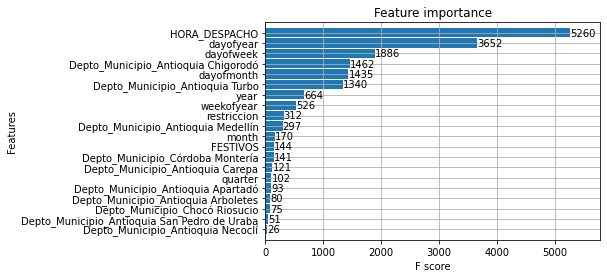

In [17]:
# 3. Evaluate the model

#Feature importance
xgb.plot_importance(model_apartado, ax=plt.gca(),max_num_features=20, height = 0.9)

#Metrics
predtrain_apartado = model_apartado.predict(x_train_apartado)
print('R2 train',r2_score(y_train_apartado,predtrain_apartado))
print('MSE train',mean_squared_error(y_train_apartado,predtrain_apartado))
print('RMSE train',np.sqrt(mean_squared_error(y_train_apartado,predtrain_apartado)))

predtest_apartado=model_apartado.predict(x_test_apartado)
print('R2 test',r2_score(y_test_apartado,predtest_apartado))
print('MSE test',mean_squared_error(y_test_apartado,predtest_apartado))
print('RMSE test',np.sqrt(mean_squared_error(y_test_apartado,predtest_apartado)))

print('Percentil 99 Passengers',np.percentile(data_apartado['PASAJEROS'],99))


In [18]:
# Export model for dash / plotly
file_name = "xgb_model_apartado.pkl"

# save
pickle.dump(model_apartado, open(file_name, "wb"))

# T.T. DE ARMENIA

In [19]:
# 1. Data wrangling

# a. Select the terminal

t_armenia=df[df['TERMINAL'] =='T.T. DE ARMENIA']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_armenia=t_armenia.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_armenia = data_armenia.rename(columns={'sum':'PASAJEROS'})

#Create new features

dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_armenia['FESTIVOS'] = data_armenia['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

data_armenia['dayofweek'] = data_armenia['FECHA_DESPACHO'].dt.dayofweek
data_armenia['quarter'] = data_armenia['FECHA_DESPACHO'].dt.quarter
data_armenia['month'] = data_armenia['FECHA_DESPACHO'].dt.month
data_armenia['year'] = data_armenia['FECHA_DESPACHO'].dt.year
data_armenia['dayofyear'] = data_armenia['FECHA_DESPACHO'].dt.dayofyear
data_armenia['dayofmonth'] = data_armenia['FECHA_DESPACHO'].dt.day
data_armenia['weekofyear'] = data_armenia['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions

data_armenia["restriccion"] = np.where(data_armenia['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_armenia['FECHA_DESPACHO'] > '2020-03-26')&(data_armenia['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_armenia['FECHA_DESPACHO'] >='2020-09-01')&(data_armenia['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_armenia['FECHA_DESPACHO'] >='2021-03-01')&(data_armenia['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destination

data_armenia["Depto_Municipio"]=data_armenia['DEPARTAMENTO_DESTINO']+' '+data_armenia['MUNICIPIO_DESTINO']


<ipython-input-19-79d88d6596a6>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_armenia['weekofyear'] = data_armenia['FECHA_DESPACHO'].dt.weekofyear


In [20]:
# 2. Model

# Split data in features and target values
x_armenia=data_armenia.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_armenia=data_armenia['PASAJEROS']

# Encoding categorical data
x_armenia_encoded=pd.get_dummies(x_armenia, columns=["Depto_Municipio"])

# Data training and data test
x_train_armenia, x_test_armenia, y_train_armenia, y_test_armenia = train_test_split(x_armenia_encoded,y_armenia,test_size=0.2,random_state=42)
print(x_train_armenia.shape)
print(x_test_armenia.shape)

# define model
model_armenia = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_armenia.fit(x_train_armenia, y_train_armenia)


(178976, 46)
(44744, 46)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.9058929880600046
MSE train 181.10003153478942
RMSE train 13.457341176279563
R2 test 0.8766894197562616
MSE test 237.11890265334915
RMSE test 15.398665612751943
Percentil 99 Passengers 214.0


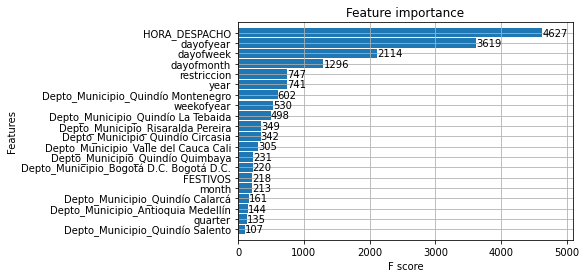

In [21]:
# 3. Evaluate the model

#Feature importance
xgb.plot_importance(model_armenia, ax=plt.gca(),max_num_features=20, height = 0.9)

#Metrics
predtrain_armenia = model_armenia.predict(x_train_armenia)
print('R2 train',r2_score(y_train_armenia,predtrain_armenia))
print('MSE train',mean_squared_error(y_train_armenia,predtrain_armenia))
print('RMSE train',np.sqrt(mean_squared_error(y_train_armenia,predtrain_armenia)))

predtest_armenia=model_armenia.predict(x_test_armenia)
print('R2 test',r2_score(y_test_armenia,predtest_armenia))
print('MSE test',mean_squared_error(y_test_armenia,predtest_armenia))
print('RMSE test',np.sqrt(mean_squared_error(y_test_armenia,predtest_armenia)))

print('Percentil 99 Passengers',np.percentile(data_armenia['PASAJEROS'],99))


In [22]:
# Export model for dash / plotly
file_name = "xgb_model_armenia.pkl"

# save
pickle.dump(model_armenia, open(file_name, "wb"))

# T.T. DE BARRANQUILLA

In [23]:
# 1. Data wrangling

# a. Select the terminal

t_barranquilla=df[df['TERMINAL'] =='T.T. DE BARRANQUILLA']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_barranquilla=t_barranquilla.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_barranquilla = data_barranquilla.rename(columns={'sum':'PASAJEROS'})

#c. Create new features
#Holidays
dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_barranquilla['FESTIVOS'] = data_barranquilla['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

#Feature date
data_barranquilla['dayofweek'] = data_barranquilla['FECHA_DESPACHO'].dt.dayofweek
data_barranquilla['quarter'] = data_barranquilla['FECHA_DESPACHO'].dt.quarter
data_barranquilla['month'] = data_barranquilla['FECHA_DESPACHO'].dt.month
data_barranquilla['year'] = data_barranquilla['FECHA_DESPACHO'].dt.year
data_barranquilla['dayofyear'] = data_barranquilla['FECHA_DESPACHO'].dt.dayofyear
data_barranquilla['dayofmonth'] = data_barranquilla['FECHA_DESPACHO'].dt.day
data_barranquilla['weekofyear'] = data_barranquilla['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions

data_barranquilla["restriccion"] = np.where(data_barranquilla['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_barranquilla['FECHA_DESPACHO'] > '2020-03-26')&(data_barranquilla['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_barranquilla['FECHA_DESPACHO'] >='2020-09-01')&(data_barranquilla['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_barranquilla['FECHA_DESPACHO'] >='2021-03-01')&(data_barranquilla['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destination

data_barranquilla["Depto_Municipio"]=data_barranquilla['DEPARTAMENTO_DESTINO']+' '+data_barranquilla['MUNICIPIO_DESTINO']


<ipython-input-23-68a4909e5d24>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_barranquilla['weekofyear'] = data_barranquilla['FECHA_DESPACHO'].dt.weekofyear


In [24]:
# 2. Model

# Split data in features and target values
x_barranquilla=data_barranquilla.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_barranquilla=data_barranquilla['PASAJEROS']

# Encoding categorical data
x_barranquilla_encoded=pd.get_dummies(x_barranquilla, columns=["Depto_Municipio"])

# Data training and data test
x_train_barranquilla, x_test_barranquilla, y_train_barranquilla, y_test_barranquilla = train_test_split(x_barranquilla_encoded,y_barranquilla,test_size=0.2,random_state=42)
print(x_train_barranquilla.shape)
print(x_test_barranquilla.shape)

# define model
model_barranquilla = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_barranquilla.fit(x_train_barranquilla, y_train_barranquilla)


(92063, 38)
(23016, 38)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.6694668179423882
MSE train 113.39939068945907
RMSE train 10.648915000574428
R2 test 0.531632190059147
MSE test 160.45752381292354
RMSE test 12.667182947006156
Percentil 99 Passengers 86.0


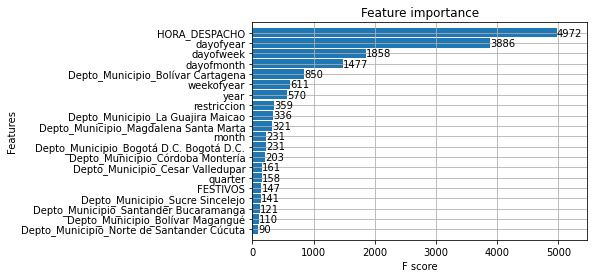

In [25]:
# 3. Evaluate the model

# Feature importance
xgb.plot_importance(model_barranquilla, ax=plt.gca(),max_num_features=20, height = 0.9)

# Metrics
predtrain_barranquilla = model_barranquilla.predict(x_train_barranquilla)
print('R2 train',r2_score(y_train_barranquilla,predtrain_barranquilla))
print('MSE train',mean_squared_error(y_train_barranquilla,predtrain_barranquilla))
print('RMSE train',np.sqrt(mean_squared_error(y_train_barranquilla,predtrain_barranquilla)))

predtest_barranquilla=model_barranquilla.predict(x_test_barranquilla)
print('R2 test',r2_score(y_test_barranquilla,predtest_barranquilla))
print('MSE test',mean_squared_error(y_test_barranquilla,predtest_barranquilla))
print('RMSE test',np.sqrt(mean_squared_error(y_test_barranquilla,predtest_barranquilla)))

print('Percentil 99 Passengers',np.percentile(data_barranquilla['PASAJEROS'],99))


In [26]:
# Export model for dash / plotly
file_name = "xgb_model_barranquilla.pkl"

# save
pickle.dump(model_barranquilla, open(file_name, "wb"))

# T.T. BOGOTA NORTE

In [27]:
# 1. Data wrangling

# a. Select the terminal

t_bogota_norte=df[df['TERMINAL'] =='T.T. DE BOGOTÁ NORTE']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_bogota_norte=t_bogota_norte.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_bogota_norte = data_bogota_norte.rename(columns={'sum':'PASAJEROS'})

# c. Create new features
# Holidays
dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_bogota_norte['FESTIVOS'] = data_bogota_norte['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

# Features date
data_bogota_norte['dayofweek'] = data_bogota_norte['FECHA_DESPACHO'].dt.dayofweek
data_bogota_norte['quarter'] = data_bogota_norte['FECHA_DESPACHO'].dt.quarter
data_bogota_norte['month'] = data_bogota_norte['FECHA_DESPACHO'].dt.month
data_bogota_norte['year'] = data_bogota_norte['FECHA_DESPACHO'].dt.year
data_bogota_norte['dayofyear'] = data_bogota_norte['FECHA_DESPACHO'].dt.dayofyear
data_bogota_norte['dayofmonth'] = data_bogota_norte['FECHA_DESPACHO'].dt.day
data_bogota_norte['weekofyear'] = data_bogota_norte['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions

data_bogota_norte["restriccion"] = np.where(data_bogota_norte['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_bogota_norte['FECHA_DESPACHO'] > '2020-03-26')&(data_bogota_norte['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_bogota_norte['FECHA_DESPACHO'] >='2020-09-01')&(data_bogota_norte['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_bogota_norte['FECHA_DESPACHO'] >='2021-03-01')&(data_bogota_norte['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destination

data_bogota_norte["Depto_Municipio"]=data_bogota_norte['DEPARTAMENTO_DESTINO']+' '+data_bogota_norte['MUNICIPIO_DESTINO']


<ipython-input-27-17cc5dc0713b>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_bogota_norte['weekofyear'] = data_bogota_norte['FECHA_DESPACHO'].dt.weekofyear


In [28]:
# 2. Model

# Split data in features and target values
x_bogota_norte=data_bogota_norte.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_bogota_norte=data_bogota_norte['PASAJEROS']

# Encoding categorical data
x_bogota_norte_encoded=pd.get_dummies(x_bogota_norte, columns=["Depto_Municipio"])

# Data training and data test
x_train_bogota_norte, x_test_bogota_norte, y_train_bogota_norte, y_test_bogota_norte = train_test_split(x_bogota_norte_encoded,y_bogota_norte,test_size=0.2,random_state=42)
print(x_train_bogota_norte.shape)
print(x_test_bogota_norte.shape)

# define model
model_bogota_norte = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_bogota_norte.fit(x_train_bogota_norte, y_train_bogota_norte)


(191792, 141)
(47949, 141)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.8530608180368726
MSE train 39.7688499834199
RMSE train 6.306254830199926
R2 test 0.8061327141221126
MSE test 53.00854499950651
RMSE test 7.280696738603147
Percentil 99 Passengers 78.0


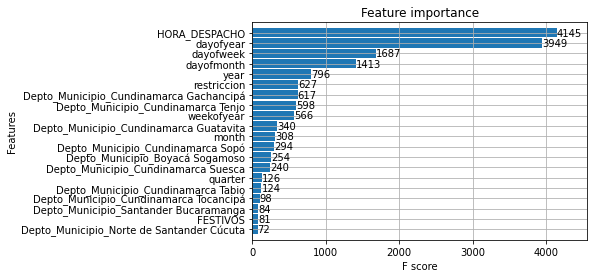

In [29]:
# 3. Evaluate the model

# Feature imporatnce
xgb.plot_importance(model_bogota_norte, ax=plt.gca(),max_num_features=20, height = 0.9)

# Metrics
predtrain_bogota_norte = model_bogota_norte.predict(x_train_bogota_norte)
print('R2 train',r2_score(y_train_bogota_norte,predtrain_bogota_norte))
print('MSE train',mean_squared_error(y_train_bogota_norte,predtrain_bogota_norte))
print('RMSE train',np.sqrt(mean_squared_error(y_train_bogota_norte,predtrain_bogota_norte)))

predtest_bogota_norte=model_bogota_norte.predict(x_test_bogota_norte)
print('R2 test',r2_score(y_test_bogota_norte,predtest_bogota_norte))
print('MSE test',mean_squared_error(y_test_bogota_norte,predtest_bogota_norte))
print('RMSE test',np.sqrt(mean_squared_error(y_test_bogota_norte,predtest_bogota_norte)))

print('Percentil 99 Passengers',np.percentile(data_bogota_norte['PASAJEROS'],99))


In [30]:
# Export model for dash / plotly
file_name = "xgb_model_bogota_norte.pkl"

# save
pickle.dump(model_bogota_norte, open(file_name, "wb"))

# TT BOGOTA SALITRE

In [3]:
# 1. Data wrangling

# a. Select the terminal

t_bogota_salitre=df[df['TERMINAL'] =='T.T. DE BOGOTÁ SALITRE']

# b. Select the main features for the model
# Features such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_bogota_salitre=t_bogota_salitre.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                               'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_bogota_salitre = data_bogota_salitre.rename(columns={'sum':'PASAJEROS'})

# c. Create new features

# holidays
dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_bogota_salitre['FESTIVOS'] = data_bogota_salitre['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

# features date
data_bogota_salitre['dayofweek'] = data_bogota_salitre['FECHA_DESPACHO'].dt.dayofweek
data_bogota_salitre['quarter'] = data_bogota_salitre['FECHA_DESPACHO'].dt.quarter
data_bogota_salitre['month'] = data_bogota_salitre['FECHA_DESPACHO'].dt.month
data_bogota_salitre['year'] = data_bogota_salitre['FECHA_DESPACHO'].dt.year
data_bogota_salitre['dayofyear'] = data_bogota_salitre['FECHA_DESPACHO'].dt.dayofyear
data_bogota_salitre['dayofmonth'] = data_bogota_salitre['FECHA_DESPACHO'].dt.day
data_bogota_salitre['weekofyear'] = data_bogota_salitre['FECHA_DESPACHO'].dt.weekofyear

# mobility restrictions

data_bogota_salitre["restriccion"] = np.where(data_bogota_salitre['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_bogota_salitre['FECHA_DESPACHO'] > '2020-03-26')&(data_bogota_salitre['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_bogota_salitre['FECHA_DESPACHO'] >='2020-09-01')&(data_bogota_salitre['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_bogota_salitre['FECHA_DESPACHO'] >='2021-03-01')&(data_bogota_salitre['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# travel destination

data_bogota_salitre["Depto_Municipio"]=data_bogota_salitre['DEPARTAMENTO_DESTINO']+' '+data_bogota_salitre['MUNICIPIO_DESTINO']

<ipython-input-3-3fcfcb69411e>:32: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_bogota_salitre['weekofyear'] = data_bogota_salitre['FECHA_DESPACHO'].dt.weekofyear


In [4]:
# 2. Model

# Split data in features and target values
x_bogota_salitre=data_bogota_salitre.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_bogota_salitre=data_bogota_salitre['PASAJEROS']

# Encoding categorical data
x_bogota_salitre_encoded=pd.get_dummies(x_bogota_salitre, columns=["Depto_Municipio"])

# Data training and data test
x_train_bogota_salitre, x_test_bogota_salitre, y_train_bogota_salitre, y_test_bogota_salitre = train_test_split(x_bogota_salitre_encoded,y_bogota_salitre,test_size=0.2,random_state=42)
print(x_train_bogota_salitre.shape)
print(x_test_bogota_salitre.shape)

# define model
model_bogota_salitre = XGBRegressor(objective ='reg:squarederror', n_estimators = 200, seed = 123)

# fit model
model_bogota_salitre.fit(x_train_bogota_salitre, y_train_bogota_salitre)

(517721, 266)
(129431, 266)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.7759960904147762
MSE train 119.15553487943524
RMSE train 10.915838716261579
R2 test 0.7667029915462896
MSE test 125.39430406827354
RMSE test 11.19795981722892
Percentil 99 Passengers 111.0


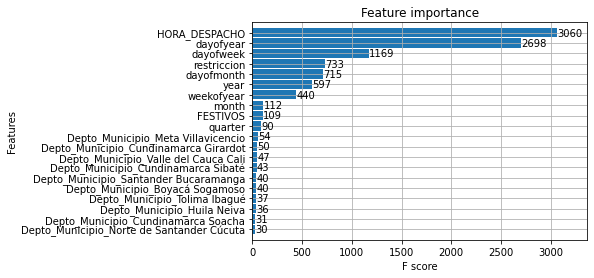

In [5]:
# 3. Evaluate the model

# Feature importances
%matplotlib inline
xgb.plot_importance(model_bogota_salitre, ax=plt.gca(),max_num_features=20, height = 0.9)

# evaluation metrics
predtrain_bogota_salitre = model_bogota_salitre.predict(x_train_bogota_salitre)
print('R2 train',r2_score(y_train_bogota_salitre,predtrain_bogota_salitre))
print('MSE train',mean_squared_error(y_train_bogota_salitre,predtrain_bogota_salitre))
print('RMSE train',np.sqrt(mean_squared_error(y_train_bogota_salitre,predtrain_bogota_salitre)))

predtest_bogota_salitre=model_bogota_salitre.predict(x_test_bogota_salitre)
print('R2 test',r2_score(y_test_bogota_salitre,predtest_bogota_salitre))
print('MSE test',mean_squared_error(y_test_bogota_salitre,predtest_bogota_salitre))
print('RMSE test',np.sqrt(mean_squared_error(y_test_bogota_salitre,predtest_bogota_salitre)))

print('Percentil 99 Passengers',np.percentile(data_bogota_salitre['PASAJEROS'],99))

In [6]:
# Export model for dash / plotly
import pickle
file_name = "xgb_model_bogota_salitre.pkl"

# save
pickle.dump(model_bogota_salitre, open(file_name, "wb"))

# T.T. BOGOTA SUR

In [31]:
# 1. Data wrangling

# a. Select the terminal

t_bogota_sur=df[df['TERMINAL'] =='T.T. DE BOGOTÁ SUR']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_bogota_sur=t_bogota_sur.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_bogota_sur = data_bogota_sur.rename(columns={'sum':'PASAJEROS'})

#Create new features

dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_bogota_sur['FESTIVOS'] = data_bogota_sur['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

data_bogota_sur['dayofweek'] = data_bogota_sur['FECHA_DESPACHO'].dt.dayofweek
data_bogota_sur['quarter'] = data_bogota_sur['FECHA_DESPACHO'].dt.quarter
data_bogota_sur['month'] = data_bogota_sur['FECHA_DESPACHO'].dt.month
data_bogota_sur['year'] = data_bogota_sur['FECHA_DESPACHO'].dt.year
data_bogota_sur['dayofyear'] = data_bogota_sur['FECHA_DESPACHO'].dt.dayofyear
data_bogota_sur['dayofmonth'] = data_bogota_sur['FECHA_DESPACHO'].dt.day
data_bogota_sur['weekofyear'] = data_bogota_sur['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions

data_bogota_sur["restriccion"] = np.where(data_bogota_sur['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_bogota_sur['FECHA_DESPACHO'] > '2020-03-26')&(data_bogota_sur['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_bogota_sur['FECHA_DESPACHO'] >='2020-09-01')&(data_bogota_sur['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_bogota_sur['FECHA_DESPACHO'] >='2021-03-01')&(data_bogota_sur['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Se unicia departamento y municipio de destino en una sola variable

data_bogota_sur["Depto_Municipio"]=data_bogota_sur['DEPARTAMENTO_DESTINO']+' '+data_bogota_sur['MUNICIPIO_DESTINO']


<ipython-input-31-80b658aa9862>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_bogota_sur['weekofyear'] = data_bogota_sur['FECHA_DESPACHO'].dt.weekofyear


In [32]:
# 2. Model

# Split data in features and target values
x_bogota_sur=data_bogota_sur.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_bogota_sur=data_bogota_sur['PASAJEROS']

# Encoding categorical data
x_bogota_sur_encoded=pd.get_dummies(x_bogota_sur, columns=["Depto_Municipio"])

# Data training and data test
x_train_bogota_sur, x_test_bogota_sur, y_train_bogota_sur, y_test_bogota_sur = train_test_split(x_bogota_sur_encoded,y_bogota_sur,test_size=0.2,random_state=42)
print(x_train_bogota_sur.shape)
print(x_test_bogota_sur.shape)

# define model
model_bogota_sur = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_bogota_sur.fit(x_train_bogota_sur, y_train_bogota_sur)


(132557, 84)
(33140, 84)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.8369463972014526
MSE train 122.64757502240377
RMSE train 11.074636563896973
R2 test 0.7713043431653429
MSE test 164.96295687774733
RMSE test 12.84379059614985
Percentil 99 Passengers 136.0


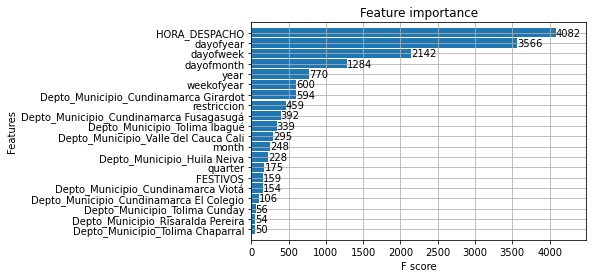

In [33]:
# 3. Evaluate the model

# Feature importance
xgb.plot_importance(model_bogota_sur, ax=plt.gca(),max_num_features=20, height = 0.9)

# Metrics
predtrain_bogota_sur = model_bogota_sur.predict(x_train_bogota_sur)
print('R2 train',r2_score(y_train_bogota_sur,predtrain_bogota_sur))
print('MSE train',mean_squared_error(y_train_bogota_sur,predtrain_bogota_sur))
print('RMSE train',np.sqrt(mean_squared_error(y_train_bogota_sur,predtrain_bogota_sur)))

predtest_bogota_sur=model_bogota_sur.predict(x_test_bogota_sur)
print('R2 test',r2_score(y_test_bogota_sur,predtest_bogota_sur))
print('MSE test',mean_squared_error(y_test_bogota_sur,predtest_bogota_sur))
print('RMSE test',np.sqrt(mean_squared_error(y_test_bogota_sur,predtest_bogota_sur)))

print('Percentil 99 Passengers',np.percentile(data_bogota_sur['PASAJEROS'],99))

In [34]:
# Export model for dash / plotly
file_name = "xgb_model_bogota_sur.pkl"

# save
pickle.dump(model_bogota_sur, open(file_name, "wb"))

# T.T. DE BUCARAMANGA

In [7]:
# 1. Data wrangling

# a. Select the terminal

t_bucaramanga=df[df['TERMINAL'] =='T.T. DE BUCARAMANGA']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_bucaramanga=t_bucaramanga.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_bucaramanga = data_bucaramanga.rename(columns={'sum':'PASAJEROS'})

# c. Create new features

# holidays

dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_bucaramanga['FESTIVOS'] = data_bucaramanga['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

#Features date
data_bucaramanga['dayofweek'] = data_bucaramanga['FECHA_DESPACHO'].dt.dayofweek
data_bucaramanga['quarter'] = data_bucaramanga['FECHA_DESPACHO'].dt.quarter
data_bucaramanga['month'] = data_bucaramanga['FECHA_DESPACHO'].dt.month
data_bucaramanga['year'] = data_bucaramanga['FECHA_DESPACHO'].dt.year
data_bucaramanga['dayofyear'] = data_bucaramanga['FECHA_DESPACHO'].dt.dayofyear
data_bucaramanga['dayofmonth'] = data_bucaramanga['FECHA_DESPACHO'].dt.day
data_bucaramanga['weekofyear'] = data_bucaramanga['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions

data_bucaramanga["restriccion"] = np.where(data_bucaramanga['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_bucaramanga['FECHA_DESPACHO'] > '2020-03-26')&(data_bucaramanga['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_bucaramanga['FECHA_DESPACHO'] >='2020-09-01')&(data_bucaramanga['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_bucaramanga['FECHA_DESPACHO'] >='2021-03-01')&(data_bucaramanga['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destination

data_bucaramanga["Depto_Municipio"]=data_bucaramanga['DEPARTAMENTO_DESTINO']+' '+data_bucaramanga['MUNICIPIO_DESTINO']


<ipython-input-7-30e979e63872>:33: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_bucaramanga['weekofyear'] = data_bucaramanga['FECHA_DESPACHO'].dt.weekofyear


In [8]:
# 2. Model

# Split data in features and target values
x_bucaramanga=data_bucaramanga.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_bucaramanga=data_bucaramanga['PASAJEROS']

# Encoding categorical data
x_bucaramanga_encoded=pd.get_dummies(x_bucaramanga, columns=["Depto_Municipio"])

# Data training and data test
x_train_bucaramanga, x_test_bucaramanga, y_train_bucaramanga, y_test_bucaramanga = train_test_split(x_bucaramanga_encoded,y_bucaramanga,test_size=0.2,random_state=42)
print(x_train_bucaramanga.shape)
print(x_test_bucaramanga.shape)

# define model
model_bucaramanga = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_bucaramanga.fit(x_train_bucaramanga, y_train_bucaramanga)

(136800, 67)
(34201, 67)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.8572062975744512
MSE train 58.7033760757781
RMSE train 7.661812845259149
Mean train 9.0
R2 test 0.8006327119091615
MSE test 79.3480198704061
RMSE test 8.907750550526552
Mean test 9.0
Percentil 99 Passengers 106.0


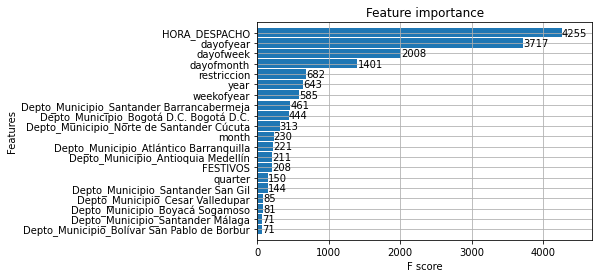

In [9]:
# 3. Evaluate the model

# Feature importances
xgb.plot_importance(model_bucaramanga, ax=plt.gca(),max_num_features=20, height = 0.9)

# metrics

predtrain_bucaramanga = model_bucaramanga.predict(x_train_bucaramanga)
print('R2 train',r2_score(y_train_bucaramanga,predtrain_bucaramanga))
print('MSE train',mean_squared_error(y_train_bucaramanga,predtrain_bucaramanga))
print('RMSE train',np.sqrt(mean_squared_error(y_train_bucaramanga,predtrain_bucaramanga)))
print('Mean train',np.median(y_train_bucaramanga))

predtest_bucaramanga=model_bucaramanga.predict(x_test_bucaramanga)
print('R2 test',r2_score(y_test_bucaramanga,predtest_bucaramanga))
print('MSE test',mean_squared_error(y_test_bucaramanga,predtest_bucaramanga))
print('RMSE test',np.sqrt(mean_squared_error(y_test_bucaramanga,predtest_bucaramanga)))
print('Mean test',np.median(y_test_bucaramanga))

print('Percentil 99 Passengers',np.percentile(data_bucaramanga['PASAJEROS'],99))

In [10]:
# Export model for dash / plotly

file_name = "xgb_model_bucaramanga.pkl"

# save
pickle.dump(model_bucaramanga, open(file_name, "wb"))

## T.T. DE BUGA

In [35]:
# 1. Data wrangling

# a. Select the terminal

t_buga=df[df['TERMINAL'] =='T.T. DE BUGA']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_buga=t_buga.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_buga = data_buga.rename(columns={'sum':'PASAJEROS'})

#Create new features

dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_buga['FESTIVOS'] = data_buga['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

data_buga['dayofweek'] = data_buga['FECHA_DESPACHO'].dt.dayofweek
data_buga['quarter'] = data_buga['FECHA_DESPACHO'].dt.quarter
data_buga['month'] = data_buga['FECHA_DESPACHO'].dt.month
data_buga['year'] = data_buga['FECHA_DESPACHO'].dt.year
data_buga['dayofyear'] = data_buga['FECHA_DESPACHO'].dt.dayofyear
data_buga['dayofmonth'] = data_buga['FECHA_DESPACHO'].dt.day
data_buga['weekofyear'] = data_buga['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions

data_buga["restriccion"] = np.where(data_buga['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_buga['FECHA_DESPACHO'] > '2020-03-26')&(data_buga['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_buga['FECHA_DESPACHO'] >='2020-09-01')&(data_buga['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_buga['FECHA_DESPACHO'] >='2021-03-01')&(data_buga['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destination

data_buga["Depto_Municipio"]=data_buga['DEPARTAMENTO_DESTINO']+' '+data_buga['MUNICIPIO_DESTINO']


<ipython-input-35-2f2f6029b134>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_buga['weekofyear'] = data_buga['FECHA_DESPACHO'].dt.weekofyear


In [36]:
# 2. Model

# Split data in features and target values
x_buga=data_buga.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_buga=data_buga['PASAJEROS']

# Encoding categorical data
x_buga_encoded=pd.get_dummies(x_buga, columns=["Depto_Municipio"])

# Data training and data test
x_train_buga, x_test_buga, y_train_buga, y_test_buga = train_test_split(x_buga_encoded,y_buga,test_size=0.2,random_state=42)
print(x_train_buga.shape)
print(x_test_buga.shape)

# define model
model_buga = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_buga.fit(x_train_buga, y_train_buga)


(88666, 37)
(22167, 37)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.9408368155485539
MSE train 75.93353337813706
RMSE train 8.71398493102536
R2 test 0.9133975725443017
MSE test 107.41894624130823
RMSE test 10.36431118026221
Percentil 99 Passengers 183.0


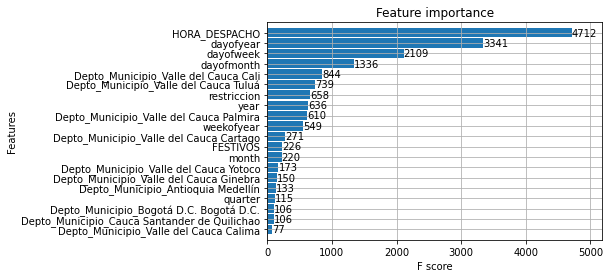

In [37]:
# 3. Evaluate the model

# Feature importance
xgb.plot_importance(model_buga, ax=plt.gca(),max_num_features=20, height = 0.9)

# Metrics
predtrain_buga = model_buga.predict(x_train_buga)
print('R2 train',r2_score(y_train_buga,predtrain_buga))
print('MSE train',mean_squared_error(y_train_buga,predtrain_buga))
print('RMSE train',np.sqrt(mean_squared_error(y_train_buga,predtrain_buga)))

predtest_buga=model_buga.predict(x_test_buga)
print('R2 test',r2_score(y_test_buga,predtest_buga))
print('MSE test',mean_squared_error(y_test_buga,predtest_buga))
print('RMSE test',np.sqrt(mean_squared_error(y_test_buga,predtest_buga)))

print('Percentil 99 Passengers',np.percentile(data_buga['PASAJEROS'],99))


In [38]:
# Export model for dash / plotly
file_name = "xgb_model_buga.pkl"

# save
pickle.dump(model_buga, open(file_name, "wb"))

## T.T. DE CALI

In [39]:
# 1. Data wrangling

# a. Select the terminal

t_cali=df[df['TERMINAL'] =='T.T. DE CALI']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_cali=t_cali.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_cali = data_cali.rename(columns={'sum':'PASAJEROS'})

#Create new features

dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_cali['FESTIVOS'] = data_cali['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

data_cali['dayofweek'] = data_cali['FECHA_DESPACHO'].dt.dayofweek
data_cali['quarter'] = data_cali['FECHA_DESPACHO'].dt.quarter
data_cali['month'] = data_cali['FECHA_DESPACHO'].dt.month
data_cali['year'] = data_cali['FECHA_DESPACHO'].dt.year
data_cali['dayofyear'] = data_cali['FECHA_DESPACHO'].dt.dayofyear
data_cali['dayofmonth'] = data_cali['FECHA_DESPACHO'].dt.day
data_cali['weekofyear'] = data_cali['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions

data_cali["restriccion"] = np.where(data_cali['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_cali['FECHA_DESPACHO'] > '2020-03-26')&(data_cali['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_cali['FECHA_DESPACHO'] >='2020-09-01')&(data_cali['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_cali['FECHA_DESPACHO'] >='2021-03-01')&(data_cali['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destination

data_cali["Depto_Municipio"]=data_cali['DEPARTAMENTO_DESTINO']+' '+data_cali['MUNICIPIO_DESTINO']



<ipython-input-39-c191178483e4>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_cali['weekofyear'] = data_cali['FECHA_DESPACHO'].dt.weekofyear


In [40]:
# 2. Model

# Split data in features and target values
x_cali=data_cali.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_cali=data_cali['PASAJEROS']

# Encoding categorical data
x_cali_encoded=pd.get_dummies(x_cali, columns=["Depto_Municipio"])

# Data training and data test
x_train_cali, x_test_cali, y_train_cali, y_test_cali = train_test_split(x_cali_encoded,y_cali,test_size=0.2,random_state=42)
print(x_train_cali.shape)
print(x_test_cali.shape)

# define model
model_cali = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_cali.fit(x_train_cali, y_train_cali)


(277713, 91)
(69429, 91)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.8611975857642276
MSE train 343.3657099641637
RMSE train 18.53012978810898
R2 test 0.83169385368022
MSE test 412.1187982427738
RMSE test 20.300709303932553
Percentil 99 Passengers 247.0


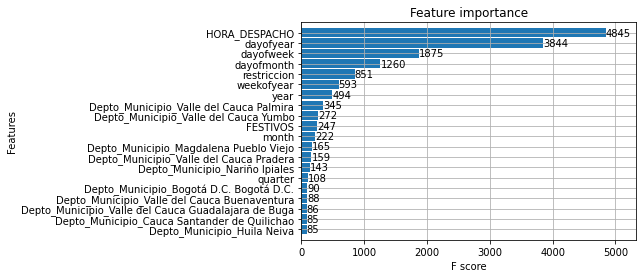

In [41]:
# 3. Evaluate the model

# Feature importance
xgb.plot_importance(model_cali, ax=plt.gca(),max_num_features=20, height = 0.9)

# Metrics
predtrain_cali = model_cali.predict(x_train_cali)
print('R2 train',r2_score(y_train_cali,predtrain_cali))
print('MSE train',mean_squared_error(y_train_cali,predtrain_cali))
print('RMSE train',np.sqrt(mean_squared_error(y_train_cali,predtrain_cali)))

predtest_cali=model_cali.predict(x_test_cali)
print('R2 test',r2_score(y_test_cali,predtest_cali))
print('MSE test',mean_squared_error(y_test_cali,predtest_cali))
print('RMSE test',np.sqrt(mean_squared_error(y_test_cali,predtest_cali)))

print('Percentil 99 Passengers',np.percentile(data_cali['PASAJEROS'],99))

In [42]:
# Export model for dash / plotly
file_name = "xgb_model_cali.pkl"

# save
pickle.dump(model_cali, open(file_name, "wb"))

## T.T. DE CARTAGENA

In [43]:
# 1. Data wrangling

# a. Select the terminal

t_cartagena=df[df['TERMINAL'] =='T.T. DE CARTAGENA']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_cartagena=t_cartagena.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_cartagena = data_cartagena.rename(columns={'sum':'PASAJEROS'})

#Create new features

dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_cartagena['FESTIVOS'] = data_cartagena['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

data_cartagena['dayofweek'] = data_cartagena['FECHA_DESPACHO'].dt.dayofweek
data_cartagena['quarter'] = data_cartagena['FECHA_DESPACHO'].dt.quarter
data_cartagena['month'] = data_cartagena['FECHA_DESPACHO'].dt.month
data_cartagena['year'] = data_cartagena['FECHA_DESPACHO'].dt.year
data_cartagena['dayofyear'] = data_cartagena['FECHA_DESPACHO'].dt.dayofyear
data_cartagena['dayofmonth'] = data_cartagena['FECHA_DESPACHO'].dt.day
data_cartagena['weekofyear'] = data_cartagena['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions

data_cartagena["restriccion"] = np.where(data_cartagena['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_cartagena['FECHA_DESPACHO'] > '2020-03-26')&(data_cartagena['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_cartagena['FECHA_DESPACHO'] >='2020-09-01')&(data_cartagena['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_cartagena['FECHA_DESPACHO'] >='2021-03-01')&(data_cartagena['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destination

data_cartagena["Depto_Municipio"]=data_cartagena['DEPARTAMENTO_DESTINO']+' '+data_cartagena['MUNICIPIO_DESTINO']


<ipython-input-43-328081ca0fba>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_cartagena['weekofyear'] = data_cartagena['FECHA_DESPACHO'].dt.weekofyear


In [44]:
# 2. Model

# Split data in features and target values
x_cartagena=data_cartagena.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_cartagena=data_cartagena['PASAJEROS']

# Encoding categorical data
x_cartagena_encoded=pd.get_dummies(x_cartagena, columns=["Depto_Municipio"])

# Data training and data test
x_train_cartagena, x_test_cartagena, y_train_cartagena, y_test_cartagena = train_test_split(x_cartagena_encoded,y_cartagena,test_size=0.2,random_state=42)
print(x_train_cartagena.shape)
print(x_test_cartagena.shape)

# define model
model_cartagena = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_cartagena.fit(x_train_cartagena, y_train_cartagena)


(119259, 48)
(29815, 48)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.7863218903114577
MSE train 272.48523145570505
RMSE train 16.507126686849684
R2 test 0.7146615762372713
MSE test 358.0081416175005
RMSE test 18.921103076129057
Percentil 99 Passengers 179.0


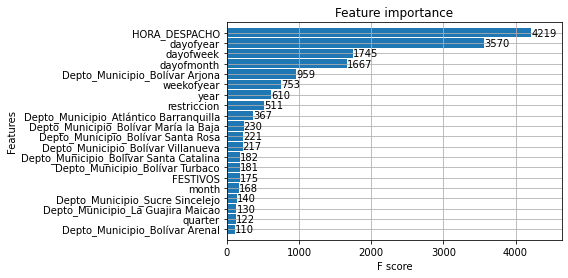

In [45]:
# 3. Evaluate the model

# Feature importance
xgb.plot_importance(model_cartagena, ax=plt.gca(),max_num_features=20, height = 0.9)

# Metrics
predtrain_cartagena = model_cartagena.predict(x_train_cartagena)
print('R2 train',r2_score(y_train_cartagena,predtrain_cartagena))
print('MSE train',mean_squared_error(y_train_cartagena,predtrain_cartagena))
print('RMSE train',np.sqrt(mean_squared_error(y_train_cartagena,predtrain_cartagena)))

predtest_cartagena=model_cartagena.predict(x_test_cartagena)
print('R2 test',r2_score(y_test_cartagena,predtest_cartagena))
print('MSE test',mean_squared_error(y_test_cartagena,predtest_cartagena))
print('RMSE test',np.sqrt(mean_squared_error(y_test_cartagena,predtest_cartagena)))

print('Percentil 99 Passengers',np.percentile(data_cartagena['PASAJEROS'],99))


In [46]:
# Export model for dash / plotly
file_name = "xgb_model_cartagena.pkl"

# save
pickle.dump(model_cartagena, open(file_name, "wb"))

## T.T. DE CHIQUINQUIRÁ

In [47]:
# 1. Data wrangling

# a. Select the terminal

t_chiquinquira=df[df['TERMINAL'] =='T.T. DE CHIQUINQUIRÁ']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_chiquinquira=t_chiquinquira.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_chiquinquira = data_chiquinquira.rename(columns={'sum':'PASAJEROS'})

#Create new features

dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_chiquinquira['FESTIVOS'] = data_chiquinquira['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

data_chiquinquira['dayofweek'] = data_chiquinquira['FECHA_DESPACHO'].dt.dayofweek
data_chiquinquira['quarter'] = data_chiquinquira['FECHA_DESPACHO'].dt.quarter
data_chiquinquira['month'] = data_chiquinquira['FECHA_DESPACHO'].dt.month
data_chiquinquira['year'] = data_chiquinquira['FECHA_DESPACHO'].dt.year
data_chiquinquira['dayofyear'] = data_chiquinquira['FECHA_DESPACHO'].dt.dayofyear
data_chiquinquira['dayofmonth'] = data_chiquinquira['FECHA_DESPACHO'].dt.day
data_chiquinquira['weekofyear'] = data_chiquinquira['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions

data_chiquinquira["restriccion"] = np.where(data_chiquinquira['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_chiquinquira['FECHA_DESPACHO'] > '2020-03-26')&(data_chiquinquira['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_chiquinquira['FECHA_DESPACHO'] >='2020-09-01')&(data_chiquinquira['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_chiquinquira['FECHA_DESPACHO'] >='2021-03-01')&(data_chiquinquira['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destination

data_chiquinquira["Depto_Municipio"]=data_chiquinquira['DEPARTAMENTO_DESTINO']+' '+data_chiquinquira['MUNICIPIO_DESTINO']

<ipython-input-47-20407f735bc9>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_chiquinquira['weekofyear'] = data_chiquinquira['FECHA_DESPACHO'].dt.weekofyear


In [48]:
# 2. Model

# Split data in features and target values
x_chiquinquira=data_chiquinquira.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_chiquinquira=data_chiquinquira['PASAJEROS']

# Encoding categorical data
x_chiquinquira_encoded=pd.get_dummies(x_chiquinquira, columns=["Depto_Municipio"])

# Data training and data test
x_train_chiquinquira, x_test_chiquinquira, y_train_chiquinquira, y_test_chiquinquira = train_test_split(x_chiquinquira_encoded,y_chiquinquira,test_size=0.2,random_state=42)
print(x_train_chiquinquira.shape)
print(x_test_chiquinquira.shape)

# define model
model_chiquinquira = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_chiquinquira.fit(x_train_chiquinquira, y_train_chiquinquira)


(68594, 40)
(17149, 40)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.9286841744820505
MSE train 61.19430263965448
RMSE train 7.82267873810848
R2 test 0.8673839393231842
MSE test 120.84201481376391
RMSE test 10.992816509601345
Percentil 99 Passengers 138.0


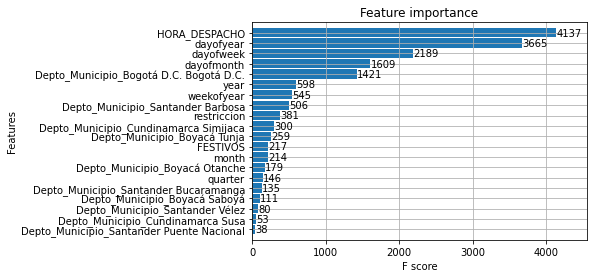

In [49]:
# 3. Evaluate the model

# Feature importance
xgb.plot_importance(model_chiquinquira, ax=plt.gca(),max_num_features=20, height = 0.9)

Metrics
predtrain_chiquinquira = model_chiquinquira.predict(x_train_chiquinquira)
print('R2 train',r2_score(y_train_chiquinquira,predtrain_chiquinquira))
print('MSE train',mean_squared_error(y_train_chiquinquira,predtrain_chiquinquira))
print('RMSE train',np.sqrt(mean_squared_error(y_train_chiquinquira,predtrain_chiquinquira)))

predtest_chiquinquira=model_chiquinquira.predict(x_test_chiquinquira)
print('R2 test',r2_score(y_test_chiquinquira,predtest_chiquinquira))
print('MSE test',mean_squared_error(y_test_chiquinquira,predtest_chiquinquira))
print('RMSE test',np.sqrt(mean_squared_error(y_test_chiquinquira,predtest_chiquinquira)))

print('Percentil 99 Passengers',np.percentile(data_chiquinquira['PASAJEROS'],99))

In [50]:
# Export model for dash / plotly
file_name = "xgb_model_chiquinquira.pkl"

# save
pickle.dump(model_chiquinquira, open(file_name, "wb"))

## T.T. DE CÚCUTA

In [51]:
# 1. Data wrangling

# a. Select the terminal

t_cucuta=df[df['TERMINAL'] =='T.T. DE CÚCUTA']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_cucuta=t_cucuta.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_cucuta = data_cucuta.rename(columns={'sum':'PASAJEROS'})

#c. Create new features
# Holidays
dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_cucuta['FESTIVOS'] = data_cucuta['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

# Features date
data_cucuta['dayofweek'] = data_cucuta['FECHA_DESPACHO'].dt.dayofweek
data_cucuta['quarter'] = data_cucuta['FECHA_DESPACHO'].dt.quarter
data_cucuta['month'] = data_cucuta['FECHA_DESPACHO'].dt.month
data_cucuta['year'] = data_cucuta['FECHA_DESPACHO'].dt.year
data_cucuta['dayofyear'] = data_cucuta['FECHA_DESPACHO'].dt.dayofyear
data_cucuta['dayofmonth'] = data_cucuta['FECHA_DESPACHO'].dt.day
data_cucuta['weekofyear'] = data_cucuta['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions
data_cucuta["restriccion"] = np.where(data_cucuta['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_cucuta['FECHA_DESPACHO'] > '2020-03-26')&(data_cucuta['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_cucuta['FECHA_DESPACHO'] >='2020-09-01')&(data_cucuta['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_cucuta['FECHA_DESPACHO'] >='2021-03-01')&(data_cucuta['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destination
data_cucuta["Depto_Municipio"]=data_cucuta['DEPARTAMENTO_DESTINO']+' '+data_cucuta['MUNICIPIO_DESTINO']


<ipython-input-51-23ac761ab3ed>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_cucuta['weekofyear'] = data_cucuta['FECHA_DESPACHO'].dt.weekofyear


In [52]:
# 2. Model

# Split data in features and target values
x_cucuta=data_cucuta.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_cucuta=data_cucuta['PASAJEROS']

# Encoding categorical data
x_cucuta_encoded=pd.get_dummies(x_cucuta, columns=["Depto_Municipio"])

# Data training and data test
x_train_cucuta, x_test_cucuta, y_train_cucuta, y_test_cucuta = train_test_split(x_cucuta_encoded,y_cucuta,test_size=0.2,random_state=42)
print(x_train_cucuta.shape)
print(x_test_cucuta.shape)

# define model
model_cucuta = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_cucuta.fit(x_train_cucuta, y_train_cucuta)


(74483, 53)
(18621, 53)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.7948315702676021
MSE train 110.35375422233295
RMSE train 10.504939515405738
R2 test 0.658801170482477
MSE test 181.4489912717627
RMSE test 13.470300340815074
Percentil 99 Passengers 124.0


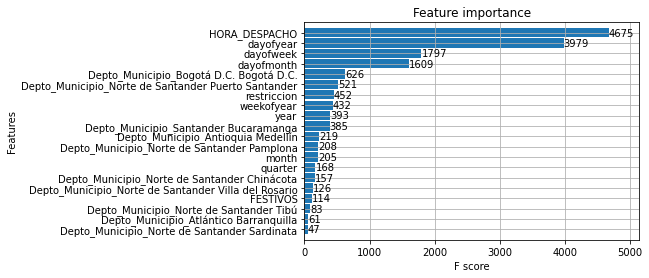

In [53]:
# 3. Evaluate the model

# Feature importance 
xgb.plot_importance(model_cucuta, ax=plt.gca(),max_num_features=20, height = 0.9)

# Metrics
predtrain_cucuta = model_cucuta.predict(x_train_cucuta)
print('R2 train',r2_score(y_train_cucuta,predtrain_cucuta))
print('MSE train',mean_squared_error(y_train_cucuta,predtrain_cucuta))
print('RMSE train',np.sqrt(mean_squared_error(y_train_cucuta,predtrain_cucuta)))

predtest_cucuta=model_cucuta.predict(x_test_cucuta)
print('R2 test',r2_score(y_test_cucuta,predtest_cucuta))
print('MSE test',mean_squared_error(y_test_cucuta,predtest_cucuta))
print('RMSE test',np.sqrt(mean_squared_error(y_test_cucuta,predtest_cucuta)))

print('Percentil 99 Passengers',np.percentile(data_cucuta['PASAJEROS'],99))

In [54]:
# Export model for dash / plotly
file_name = "xgb_model_cucuta.pkl"

# save
pickle.dump(model_cucuta, open(file_name, "wb"))

## T.T. DE DUITAMA

In [55]:
# 1. Data wrangling

# a. Select the terminal

t_duitama=df[df['TERMINAL'] =='T.T. DE DUITAMA']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_duitama=t_duitama.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_duitama = data_duitama.rename(columns={'sum':'PASAJEROS'})

# c. Create new features

# Holidays
dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_duitama['FESTIVOS'] = data_duitama['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

# Features date
data_duitama['dayofweek'] = data_duitama['FECHA_DESPACHO'].dt.dayofweek
data_duitama['quarter'] = data_duitama['FECHA_DESPACHO'].dt.quarter
data_duitama['month'] = data_duitama['FECHA_DESPACHO'].dt.month
data_duitama['year'] = data_duitama['FECHA_DESPACHO'].dt.year
data_duitama['dayofyear'] = data_duitama['FECHA_DESPACHO'].dt.dayofyear
data_duitama['dayofmonth'] = data_duitama['FECHA_DESPACHO'].dt.day
data_duitama['weekofyear'] = data_duitama['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions

data_duitama["restriccion"] = np.where(data_duitama['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_duitama['FECHA_DESPACHO'] > '2020-03-26')&(data_duitama['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_duitama['FECHA_DESPACHO'] >='2020-09-01')&(data_duitama['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_duitama['FECHA_DESPACHO'] >='2021-03-01')&(data_duitama['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destination
data_duitama["Depto_Municipio"]=data_duitama['DEPARTAMENTO_DESTINO']+' '+data_duitama['MUNICIPIO_DESTINO']


<ipython-input-55-873106494bbe>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_duitama['weekofyear'] = data_duitama['FECHA_DESPACHO'].dt.weekofyear


In [56]:
# 2. Model

# Split data in features and target values
x_duitama=data_duitama.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_duitama=data_duitama['PASAJEROS']

# Encoding categorical data
x_duitama_encoded=pd.get_dummies(x_duitama, columns=["Depto_Municipio"])

# Data training and data test
x_train_duitama, x_test_duitama, y_train_duitama, y_test_duitama = train_test_split(x_duitama_encoded,y_duitama,test_size=0.2,random_state=42)
print(x_train_duitama.shape)
print(x_test_duitama.shape)

# define model
model_duitama = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_duitama.fit(x_train_duitama, y_train_duitama)


(90053, 53)
(22514, 53)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.9012071867760747
MSE train 212.43524384508387
RMSE train 14.57515845008499
R2 test 0.8704683118789067
MSE test 287.9731464221209
RMSE test 16.969771548907808
Percentil 99 Passengers 223.0


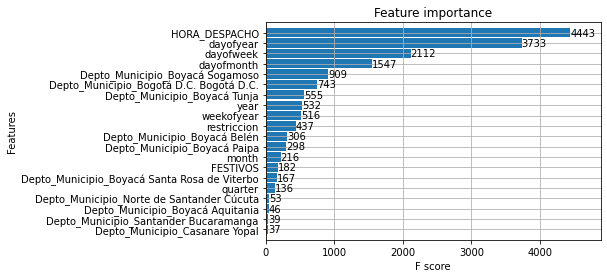

In [57]:
# 3. Evaluate the model

# Feature importance
xgb.plot_importance(model_duitama, ax=plt.gca(),max_num_features=20, height = 0.9)

# Metrics
predtrain_duitama = model_duitama.predict(x_train_duitama)
print('R2 train',r2_score(y_train_duitama,predtrain_duitama))
print('MSE train',mean_squared_error(y_train_duitama,predtrain_duitama))
print('RMSE train',np.sqrt(mean_squared_error(y_train_duitama,predtrain_duitama)))

predtest_duitama=model_duitama.predict(x_test_duitama)
print('R2 test',r2_score(y_test_duitama,predtest_duitama))
print('MSE test',mean_squared_error(y_test_duitama,predtest_duitama))
print('RMSE test',np.sqrt(mean_squared_error(y_test_duitama,predtest_duitama)))

print('Percentil 99 Passengers',np.percentile(data_duitama['PASAJEROS'],99))


In [58]:
# Export model for dash / plotly
file_name = "xgb_model_duitama.pkl"

# save
pickle.dump(model_duitama, open(file_name, "wb"))

## T.T. DE ESPINAL

In [59]:
# 1. Data wrangling

# a. Select the terminal

t_espinal=df[df['TERMINAL'] =='T.T. DE ESPINAL']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_espinal=t_espinal.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_espinal = data_espinal.rename(columns={'sum':'PASAJEROS'})

# c. Create new features

# Holidays
dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_espinal['FESTIVOS'] = data_espinal['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

# Features date
data_espinal['dayofweek'] = data_espinal['FECHA_DESPACHO'].dt.dayofweek
data_espinal['quarter'] = data_espinal['FECHA_DESPACHO'].dt.quarter
data_espinal['month'] = data_espinal['FECHA_DESPACHO'].dt.month
data_espinal['year'] = data_espinal['FECHA_DESPACHO'].dt.year
data_espinal['dayofyear'] = data_espinal['FECHA_DESPACHO'].dt.dayofyear
data_espinal['dayofmonth'] = data_espinal['FECHA_DESPACHO'].dt.day
data_espinal['weekofyear'] = data_espinal['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions

data_espinal["restriccion"] = np.where(data_espinal['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_espinal['FECHA_DESPACHO'] > '2020-03-26')&(data_espinal['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_espinal['FECHA_DESPACHO'] >='2020-09-01')&(data_espinal['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_espinal['FECHA_DESPACHO'] >='2021-03-01')&(data_espinal['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destinations

data_espinal["Depto_Municipio"]=data_espinal['DEPARTAMENTO_DESTINO']+' '+data_espinal['MUNICIPIO_DESTINO']


<ipython-input-59-7cc2b2c38759>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_espinal['weekofyear'] = data_espinal['FECHA_DESPACHO'].dt.weekofyear


In [60]:
# 2. Model

# Split data in features and target values
x_espinal=data_espinal.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_espinal=data_espinal['PASAJEROS']

# Encoding categorical data
x_espinal_encoded=pd.get_dummies(x_espinal, columns=["Depto_Municipio"])

# Data training and data test
x_train_espinal, x_test_espinal, y_train_espinal, y_test_espinal = train_test_split(x_espinal_encoded,y_espinal,test_size=0.2,random_state=42)
print(x_train_espinal.shape)
print(x_test_espinal.shape)

# define model
model_espinal = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_espinal.fit(x_train_espinal, y_train_espinal)


(77490, 44)
(19373, 44)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.8630897470573572
MSE train 90.68215980255827
RMSE train 9.522718088999499
R2 test 0.783311946259748
MSE test 152.78528760883927
RMSE test 12.360634595717134
Percentil 99 Passengers 114.0


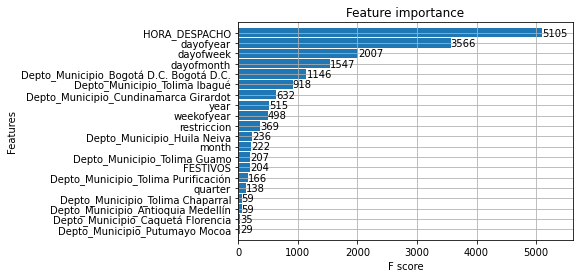

In [61]:
# 3. Evaluate the model

# Feature importance
xgb.plot_importance(model_espinal, ax=plt.gca(),max_num_features=20, height = 0.9)

# Metrics
predtrain_espinal = model_espinal.predict(x_train_espinal)
print('R2 train',r2_score(y_train_espinal,predtrain_espinal))
print('MSE train',mean_squared_error(y_train_espinal,predtrain_espinal))
print('RMSE train',np.sqrt(mean_squared_error(y_train_espinal,predtrain_espinal)))

predtest_espinal=model_espinal.predict(x_test_espinal)
print('R2 test',r2_score(y_test_espinal,predtest_espinal))
print('MSE test',mean_squared_error(y_test_espinal,predtest_espinal))
print('RMSE test',np.sqrt(mean_squared_error(y_test_espinal,predtest_espinal)))

print('Percentil 99 Passengers',np.percentile(data_espinal['PASAJEROS'],99))


In [62]:
# Export model for dash / plotly
file_name = "xgb_model_espinal.pkl"

# save
pickle.dump(model_espinal, open(file_name, "wb"))

## T.T. DE FLORENCIA

In [63]:
# 1. Data wrangling

# a. Select the terminal

t_florencia=df[df['TERMINAL'] =='T.T. DE FLORENCIA']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_florencia=t_florencia.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_florencia = data_florencia.rename(columns={'sum':'PASAJEROS'})

# c. Create new features

# Holidays
dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_florencia['FESTIVOS'] = data_florencia['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

# Features date
data_florencia['dayofweek'] = data_florencia['FECHA_DESPACHO'].dt.dayofweek
data_florencia['quarter'] = data_florencia['FECHA_DESPACHO'].dt.quarter
data_florencia['month'] = data_florencia['FECHA_DESPACHO'].dt.month
data_florencia['year'] = data_florencia['FECHA_DESPACHO'].dt.year
data_florencia['dayofyear'] = data_florencia['FECHA_DESPACHO'].dt.dayofyear
data_florencia['dayofmonth'] = data_florencia['FECHA_DESPACHO'].dt.day
data_florencia['weekofyear'] = data_florencia['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions

data_florencia["restriccion"] = np.where(data_florencia['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_florencia['FECHA_DESPACHO'] > '2020-03-26')&(data_florencia['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_florencia['FECHA_DESPACHO'] >='2020-09-01')&(data_florencia['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_florencia['FECHA_DESPACHO'] >='2021-03-01')&(data_florencia['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destination
data_florencia["Depto_Municipio"]=data_florencia['DEPARTAMENTO_DESTINO']+' '+data_florencia['MUNICIPIO_DESTINO']


<ipython-input-63-0a87690b76b5>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_florencia['weekofyear'] = data_florencia['FECHA_DESPACHO'].dt.weekofyear


In [64]:
# 2. Model

# Split data in features and target values
x_florencia=data_florencia.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_florencia=data_florencia['PASAJEROS']

# Encoding categorical data
x_florencia_encoded=pd.get_dummies(x_florencia, columns=["Depto_Municipio"])

# Data training and data test
x_train_florencia, x_test_florencia, y_train_florencia, y_test_florencia = train_test_split(x_florencia_encoded,y_florencia,test_size=0.2,random_state=42)
print(x_train_florencia.shape)
print(x_test_florencia.shape)

# define model
model_florencia = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_florencia.fit(x_train_florencia, y_train_florencia)


(87600, 38)
(21900, 38)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.7814483627863597
MSE train 27.10430480416035
RMSE train 5.206179482515019
R2 test 0.6839643716910967
MSE test 38.834786604973694
RMSE test 6.231756301795962
Percentil 99 Passengers 53.0


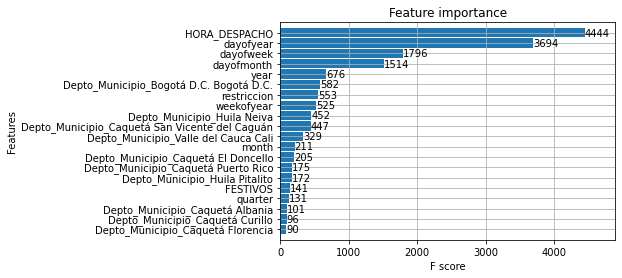

In [65]:
# 3. Evaluate the model

# Feature importance
xgb.plot_importance(model_florencia, ax=plt.gca(),max_num_features=20, height = 0.9)

# Metrics
predtrain_florencia = model_florencia.predict(x_train_florencia)
print('R2 train',r2_score(y_train_florencia,predtrain_florencia))
print('MSE train',mean_squared_error(y_train_florencia,predtrain_florencia))
print('RMSE train',np.sqrt(mean_squared_error(y_train_florencia,predtrain_florencia)))

predtest_florencia=model_florencia.predict(x_test_florencia)
print('R2 test',r2_score(y_test_florencia,predtest_florencia))
print('MSE test',mean_squared_error(y_test_florencia,predtest_florencia))
print('RMSE test',np.sqrt(mean_squared_error(y_test_florencia,predtest_florencia)))

print('Percentil 99 Passengers',np.percentile(data_florencia['PASAJEROS'],99))

In [66]:
# Export model for dash / plotly
file_name = "xgb_model_florencia.pkl"

# save
pickle.dump(model_florencia, open(file_name, "wb"))

## T.T. DE FUSAGASUGA

In [67]:
# 1. Data wrangling

# a. Select the terminal

t_fusagasuga=df[df['TERMINAL'] =='T.T. DE FUSAGASUGA']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_fusagasuga=t_fusagasuga.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_fusagasuga = data_fusagasuga.rename(columns={'sum':'PASAJEROS'})

# Create new features

# Holidays
dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_fusagasuga['FESTIVOS'] = data_fusagasuga['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

# Features date
data_fusagasuga['dayofweek'] = data_fusagasuga['FECHA_DESPACHO'].dt.dayofweek
data_fusagasuga['quarter'] = data_fusagasuga['FECHA_DESPACHO'].dt.quarter
data_fusagasuga['month'] = data_fusagasuga['FECHA_DESPACHO'].dt.month
data_fusagasuga['year'] = data_fusagasuga['FECHA_DESPACHO'].dt.year
data_fusagasuga['dayofyear'] = data_fusagasuga['FECHA_DESPACHO'].dt.dayofyear
data_fusagasuga['dayofmonth'] = data_fusagasuga['FECHA_DESPACHO'].dt.day
data_fusagasuga['weekofyear'] = data_fusagasuga['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions

data_fusagasuga["restriccion"] = np.where(data_fusagasuga['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_fusagasuga['FECHA_DESPACHO'] > '2020-03-26')&(data_fusagasuga['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_fusagasuga['FECHA_DESPACHO'] >='2020-09-01')&(data_fusagasuga['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_fusagasuga['FECHA_DESPACHO'] >='2021-03-01')&(data_fusagasuga['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destination
data_fusagasuga["Depto_Municipio"]=data_fusagasuga['DEPARTAMENTO_DESTINO']+' '+data_fusagasuga['MUNICIPIO_DESTINO']


<ipython-input-67-2f3ca7d47739>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_fusagasuga['weekofyear'] = data_fusagasuga['FECHA_DESPACHO'].dt.weekofyear


In [68]:
# 2. Model

# Split data in features and target values
x_fusagasuga=data_fusagasuga.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_fusagasuga=data_fusagasuga['PASAJEROS']

# Encoding categorical data
x_fusagasuga_encoded=pd.get_dummies(x_fusagasuga, columns=["Depto_Municipio"])

# Data training and data test
x_train_fusagasuga, x_test_fusagasuga, y_train_fusagasuga, y_test_fusagasuga = train_test_split(x_fusagasuga_encoded,y_fusagasuga,test_size=0.2,random_state=42)
print(x_train_fusagasuga.shape)
print(x_test_fusagasuga.shape)

# define model
model_fusagasuga = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_fusagasuga.fit(x_train_fusagasuga, y_train_fusagasuga)


(65332, 47)
(16334, 47)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.9488884125171974
MSE train 80.762535744086
RMSE train 8.986797858196544
R2 test 0.8827321442246256
MSE test 188.07385568819862
RMSE test 13.714002176177406
Percentil 99 Passengers 203.0


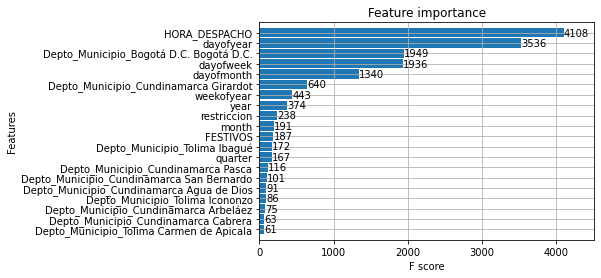

In [69]:
# 3. Evaluate the model

#Feature importance
xgb.plot_importance(model_fusagasuga, ax=plt.gca(),max_num_features=20, height = 0.9)

# Metrics
predtrain_fusagasuga = model_fusagasuga.predict(x_train_fusagasuga)
print('R2 train',r2_score(y_train_fusagasuga,predtrain_fusagasuga))
print('MSE train',mean_squared_error(y_train_fusagasuga,predtrain_fusagasuga))
print('RMSE train',np.sqrt(mean_squared_error(y_train_fusagasuga,predtrain_fusagasuga)))

predtest_fusagasuga=model_fusagasuga.predict(x_test_fusagasuga)
print('R2 test',r2_score(y_test_fusagasuga,predtest_fusagasuga))
print('MSE test',mean_squared_error(y_test_fusagasuga,predtest_fusagasuga))
print('RMSE test',np.sqrt(mean_squared_error(y_test_fusagasuga,predtest_fusagasuga)))

print('Percentil 99 Passengers',np.percentile(data_fusagasuga['PASAJEROS'],99))

In [70]:
# Export model for dash / plotly
file_name = "xgb_model_fusagasuga.pkl"

# save
pickle.dump(model_fusagasuga, open(file_name, "wb"))

## T.T. DE GARZÓN

In [71]:
# 1. Data wrangling

# a. Select the terminal

t_garzon=df[df['TERMINAL'] =='T.T. DE GARZÓN']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_garzon=t_garzon.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_garzon = data_garzon.rename(columns={'sum':'PASAJEROS'})

# c. Create new features

# Holidays
dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_garzon['FESTIVOS'] = data_garzon['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

# Features date
data_garzon['dayofweek'] = data_garzon['FECHA_DESPACHO'].dt.dayofweek
data_garzon['quarter'] = data_garzon['FECHA_DESPACHO'].dt.quarter
data_garzon['month'] = data_garzon['FECHA_DESPACHO'].dt.month
data_garzon['year'] = data_garzon['FECHA_DESPACHO'].dt.year
data_garzon['dayofyear'] = data_garzon['FECHA_DESPACHO'].dt.dayofyear
data_garzon['dayofmonth'] = data_garzon['FECHA_DESPACHO'].dt.day
data_garzon['weekofyear'] = data_garzon['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions
data_garzon["restriccion"] = np.where(data_garzon['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_garzon['FECHA_DESPACHO'] > '2020-03-26')&(data_garzon['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_garzon['FECHA_DESPACHO'] >='2020-09-01')&(data_garzon['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_garzon['FECHA_DESPACHO'] >='2021-03-01')&(data_garzon['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destination
data_garzon["Depto_Municipio"]=data_garzon['DEPARTAMENTO_DESTINO']+' '+data_garzon['MUNICIPIO_DESTINO']


<ipython-input-71-437c663d5d07>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_garzon['weekofyear'] = data_garzon['FECHA_DESPACHO'].dt.weekofyear


In [72]:
# 2. Model

# Split data in features and target values
x_garzon=data_garzon.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_garzon=data_garzon['PASAJEROS']

# Encoding categorical data
x_garzon_encoded=pd.get_dummies(x_garzon, columns=["Depto_Municipio"])

# Data training and data test
x_train_garzon, x_test_garzon, y_train_garzon, y_test_garzon = train_test_split(x_garzon_encoded,y_garzon,test_size=0.2,random_state=42)
print(x_train_garzon.shape)
print(x_test_garzon.shape)

# define model
model_garzon = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_garzon.fit(x_train_garzon, y_train_garzon)


(76090, 57)
(19023, 57)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.80809840019801
MSE train 28.798726393664275
RMSE train 5.366444483423291
R2 test 0.7027380430690117
MSE test 44.06226525003915
RMSE test 6.637941341262301
Percentil 99 Passengers 57.0


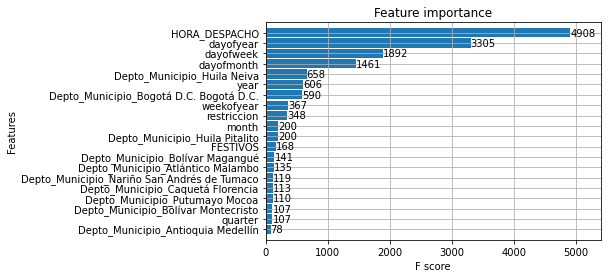

In [73]:
# 3. Evaluate the model

# Feature importance
xgb.plot_importance(model_garzon, ax=plt.gca(),max_num_features=20, height = 0.9)

# Metrics
predtrain_garzon = model_garzon.predict(x_train_garzon)
print('R2 train',r2_score(y_train_garzon,predtrain_garzon))
print('MSE train',mean_squared_error(y_train_garzon,predtrain_garzon))
print('RMSE train',np.sqrt(mean_squared_error(y_train_garzon,predtrain_garzon)))

predtest_garzon=model_garzon.predict(x_test_garzon)
print('R2 test',r2_score(y_test_garzon,predtest_garzon))
print('MSE test',mean_squared_error(y_test_garzon,predtest_garzon))
print('RMSE test',np.sqrt(mean_squared_error(y_test_garzon,predtest_garzon)))

print('Percentil 99 Passengers',np.percentile(data_garzon['PASAJEROS'],99))

In [74]:
# Export model for dash / plotly
file_name = "xgb_model_garzon.pkl"

# save
pickle.dump(model_garzon, open(file_name, "wb"))

## T.T. DE GIRARDOT

In [75]:
# 1. Data wrangling

# a. Select the terminal
t_girardot=df[df['TERMINAL'] =='T.T. DE GIRARDOT']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_girardot=t_girardot.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_girardot = data_girardot.rename(columns={'sum':'PASAJEROS'})

# c. Create new features

# Holidays
dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_girardot['FESTIVOS'] = data_girardot['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

# Features date
data_girardot['dayofweek'] = data_girardot['FECHA_DESPACHO'].dt.dayofweek
data_girardot['quarter'] = data_girardot['FECHA_DESPACHO'].dt.quarter
data_girardot['month'] = data_girardot['FECHA_DESPACHO'].dt.month
data_girardot['year'] = data_girardot['FECHA_DESPACHO'].dt.year
data_girardot['dayofyear'] = data_girardot['FECHA_DESPACHO'].dt.dayofyear
data_girardot['dayofmonth'] = data_girardot['FECHA_DESPACHO'].dt.day
data_girardot['weekofyear'] = data_girardot['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions
data_girardot["restriccion"] = np.where(data_girardot['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_girardot['FECHA_DESPACHO'] > '2020-03-26')&(data_girardot['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_girardot['FECHA_DESPACHO'] >='2020-09-01')&(data_girardot['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_girardot['FECHA_DESPACHO'] >='2021-03-01')&(data_girardot['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destination
data_girardot["Depto_Municipio"]=data_girardot['DEPARTAMENTO_DESTINO']+' '+data_girardot['MUNICIPIO_DESTINO']


<ipython-input-75-f342a7ad3751>:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_girardot['weekofyear'] = data_girardot['FECHA_DESPACHO'].dt.weekofyear


In [76]:
# 2. Model

# Split data in features and target values
x_girardot=data_girardot.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_girardot=data_girardot['PASAJEROS']

# Encoding categorical data
x_girardot_encoded=pd.get_dummies(x_girardot, columns=["Depto_Municipio"])

# Data training and data test
x_train_girardot, x_test_girardot, y_train_girardot, y_test_girardot = train_test_split(x_girardot_encoded,y_girardot,test_size=0.2,random_state=42)
print(x_train_girardot.shape)
print(x_test_girardot.shape)

# define model
model_girardot = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_girardot.fit(x_train_girardot, y_train_girardot)


(55875, 37)
(13969, 37)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.943311522373448
MSE train 91.23122758688746
RMSE train 9.55150394371941
R2 test 0.8898579492263198
MSE test 174.4242309766626
RMSE test 13.206976602412174
Percentil 99 Passengers 180.0


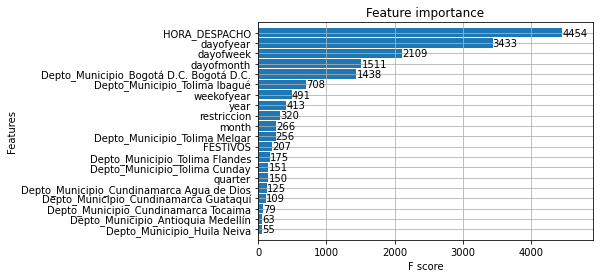

In [77]:
# 3. Evaluate the model

# Feature importance
xgb.plot_importance(model_girardot, ax=plt.gca(),max_num_features=20, height = 0.9)

# Metrics
predtrain_girardot = model_girardot.predict(x_train_girardot)
print('R2 train',r2_score(y_train_girardot,predtrain_girardot))
print('MSE train',mean_squared_error(y_train_girardot,predtrain_girardot))
print('RMSE train',np.sqrt(mean_squared_error(y_train_girardot,predtrain_girardot)))

predtest_girardot=model_girardot.predict(x_test_girardot)
print('R2 test',r2_score(y_test_girardot,predtest_girardot))
print('MSE test',mean_squared_error(y_test_girardot,predtest_girardot))
print('RMSE test',np.sqrt(mean_squared_error(y_test_girardot,predtest_girardot)))

print('Percentil 99 Passengers',np.percentile(data_girardot['PASAJEROS'],99))

In [78]:
# Export model for dash / plotly
file_name = "xgb_model_girardot.pkl"

# save
pickle.dump(model_girardot, open(file_name, "wb"))

# T.T. DE HONDA

In [11]:
# 1. Data wrangling

# a. Select the terminal

t_honda=df[df['TERMINAL'] =='T.T. DE HONDA']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_honda=t_honda.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_honda = data_honda.rename(columns={'sum':'PASAJEROS'})

# c. Create new features

#Holidays
dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_honda['FESTIVOS'] = data_honda['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

#Features date
data_honda['dayofweek'] = data_honda['FECHA_DESPACHO'].dt.dayofweek
data_honda['quarter'] = data_honda['FECHA_DESPACHO'].dt.quarter
data_honda['month'] = data_honda['FECHA_DESPACHO'].dt.month
data_honda['year'] = data_honda['FECHA_DESPACHO'].dt.year
data_honda['dayofyear'] = data_honda['FECHA_DESPACHO'].dt.dayofyear
data_honda['dayofmonth'] = data_honda['FECHA_DESPACHO'].dt.day
data_honda['weekofyear'] = data_honda['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions
data_honda["restriccion"] = np.where(data_honda['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_honda['FECHA_DESPACHO'] > '2020-03-26')&(data_honda['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_honda['FECHA_DESPACHO'] >='2020-09-01')&(data_honda['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_honda['FECHA_DESPACHO'] >='2021-03-01')&(data_honda['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destination
data_honda["Depto_Municipio"]=data_honda['DEPARTAMENTO_DESTINO']+' '+data_honda['MUNICIPIO_DESTINO']


<ipython-input-11-35ed58716571>:32: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_honda['weekofyear'] = data_honda['FECHA_DESPACHO'].dt.weekofyear


In [12]:
# 2. Model

# Split data in features and target values
x_honda=data_honda.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_honda=data_honda['PASAJEROS']

# Encoding categorical data
x_honda_encoded=pd.get_dummies(x_honda, columns=["Depto_Municipio"])

# Data training and data test
x_train_honda, x_test_honda, y_train_honda, y_test_honda = train_test_split(x_honda_encoded,y_honda,test_size=0.2,random_state=42)
print(x_train_honda.shape)
print(x_test_honda.shape)

# define model
model_honda = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_honda.fit(x_train_honda, y_train_honda)

(91585, 44)
(22897, 44)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.7588951640756647
MSE train 30.493471191703282
RMSE train 5.522089386428227
R2 test 0.659387110065333
MSE test 42.32980543094538
RMSE test 6.506135983127418
Percentil 99 Passengers 52.0


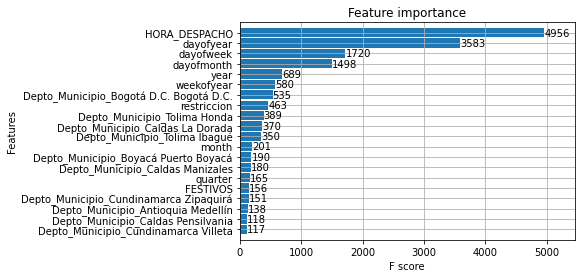

In [13]:
# 3. Evaluate the model

#Feature importance
xgb.plot_importance(model_honda, ax=plt.gca(),max_num_features=20, height = 0.9)

# Metrics
predtrain_honda = model_honda.predict(x_train_honda)
print('R2 train',r2_score(y_train_honda,predtrain_honda))
print('MSE train',mean_squared_error(y_train_honda,predtrain_honda))
print('RMSE train',np.sqrt(mean_squared_error(y_train_honda,predtrain_honda)))

predtest_honda=model_honda.predict(x_test_honda)
print('R2 test',r2_score(y_test_honda,predtest_honda))
print('MSE test',mean_squared_error(y_test_honda,predtest_honda))
print('RMSE test',np.sqrt(mean_squared_error(y_test_honda,predtest_honda)))

print('Percentil 99 Passengers',np.percentile(data_honda['PASAJEROS'],99))


In [14]:
# Export model for dash / plotly
file_name = "xgb_model_honda.pkl"

# save
pickle.dump(model_honda, open(file_name, "wb"))

## T.T. DE IBAGUÉ

In [79]:
# 1. Data wrangling

# a. Select the terminal

t_ibague=df[df['TERMINAL'] =='T.T. DE IBAGUÉ']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_ibague=t_ibague.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_ibague = data_ibague.rename(columns={'sum':'PASAJEROS'})

#Create new features

# Holidays
dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_ibague['FESTIVOS'] = data_ibague['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

# Features date
data_ibague['dayofweek'] = data_ibague['FECHA_DESPACHO'].dt.dayofweek
data_ibague['quarter'] = data_ibague['FECHA_DESPACHO'].dt.quarter
data_ibague['month'] = data_ibague['FECHA_DESPACHO'].dt.month
data_ibague['year'] = data_ibague['FECHA_DESPACHO'].dt.year
data_ibague['dayofyear'] = data_ibague['FECHA_DESPACHO'].dt.dayofyear
data_ibague['dayofmonth'] = data_ibague['FECHA_DESPACHO'].dt.day
data_ibague['weekofyear'] = data_ibague['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions
data_ibague["restriccion"] = np.where(data_ibague['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_ibague['FECHA_DESPACHO'] > '2020-03-26')&(data_ibague['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_ibague['FECHA_DESPACHO'] >='2020-09-01')&(data_ibague['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_ibague['FECHA_DESPACHO'] >='2021-03-01')&(data_ibague['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destination
data_ibague["Depto_Municipio"]=data_ibague['DEPARTAMENTO_DESTINO']+' '+data_ibague['MUNICIPIO_DESTINO']


<ipython-input-79-e1ecb195cf54>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_ibague['weekofyear'] = data_ibague['FECHA_DESPACHO'].dt.weekofyear


In [80]:
# 2. Model

# Split data in features and target values
x_ibague=data_ibague.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_ibague=data_ibague['PASAJEROS']

# Encoding categorical data
x_ibague_encoded=pd.get_dummies(x_ibague, columns=["Depto_Municipio"])

# Data training and data test
x_train_ibague, x_test_ibague, y_train_ibague, y_test_ibague = train_test_split(x_ibague_encoded,y_ibague,test_size=0.2,random_state=42)
print(x_train_ibague.shape)
print(x_test_ibague.shape)

# define model
model_ibague = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_ibague.fit(x_train_ibague, y_train_ibague)


(165933, 63)
(41484, 63)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.87408225154166
MSE train 110.65588645103811
RMSE train 10.519310169922651
R2 test 0.8448583214899269
MSE test 137.10699724811332
RMSE test 11.709269714551516
Percentil 99 Passengers 154.0


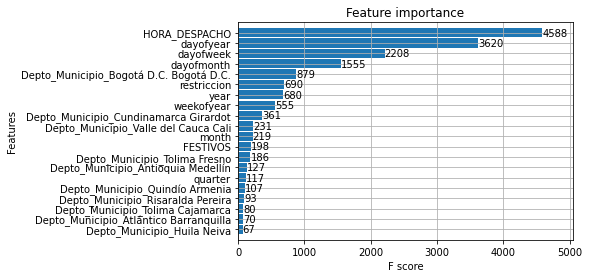

In [81]:
# 3. Evaluate the model

# Feature importance
xgb.plot_importance(model_ibague, ax=plt.gca(),max_num_features=20, height = 0.9)

# Metrics
predtrain_ibague = model_ibague.predict(x_train_ibague)
print('R2 train',r2_score(y_train_ibague,predtrain_ibague))
print('MSE train',mean_squared_error(y_train_ibague,predtrain_ibague))
print('RMSE train',np.sqrt(mean_squared_error(y_train_ibague,predtrain_ibague)))

predtest_ibague=model_ibague.predict(x_test_ibague)
print('R2 test',r2_score(y_test_ibague,predtest_ibague))
print('MSE test',mean_squared_error(y_test_ibague,predtest_ibague))
print('RMSE test',np.sqrt(mean_squared_error(y_test_ibague,predtest_ibague)))

print('Percentil 99 Passengers',np.percentile(data_ibague['PASAJEROS'],99))

In [82]:
# Export model for dash / plotly
file_name = "xgb_model_ibague.pkl"

# save
pickle.dump(model_ibague, open(file_name, "wb"))

## T.T. DE IPIALES

In [83]:
# 1. Data wrangling

# a. Select the terminal
t_ipiales=df[df['TERMINAL'] =='T.T. DE IPIALES']

# b. Select the main features for the model
# Features such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_ipiales=t_ipiales.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_ipiales = data_ipiales.rename(columns={'sum':'PASAJEROS'})

# c. Create new features

# Holidays
dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_ipiales['FESTIVOS'] = data_ipiales['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

# Features date
data_ipiales['dayofweek'] = data_ipiales['FECHA_DESPACHO'].dt.dayofweek
data_ipiales['quarter'] = data_ipiales['FECHA_DESPACHO'].dt.quarter
data_ipiales['month'] = data_ipiales['FECHA_DESPACHO'].dt.month
data_ipiales['year'] = data_ipiales['FECHA_DESPACHO'].dt.year
data_ipiales['dayofyear'] = data_ipiales['FECHA_DESPACHO'].dt.dayofyear
data_ipiales['dayofmonth'] = data_ipiales['FECHA_DESPACHO'].dt.day
data_ipiales['weekofyear'] = data_ipiales['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions
data_ipiales["restriccion"] = np.where(data_ipiales['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_ipiales['FECHA_DESPACHO'] > '2020-03-26')&(data_ipiales['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_ipiales['FECHA_DESPACHO'] >='2020-09-01')&(data_ipiales['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_ipiales['FECHA_DESPACHO'] >='2021-03-01')&(data_ipiales['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destination
data_ipiales["Depto_Municipio"]=data_ipiales['DEPARTAMENTO_DESTINO']+' '+data_ipiales['MUNICIPIO_DESTINO']


<ipython-input-83-b93f195c3620>:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_ipiales['weekofyear'] = data_ipiales['FECHA_DESPACHO'].dt.weekofyear


In [84]:
# 2. Model

# Split data in features and target values
x_ipiales=data_ipiales.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_ipiales=data_ipiales['PASAJEROS']

# Encoding categorical data
x_ipiales_encoded=pd.get_dummies(x_ipiales, columns=["Depto_Municipio"])

# Data training and data test
x_train_ipiales, x_test_ipiales, y_train_ipiales, y_test_ipiales = train_test_split(x_ipiales_encoded,y_ipiales,test_size=0.2,random_state=42)
print(x_train_ipiales.shape)
print(x_test_ipiales.shape)

# define model
model_ipiales = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_ipiales.fit(x_train_ipiales, y_train_ipiales)


(64612, 36)
(16153, 36)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.8737306844037298
MSE train 112.91513967870557
RMSE train 10.626153569316866
R2 test 0.7660517665078423
MSE test 216.45748158786827
RMSE test 14.712494064157452
Percentil 99 Passengers 147.0


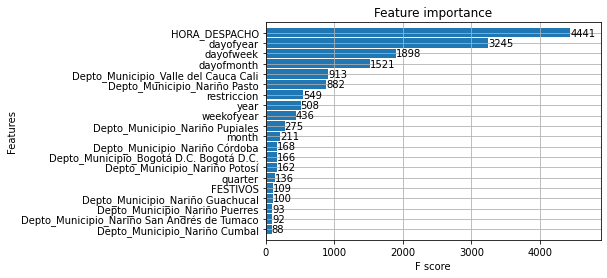

In [85]:
# 3. Evaluate the model

# Feature importance
xgb.plot_importance(model_ipiales, ax=plt.gca(),max_num_features=20, height = 0.9)

# Metrics
predtrain_ipiales = model_ipiales.predict(x_train_ipiales)
print('R2 train',r2_score(y_train_ipiales,predtrain_ipiales))
print('MSE train',mean_squared_error(y_train_ipiales,predtrain_ipiales))
print('RMSE train',np.sqrt(mean_squared_error(y_train_ipiales,predtrain_ipiales)))

predtest_ipiales=model_ipiales.predict(x_test_ipiales)
print('R2 test',r2_score(y_test_ipiales,predtest_ipiales))
print('MSE test',mean_squared_error(y_test_ipiales,predtest_ipiales))
print('RMSE test',np.sqrt(mean_squared_error(y_test_ipiales,predtest_ipiales)))

print('Percentil 99 Passengers',np.percentile(data_ipiales['PASAJEROS'],99))

In [86]:
# Export model for dash / plotly

file_name = "xgb_model_ipiales.pkl"

# save
pickle.dump(model_ipiales, open(file_name, "wb"))

### T.T. DE MANIZALES

In [87]:
# 1. Data wrangling

# a. Select the terminal
t_manizales=df[df['TERMINAL'] =='T.T. DE MANIZALES']

# b. Select the main features for the model
# Features such as type of vehicle or type of service are not considered since they are a consequence of passenger demand
data_manizales=t_manizales.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                     'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_manizales = data_manizales.rename(columns={'sum':'PASAJEROS'})

# c. Create new features

# Holidays
dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

# Features date
data_manizales['FESTIVOS'] =   data_manizales['FECHA_DESPACHO'].isin(dias_festivos20_21)*1
data_manizales['dayofweek'] =  data_manizales['FECHA_DESPACHO'].dt.dayofweek
data_manizales['quarter'] =    data_manizales['FECHA_DESPACHO'].dt.quarter
data_manizales['month'] =      data_manizales['FECHA_DESPACHO'].dt.month
data_manizales['year'] =       data_manizales['FECHA_DESPACHO'].dt.year
data_manizales['dayofyear'] =  data_manizales['FECHA_DESPACHO'].dt.dayofyear
data_manizales['dayofmonth'] = data_manizales['FECHA_DESPACHO'].dt.day
data_manizales['weekofyear'] = data_manizales['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions
data_manizales["restriccion"] = np.where(data_manizales['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_manizales['FECHA_DESPACHO'] > '2020-03-26')&(data_manizales['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_manizales['FECHA_DESPACHO'] >='2020-09-01')&(data_manizales['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_manizales['FECHA_DESPACHO'] >='2021-03-01')&(data_manizales['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destination
data_manizales["Depto_Municipio"]=data_manizales['DEPARTAMENTO_DESTINO']+' '+data_manizales['MUNICIPIO_DESTINO']

<ipython-input-87-ed5a6da6b0d0>:24: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_manizales['weekofyear'] = data_manizales['FECHA_DESPACHO'].dt.weekofyear


In [88]:
# 2. Model

# Set var x and var y
x_manizales=data_manizales.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_manizales=data_manizales['PASAJEROS']

# Encoding categorical data
x_manizales_encoded=pd.get_dummies(x_manizales, columns=["Depto_Municipio"])

# Data training and data test
x_train_manizales, x_test_manizales, y_train_manizales, y_test_manizales = train_test_split(x_manizales_encoded,y_manizales,test_size=0.2,random_state=42)
print(x_train_manizales.shape)
print(x_test_manizales.shape)

# define model
model_manizales = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_manizales.fit(x_train_manizales, y_train_manizales)

(111217, 45)
(27805, 45)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 0.8332428419592123
MSE 105.15341773547875
R2 0.7917307112592471
MSE 138.8645141022867


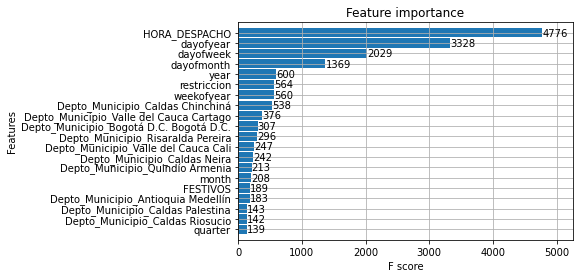

In [89]:
# 3. Evaluate the model

# Feature importance
xgb.plot_importance(model_manizales, ax=plt.gca(),max_num_features=20, height = 0.9)

# Metrics
predtrain_manizales = model_manizales.predict(x_train_manizales)
print('R2',r2_score(y_train_manizales,predtrain_manizales))
print('MSE',mean_squared_error(y_train_manizales,predtrain_manizales))

predtest_manizales=model_manizales.predict(x_test_manizales)
print('R2',r2_score(y_test_manizales,predtest_manizales))
print('MSE',mean_squared_error(y_test_manizales,predtest_manizales))

In [90]:
# Export model for dash / plotly
file_name = "xgb_model_manizales.pkl"

# save
pickle.dump(model_manizales, open(file_name, "wb"))

### T.T. DE MEDELLIN NORTE

In [91]:
# 1. Data wrangling

# a. Select the terminal
t_medellin_n=df[df['TERMINAL'] =='T.T. DE MEDELLÍN NORTE']

# b. Select the main features for the model
# Features such as type of vehicle or type of service are not considered since they are a consequence of passenger demand
data_medellin_n=t_medellin_n.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                     'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_medellin_n = data_medellin_n.rename(columns={'sum':'PASAJEROS'})

# c. Create new features
# Holidays
dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

# Features date
data_medellin_n['FESTIVOS'] =   data_medellin_n['FECHA_DESPACHO'].isin(dias_festivos20_21)*1
data_medellin_n['dayofweek'] =  data_medellin_n['FECHA_DESPACHO'].dt.dayofweek
data_medellin_n['quarter'] =    data_medellin_n['FECHA_DESPACHO'].dt.quarter
data_medellin_n['month'] =      data_medellin_n['FECHA_DESPACHO'].dt.month
data_medellin_n['year'] =       data_medellin_n['FECHA_DESPACHO'].dt.year
data_medellin_n['dayofyear'] =  data_medellin_n['FECHA_DESPACHO'].dt.dayofyear
data_medellin_n['dayofmonth'] = data_medellin_n['FECHA_DESPACHO'].dt.day
data_medellin_n['weekofyear'] = data_medellin_n['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions
data_medellin_n["restriccion"] = np.where(data_medellin_n['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_medellin_n['FECHA_DESPACHO'] > '2020-03-26')&(data_medellin_n['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_medellin_n['FECHA_DESPACHO'] >='2020-09-01')&(data_medellin_n['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_medellin_n['FECHA_DESPACHO'] >='2021-03-01')&(data_medellin_n['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destination
data_medellin_n["Depto_Municipio"]=data_medellin_n['DEPARTAMENTO_DESTINO']+' '+data_medellin_n['MUNICIPIO_DESTINO']

<ipython-input-91-152d328352df>:24: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_medellin_n['weekofyear'] = data_medellin_n['FECHA_DESPACHO'].dt.weekofyear


In [92]:
# 2. Model

# Split data in features and target values
x_medellin_n=data_medellin_n.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_medellin_n=data_medellin_n['PASAJEROS']

# Encoding categorical data
x_medellin_n_encoded=pd.get_dummies(x_medellin_n, columns=["Depto_Municipio"])

# Data training and data test
x_train_medellin_n, x_test_medellin_n, y_train_medellin_n, y_test_medellin_n = train_test_split(x_medellin_n_encoded,y_medellin_n,test_size=0.2,random_state=42)
print(x_train_medellin_n.shape)
print(x_test_medellin_n.shape)

# define model
model_medellin_n = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_medellin_n.fit(x_train_medellin_n, y_train_medellin_n)

(353392, 115)
(88348, 115)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 0.8340840642684483
MSE 178.46632073018904
R2 0.8085279353379187
MSE 207.97531541638313


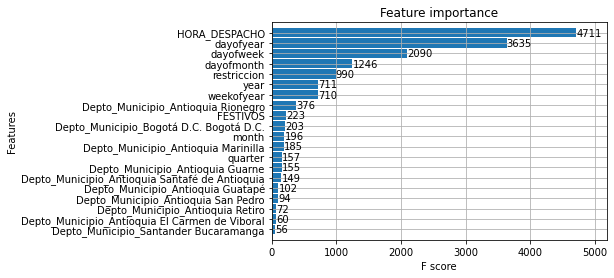

In [93]:
# 3. Evaluate the model

# Feature importance
xgb.plot_importance(model_medellin_n, ax=plt.gca(),max_num_features=20, height = 0.9)

# Metrics
predtrain_medellin_n = model_medellin_n.predict(x_train_medellin_n)
print('R2',r2_score(y_train_medellin_n,predtrain_medellin_n))
print('MSE',mean_squared_error(y_train_medellin_n,predtrain_medellin_n))

predtest_medellin_n=model_medellin_n.predict(x_test_medellin_n)
print('R2',r2_score(y_test_medellin_n,predtest_medellin_n))
print('MSE',mean_squared_error(y_test_medellin_n,predtest_medellin_n))

In [94]:
# Export model for dash / plotly
file_name = "xgb_model_medellin_n.pkl"

# save
pickle.dump(model_medellin_n, open(file_name, "wb"))

### T.T. DE MEDELLIN SUR

In [95]:
# 1. Data wrangling

# a. Select the terminal
t_medellin_s=df[df['TERMINAL'] =='T.T. DE MEDELLÍN SUR']

# b. Select the main features for the model
# Features such as type of vehicle or type of service are not considered since they are a consequence of passenger demand
data_medellin_s=t_medellin_s.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                     'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_medellin_s = data_medellin_s.rename(columns={'sum':'PASAJEROS'})

# c. Create new features

# Holidays
dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

#Features date
data_medellin_s['FESTIVOS'] =   data_medellin_s['FECHA_DESPACHO'].isin(dias_festivos20_21)*1
data_medellin_s['dayofweek'] =  data_medellin_s['FECHA_DESPACHO'].dt.dayofweek
data_medellin_s['quarter'] =    data_medellin_s['FECHA_DESPACHO'].dt.quarter
data_medellin_s['month'] =      data_medellin_s['FECHA_DESPACHO'].dt.month
data_medellin_s['year'] =       data_medellin_s['FECHA_DESPACHO'].dt.year
data_medellin_s['dayofyear'] =  data_medellin_s['FECHA_DESPACHO'].dt.dayofyear
data_medellin_s['dayofmonth'] = data_medellin_s['FECHA_DESPACHO'].dt.day
data_medellin_s['weekofyear'] = data_medellin_s['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions
data_medellin_s["restriccion"] = np.where(data_medellin_s['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_medellin_s['FECHA_DESPACHO'] > '2020-03-26')&(data_medellin_s['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_medellin_s['FECHA_DESPACHO'] >='2020-09-01')&(data_medellin_s['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_medellin_s['FECHA_DESPACHO'] >='2021-03-01')&(data_medellin_s['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destination
data_medellin_s["Depto_Municipio"]=data_medellin_s['DEPARTAMENTO_DESTINO']+' '+data_medellin_s['MUNICIPIO_DESTINO']

<ipython-input-95-dafa3999d33d>:24: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_medellin_s['weekofyear'] = data_medellin_s['FECHA_DESPACHO'].dt.weekofyear


In [96]:
# 2. Model

# Split data in features and target values
x_medellin_s=data_medellin_s.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_medellin_s=data_medellin_s['PASAJEROS']

# Encoding categorical data
x_medellin_s_encoded=pd.get_dummies(x_medellin_s, columns=["Depto_Municipio"])

# Data training and data test
x_train_medellin_s, x_test_medellin_s, y_train_medellin_s, y_test_medellin_s = train_test_split(x_medellin_s_encoded,y_medellin_s,test_size=0.2,random_state=42)
print(x_train_medellin_s.shape)
print(x_test_medellin_s.shape)

# define model
model_medellin_s = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_medellin_s.fit(x_train_medellin_s, y_train_medellin_s)

(162275, 77)
(40569, 77)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 0.8094067141278504
MSE 50.35309037571275
R2 0.7379289473306696
MSE 65.0687810723242


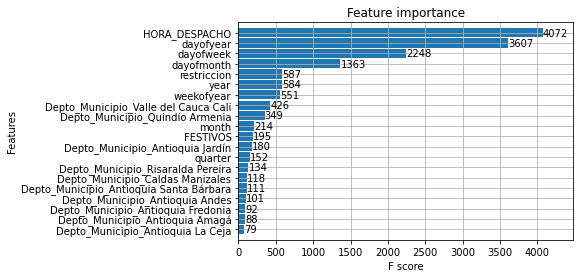

In [97]:
# 3. Evaluate the model

# Feature importance
xgb.plot_importance(model_medellin_s, ax=plt.gca(),max_num_features=20, height = 0.9)

# Metrics
predtrain_medellin_s = model_medellin_s.predict(x_train_medellin_s)
print('R2',r2_score(y_train_medellin_s,predtrain_medellin_s))
print('MSE',mean_squared_error(y_train_medellin_s,predtrain_medellin_s))

predtest_medellin_s=model_medellin_s.predict(x_test_medellin_s)
print('R2',r2_score(y_test_medellin_s,predtest_medellin_s))
print('MSE',mean_squared_error(y_test_medellin_s,predtest_medellin_s))

In [98]:
# Export model for dash / plotly
file_name = "xgb_model_medellin_s.pkl"

# save
pickle.dump(model_medellin_s, open(file_name, "wb"))

### T.T. DE MELGAR

In [99]:
# 1. Data wrangling

# a. Select the terminal
t_melgar=df[df['TERMINAL'] =='T.T. DE MELGAR']

# b. Select the main features for the model
# Features such as type of vehicle or type of service are not considered since they are a consequence of passenger demand
data_melgar=t_melgar.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                     'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_melgar = data_melgar.rename(columns={'sum':'PASAJEROS'})

# c. Create new features

# Holidays
dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

# Features date
data_melgar['FESTIVOS'] =   data_melgar['FECHA_DESPACHO'].isin(dias_festivos20_21)*1
data_melgar['dayofweek'] =  data_melgar['FECHA_DESPACHO'].dt.dayofweek
data_melgar['quarter'] =    data_melgar['FECHA_DESPACHO'].dt.quarter
data_melgar['month'] =      data_melgar['FECHA_DESPACHO'].dt.month
data_melgar['year'] =       data_melgar['FECHA_DESPACHO'].dt.year
data_melgar['dayofyear'] =  data_melgar['FECHA_DESPACHO'].dt.dayofyear
data_melgar['dayofmonth'] = data_melgar['FECHA_DESPACHO'].dt.day
data_melgar['weekofyear'] = data_melgar['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions

data_melgar["restriccion"] = np.where(data_melgar['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_melgar['FECHA_DESPACHO'] > '2020-03-26')&(data_melgar['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_melgar['FECHA_DESPACHO'] >='2020-09-01')&(data_melgar['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_melgar['FECHA_DESPACHO'] >='2021-03-01')&(data_melgar['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destination
data_melgar["Depto_Municipio"]=data_melgar['DEPARTAMENTO_DESTINO']+' '+data_melgar['MUNICIPIO_DESTINO']

<ipython-input-99-2c7331a53070>:24: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_melgar['weekofyear'] = data_melgar['FECHA_DESPACHO'].dt.weekofyear


In [100]:
# 2. Model

# Split data in features and target values
x_melgar=data_melgar.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_melgar=data_melgar['PASAJEROS']

# Encoding categorical data
x_melgar_encoded=pd.get_dummies(x_melgar, columns=["Depto_Municipio"])

# Data training and data test
x_train_melgar, x_test_melgar, y_train_melgar, y_test_melgar = train_test_split(x_melgar_encoded,y_melgar,test_size=0.2,random_state=42)
print(x_train_melgar.shape)
print(x_test_melgar.shape)

# define model
model_melgar = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_melgar.fit(x_train_melgar, y_train_melgar)

(59710, 37)
(14928, 37)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 0.9260971026559619
MSE 79.9941025161875
R2 0.803680599071823
MSE 187.11099273152706


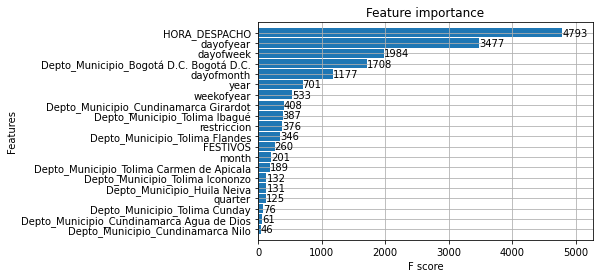

In [101]:
# Evaluate the model

# Feature importance
xgb.plot_importance(model_melgar, ax=plt.gca(),max_num_features=20, height = 0.9)

# Metrics
predtrain_melgar = model_melgar.predict(x_train_melgar)
print('R2',r2_score(y_train_melgar,predtrain_melgar))
print('MSE',mean_squared_error(y_train_melgar,predtrain_melgar))

predtest_melgar=model_melgar.predict(x_test_melgar)
print('R2',r2_score(y_test_melgar,predtest_melgar))
print('MSE',mean_squared_error(y_test_melgar,predtest_melgar))

In [102]:
# Export model for dash / plotly
file_name = "xgb_model_melgar.pkl"

# save
pickle.dump(model_melgar, open(file_name, "wb"))

### T.T. DE MONTERÍA

In [103]:
# 1. Data wrangling

# a. Select the terminal
t_monteria=df[df['TERMINAL'] =='T.T. DE MONTERÍA']

# b. Select the main features for the model
# Features such as type of vehicle or type of service are not considered since they are a consequence of passenger demand
data_monteria=t_monteria.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                     'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_monteria = data_monteria.rename(columns={'sum':'PASAJEROS'})

# c. Create new features

# Holidays
dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

# Features date
data_monteria['FESTIVOS'] =   data_monteria['FECHA_DESPACHO'].isin(dias_festivos20_21)*1
data_monteria['dayofweek'] =  data_monteria['FECHA_DESPACHO'].dt.dayofweek
data_monteria['quarter'] =    data_monteria['FECHA_DESPACHO'].dt.quarter
data_monteria['month'] =      data_monteria['FECHA_DESPACHO'].dt.month
data_monteria['year'] =       data_monteria['FECHA_DESPACHO'].dt.year
data_monteria['dayofyear'] =  data_monteria['FECHA_DESPACHO'].dt.dayofyear
data_monteria['dayofmonth'] = data_monteria['FECHA_DESPACHO'].dt.day
data_monteria['weekofyear'] = data_monteria['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions
data_monteria["restriccion"] = np.where(data_monteria['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_monteria['FECHA_DESPACHO'] > '2020-03-26')&(data_monteria['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_monteria['FECHA_DESPACHO'] >='2020-09-01')&(data_monteria['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_monteria['FECHA_DESPACHO'] >='2021-03-01')&(data_monteria['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destination
data_monteria["Depto_Municipio"]=data_monteria['DEPARTAMENTO_DESTINO']+' '+data_monteria['MUNICIPIO_DESTINO']

<ipython-input-103-3d981736a09b>:24: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_monteria['weekofyear'] = data_monteria['FECHA_DESPACHO'].dt.weekofyear


In [104]:
# 2. Model

# Split data in features and target values
x_monteria=data_monteria.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_monteria=data_monteria['PASAJEROS']

# Encoding categorical data
x_monteria_encoded=pd.get_dummies(x_monteria, columns=["Depto_Municipio"])

# Data training and data test
x_train_monteria, x_test_monteria, y_train_monteria, y_test_monteria = train_test_split(x_monteria_encoded,y_monteria,test_size=0.2,random_state=42)
print(x_train_monteria.shape)
print(x_test_monteria.shape)

# define model
model_monteria = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_monteria.fit(x_train_monteria, y_train_monteria)

(109005, 44)
(27252, 44)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 0.7761073219615684
MSE 106.64974758399698
R2 0.6874790114696178
MSE 139.80891759612373


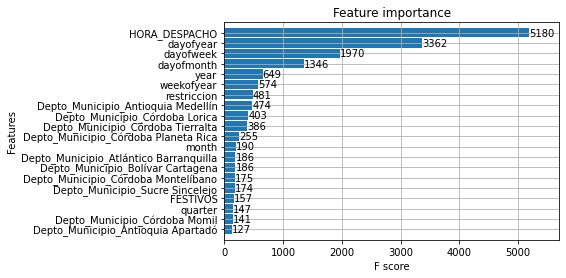

In [105]:
# 3. Evaluate the model

# Feature importance
xgb.plot_importance(model_monteria, ax=plt.gca(),max_num_features=20, height = 0.9)

# Metrics
predtrain_monteria = model_monteria.predict(x_train_monteria)
print('R2',r2_score(y_train_monteria,predtrain_monteria))
print('MSE',mean_squared_error(y_train_monteria,predtrain_monteria))

predtest_monteria=model_monteria.predict(x_test_monteria)
print('R2',r2_score(y_test_monteria,predtest_monteria))
print('MSE',mean_squared_error(y_test_monteria,predtest_monteria))

In [106]:
# Export model for dash / plotly
file_name = "xgb_model_monteria.pkl"

# save
pickle.dump(model_monteria, open(file_name, "wb"))

### T.T. DE NEIVA

In [107]:
# 1. Data wrangling

# a. Select the terminal
t_neiva=df[df['TERMINAL'] =='T.T. DE NEIVA']

# b. Select the main features for the model
# Features such as type of vehicle or type of service are not considered since they are a consequence of passenger demand
data_neiva=t_neiva.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                     'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_neiva = data_neiva.rename(columns={'sum':'PASAJEROS'})

# c. Create new features

# Holidays
dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

# Features date
data_neiva['FESTIVOS'] =   data_neiva['FECHA_DESPACHO'].isin(dias_festivos20_21)*1
data_neiva['dayofweek'] =  data_neiva['FECHA_DESPACHO'].dt.dayofweek
data_neiva['quarter'] =    data_neiva['FECHA_DESPACHO'].dt.quarter
data_neiva['month'] =      data_neiva['FECHA_DESPACHO'].dt.month
data_neiva['year'] =       data_neiva['FECHA_DESPACHO'].dt.year
data_neiva['dayofyear'] =  data_neiva['FECHA_DESPACHO'].dt.dayofyear
data_neiva['dayofmonth'] = data_neiva['FECHA_DESPACHO'].dt.day
data_neiva['weekofyear'] = data_neiva['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions
data_neiva["restriccion"] = np.where(data_neiva['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_neiva['FECHA_DESPACHO'] > '2020-03-26')&(data_neiva['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_neiva['FECHA_DESPACHO'] >='2020-09-01')&(data_neiva['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_neiva['FECHA_DESPACHO'] >='2021-03-01')&(data_neiva['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destination
data_neiva["Depto_Municipio"]=data_neiva['DEPARTAMENTO_DESTINO']+' '+data_neiva['MUNICIPIO_DESTINO']

<ipython-input-107-666e98997822>:24: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_neiva['weekofyear'] = data_neiva['FECHA_DESPACHO'].dt.weekofyear


In [108]:
# 2. Model

# Split data in features and target values
x_neiva=data_neiva.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_neiva=data_neiva['PASAJEROS']

# Encoding categorical data
x_neiva_encoded=pd.get_dummies(x_neiva, columns=["Depto_Municipio"])

# Data training and data test
x_train_neiva, x_test_neiva, y_train_neiva, y_test_neiva = train_test_split(x_neiva_encoded,y_neiva,test_size=0.2,random_state=42)
print(x_train_neiva.shape)
print(x_test_neiva.shape)

# define model
model_neiva = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_neiva.fit(x_train_neiva, y_train_neiva)

(166713, 79)
(41679, 79)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 0.8277432825480667
MSE 78.809326929185
R2 0.7883408516655391
MSE 97.71655500916225


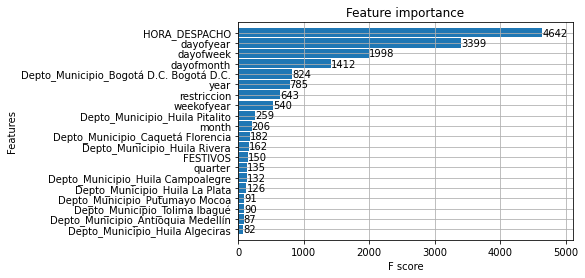

In [109]:
# 3. Evaluate the model

# Feature importance
xgb.plot_importance(model_neiva, ax=plt.gca(),max_num_features=20, height = 0.9)

# Metrics
predtrain_neiva = model_neiva.predict(x_train_neiva)
print('R2',r2_score(y_train_neiva,predtrain_neiva))
print('MSE',mean_squared_error(y_train_neiva,predtrain_neiva))

predtest_neiva=model_neiva.predict(x_test_neiva)
print('R2',r2_score(y_test_neiva,predtest_neiva))
print('MSE',mean_squared_error(y_test_neiva,predtest_neiva))

In [110]:
# Export model for dash / plotly
file_name = "xgb_model_neiva.pkl"

# save
pickle.dump(model_neiva, open(file_name, "wb"))

### T.T. DE PASTO

In [111]:
# 1. Data wrangling

# a. Select the terminal
t_pasto=df[df['TERMINAL'] =='T.T. DE PASTO']

# b. Select the main features for the model
# Features such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_pasto=t_pasto.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                     'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_pasto = data_pasto.rename(columns={'sum':'PASAJEROS'})

# c. Create new features

# Holidays
dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

# Features date
data_pasto['FESTIVOS'] =   data_pasto['FECHA_DESPACHO'].isin(dias_festivos20_21)*1
data_pasto['dayofweek'] =  data_pasto['FECHA_DESPACHO'].dt.dayofweek
data_pasto['quarter'] =    data_pasto['FECHA_DESPACHO'].dt.quarter
data_pasto['month'] =      data_pasto['FECHA_DESPACHO'].dt.month
data_pasto['year'] =       data_pasto['FECHA_DESPACHO'].dt.year
data_pasto['dayofyear'] =  data_pasto['FECHA_DESPACHO'].dt.dayofyear
data_pasto['dayofmonth'] = data_pasto['FECHA_DESPACHO'].dt.day
data_pasto['weekofyear'] = data_pasto['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions

data_pasto["restriccion"] = np.where(data_pasto['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_pasto['FECHA_DESPACHO'] > '2020-03-26')&(data_pasto['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_pasto['FECHA_DESPACHO'] >='2020-09-01')&(data_pasto['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_pasto['FECHA_DESPACHO'] >='2021-03-01')&(data_pasto['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destination
data_pasto["Depto_Municipio"]=data_pasto['DEPARTAMENTO_DESTINO']+' '+data_pasto['MUNICIPIO_DESTINO']

<ipython-input-111-d91df64d8313>:24: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_pasto['weekofyear'] = data_pasto['FECHA_DESPACHO'].dt.weekofyear


In [112]:
# 2. Model

# Split data in features and target values
x_pasto=data_pasto.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_pasto=data_pasto['PASAJEROS']

# Encoding categorical data
x_pasto_encoded=pd.get_dummies(x_pasto, columns=["Depto_Municipio"])

# Data training and data test
x_train_pasto, x_test_pasto, y_train_pasto, y_test_pasto = train_test_split(x_pasto_encoded,y_pasto,test_size=0.2,random_state=42)
print(x_train_pasto.shape)
print(x_test_pasto.shape)

# define model
model_pasto = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_pasto.fit(x_train_pasto, y_train_pasto)

(123959, 71)
(30990, 71)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 0.8583789916955872
MSE 91.47554864547827
R2 0.8074842604648306
MSE 120.08605492887725


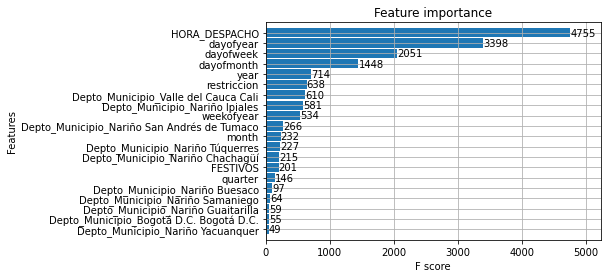

In [113]:
# 3. Evaluate the model

# Feature importance
xgb.plot_importance(model_pasto, ax=plt.gca(),max_num_features=20, height = 0.9)

# Metrics
predtrain_pasto = model_pasto.predict(x_train_pasto)
print('R2',r2_score(y_train_pasto,predtrain_pasto))
print('MSE',mean_squared_error(y_train_pasto,predtrain_pasto))

predtest_pasto=model_pasto.predict(x_test_pasto)
print('R2',r2_score(y_test_pasto,predtest_pasto))
print('MSE',mean_squared_error(y_test_pasto,predtest_pasto))

In [114]:
# Export model for dash / plotly
file_name = "xgb_model_pasto.pkl"

# save
pickle.dump(model_pasto, open(file_name, "wb"))

### T.T. DE PEREIRA

In [115]:
# 1. Data wrangling

# a. Select the terminal
t_pereira=df[df['TERMINAL'] =='T.T. DE PEREIRA']

# b. Select the main features for the model
# Features such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_pereira=t_pereira.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                     'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_pereira = data_pereira.rename(columns={'sum':'PASAJEROS'})

# c. Create new features

# Holidays
dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

# Features date
data_pereira['FESTIVOS'] =   data_pereira['FECHA_DESPACHO'].isin(dias_festivos20_21)*1
data_pereira['dayofweek'] =  data_pereira['FECHA_DESPACHO'].dt.dayofweek
data_pereira['quarter'] =    data_pereira['FECHA_DESPACHO'].dt.quarter
data_pereira['month'] =      data_pereira['FECHA_DESPACHO'].dt.month
data_pereira['year'] =       data_pereira['FECHA_DESPACHO'].dt.year
data_pereira['dayofyear'] =  data_pereira['FECHA_DESPACHO'].dt.dayofyear
data_pereira['dayofmonth'] = data_pereira['FECHA_DESPACHO'].dt.day
data_pereira['weekofyear'] = data_pereira['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions
data_pereira["restriccion"] = np.where(data_pereira['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_pereira['FECHA_DESPACHO'] > '2020-03-26')&(data_pereira['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_pereira['FECHA_DESPACHO'] >='2020-09-01')&(data_pereira['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_pereira['FECHA_DESPACHO'] >='2021-03-01')&(data_pereira['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destination
data_pereira["Depto_Municipio"]=data_pereira['DEPARTAMENTO_DESTINO']+' '+data_pereira['MUNICIPIO_DESTINO']

<ipython-input-115-a55519eb7ce5>:24: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_pereira['weekofyear'] = data_pereira['FECHA_DESPACHO'].dt.weekofyear


In [116]:
# 2. Model

# Split data in features and target values
x_pereira=data_pereira.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_pereira=data_pereira['PASAJEROS']

# Encoding categorical data
x_pereira_encoded=pd.get_dummies(x_pereira, columns=["Depto_Municipio"])

# Data training and data test
x_train_pereira, x_test_pereira, y_train_pereira, y_test_pereira = train_test_split(x_pereira_encoded,y_pereira,test_size=0.2,random_state=42)
print(x_train_pereira.shape)
print(x_test_pereira.shape)

# define model
model_pereira = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_pereira.fit(x_train_pereira, y_train_pereira)

(160344, 54)
(40086, 54)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 0.9025416681140387
MSE 222.34175247778023
R2 0.8689715283503205
MSE 293.47149547067875


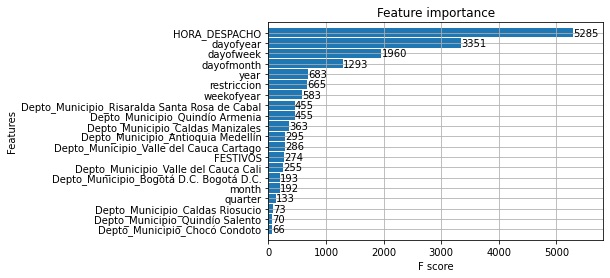

In [117]:
# 3. Evaluate the model

# Feature importance
xgb.plot_importance(model_pereira, ax=plt.gca(),max_num_features=20, height = 0.9)

# Metrics
predtrain_pereira = model_pereira.predict(x_train_pereira)
print('R2',r2_score(y_train_pereira,predtrain_pereira))
print('MSE',mean_squared_error(y_train_pereira,predtrain_pereira))

predtest_pereira=model_pereira.predict(x_test_pereira)
print('R2',r2_score(y_test_pereira,predtest_pereira))
print('MSE',mean_squared_error(y_test_pereira,predtest_pereira))

In [118]:
# Export model for dash / plotly
file_name = "xgb_model_pereira.pkl"

# save
pickle.dump(model_pereira, open(file_name, "wb"))

### T.T. DE PITALITO

In [150]:
# 1. Data wrangling

# a. selec the terminal

t_pitalito=df[df['TERMINAL'] =='T.T. DE PITALITO']

# b. Select the main features for the model
# Features such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_pitalito=t_pitalito.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                     'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_pitalito = data_pitalito.rename(columns={'sum':'PASAJEROS'})

# c. Create new features

# Holidays

dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

#Date features
data_pitalito['FESTIVOS'] =   data_pitalito['FECHA_DESPACHO'].isin(dias_festivos20_21)*1
data_pitalito['dayofweek'] =  data_pitalito['FECHA_DESPACHO'].dt.dayofweek
data_pitalito['quarter'] =    data_pitalito['FECHA_DESPACHO'].dt.quarter
data_pitalito['month'] =      data_pitalito['FECHA_DESPACHO'].dt.month
data_pitalito['year'] =       data_pitalito['FECHA_DESPACHO'].dt.year
data_pitalito['dayofyear'] =  data_pitalito['FECHA_DESPACHO'].dt.dayofyear
data_pitalito['dayofmonth'] = data_pitalito['FECHA_DESPACHO'].dt.day
data_pitalito['weekofyear'] = data_pitalito['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions

data_pitalito["restriccion"] = np.where(data_pitalito['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_pitalito['FECHA_DESPACHO'] > '2020-03-26')&(data_pitalito['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_pitalito['FECHA_DESPACHO'] >='2020-09-01')&(data_pitalito['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_pitalito['FECHA_DESPACHO'] >='2021-03-01')&(data_pitalito['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destination

data_pitalito["Depto_Municipio"]=data_pitalito['DEPARTAMENTO_DESTINO']+' '+data_pitalito['MUNICIPIO_DESTINO']

<ipython-input-150-31ec8b782483>:24: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_pitalito['weekofyear'] = data_pitalito['FECHA_DESPACHO'].dt.weekofyear


In [152]:
#2. Model

# Split data in features and target values
x_pitalito=data_pitalito.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_pitalito=data_pitalito['PASAJEROS']

# Encoding categorical data
x_pitalito_encoded=pd.get_dummies(x_pitalito, columns=["Depto_Municipio"])

# Data training and data test
x_train_pitalito, x_test_pitalito, y_train_pitalito, y_test_pitalito = train_test_split(x_pitalito_encoded,y_pitalito,test_size=0.2,random_state=42)
print(x_train_pitalito.shape)
print(x_test_pitalito.shape)

# define model
model_pitalito = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_pitalito.fit(x_train_pitalito, y_train_pitalito)

(110781, 43)
(27696, 43)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 0.7743041566971038
MSE 71.15814414448198
R2 0.6982140779757027
MSE 94.79723068784496


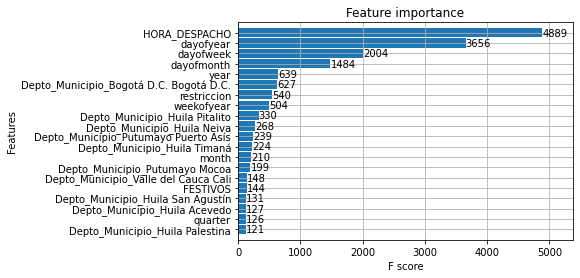

In [153]:
# Evaluate the model

# Feature importance
xgb.plot_importance(model_pitalito, ax=plt.gca(),max_num_features=20, height = 0.9)

# Metrics
predtrain_pitalito = model_pitalito.predict(x_train_pitalito)
print('R2',r2_score(y_train_pitalito,predtrain_pitalito))
print('MSE',mean_squared_error(y_train_pitalito,predtrain_pitalito))

predtest_pitalito=model_pitalito.predict(x_test_pitalito)
print('R2',r2_score(y_test_pitalito,predtest_pitalito))
print('MSE',mean_squared_error(y_test_pitalito,predtest_pitalito))

In [154]:
# Export model for dash / plotly
file_name = "xgb_model_pitalito.pkl"

# save
pickle.dump(model_pitalito, open(file_name, "wb"))

### T.T. DE POPAYAN

In [155]:
# 1 Data wrangling

# a. Select the terminal
t_popayan=df[df['TERMINAL'] =='T.T. DE POPAYÁN']

# b. Select the main features for the model
# Features such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_popayan=t_popayan.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                     'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_popayan = data_popayan.rename(columns={'sum':'PASAJEROS'})

#Create new features

#Holidays
dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

#Features date
data_popayan['FESTIVOS'] =   data_popayan['FECHA_DESPACHO'].isin(dias_festivos20_21)*1
data_popayan['dayofweek'] =  data_popayan['FECHA_DESPACHO'].dt.dayofweek
data_popayan['quarter'] =    data_popayan['FECHA_DESPACHO'].dt.quarter
data_popayan['month'] =      data_popayan['FECHA_DESPACHO'].dt.month
data_popayan['year'] =       data_popayan['FECHA_DESPACHO'].dt.year
data_popayan['dayofyear'] =  data_popayan['FECHA_DESPACHO'].dt.dayofyear
data_popayan['dayofmonth'] = data_popayan['FECHA_DESPACHO'].dt.day
data_popayan['weekofyear'] = data_popayan['FECHA_DESPACHO'].dt.weekofyear

# Mobility restriction
data_popayan["restriccion"] = np.where(data_popayan['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_popayan['FECHA_DESPACHO'] > '2020-03-26')&(data_popayan['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_popayan['FECHA_DESPACHO'] >='2020-09-01')&(data_popayan['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_popayan['FECHA_DESPACHO'] >='2021-03-01')&(data_popayan['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destination
data_popayan["Depto_Municipio"]=data_popayan['DEPARTAMENTO_DESTINO']+' '+data_popayan['MUNICIPIO_DESTINO']

<ipython-input-155-4d43069ceb0c>:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_popayan['weekofyear'] = data_popayan['FECHA_DESPACHO'].dt.weekofyear


In [156]:
# 2 Model

# Split data in features and target values
x_popayan=data_popayan.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_popayan=data_popayan['PASAJEROS']

# Encoding categorical data
x_popayan_encoded=pd.get_dummies(x_popayan, columns=["Depto_Municipio"])

# Data training and data test
x_train_popayan, x_test_popayan, y_train_popayan, y_test_popayan = train_test_split(x_popayan_encoded,y_popayan,test_size=0.2,random_state=42)
print(x_train_popayan.shape)
print(x_test_popayan.shape)

# define model
model_popayan = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_popayan.fit(x_train_popayan, y_train_popayan)

(111484, 66)
(27872, 66)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 0.8907372851380242
MSE 250.5793243894315
R2 0.8419808007823576
MSE 366.22573481641217


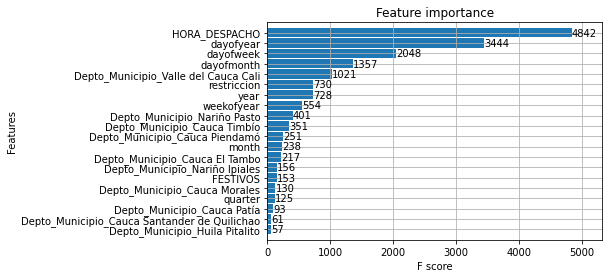

In [158]:
# 3 Evaluate the model

# Feature importance
xgb.plot_importance(model_popayan, ax=plt.gca(),max_num_features=20, height = 0.9)

#Metrics
predtrain_popayan = model_popayan.predict(x_train_popayan)
print('R2',r2_score(y_train_popayan,predtrain_popayan))
print('MSE',mean_squared_error(y_train_popayan,predtrain_popayan))

predtest_popayan=model_popayan.predict(x_test_popayan)
print('R2',r2_score(y_test_popayan,predtest_popayan))
print('MSE',mean_squared_error(y_test_popayan,predtest_popayan))

In [159]:
# Export model for dash / plotly
file_name = "xgb_model_popayan.pkl"

# save
pickle.dump(model_popayan, open(file_name, "wb"))

### T.T. DE SANTA MARTA

In [160]:
# 1 Data Wrangking

# a. Selec the terminal

t_smarta=df[df['TERMINAL'] =='T.T. DE SANTA MARTA']

# b. Select the main features for the model
# Features such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_smarta=t_smarta.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                     'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_smarta = data_smarta.rename(columns={'sum':'PASAJEROS'})

#Create new features

#Holidays
dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']
# Data features
data_smarta['FESTIVOS'] =   data_smarta['FECHA_DESPACHO'].isin(dias_festivos20_21)*1
data_smarta['dayofweek'] =  data_smarta['FECHA_DESPACHO'].dt.dayofweek
data_smarta['quarter'] =    data_smarta['FECHA_DESPACHO'].dt.quarter
data_smarta['month'] =      data_smarta['FECHA_DESPACHO'].dt.month
data_smarta['year'] =       data_smarta['FECHA_DESPACHO'].dt.year
data_smarta['dayofyear'] =  data_smarta['FECHA_DESPACHO'].dt.dayofyear
data_smarta['dayofmonth'] = data_smarta['FECHA_DESPACHO'].dt.day
data_smarta['weekofyear'] = data_smarta['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions

data_smarta["restriccion"] = np.where(data_smarta['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_smarta['FECHA_DESPACHO'] > '2020-03-26')&(data_smarta['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_smarta['FECHA_DESPACHO'] >='2020-09-01')&(data_smarta['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_smarta['FECHA_DESPACHO'] >='2021-03-01')&(data_smarta['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destination

data_smarta["Depto_Municipio"]=data_smarta['DEPARTAMENTO_DESTINO']+' '+data_smarta['MUNICIPIO_DESTINO']

<ipython-input-160-9e1fe674e469>:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_smarta['weekofyear'] = data_smarta['FECHA_DESPACHO'].dt.weekofyear


In [161]:
# 2 Model

# Split data in features and target values
x_smarta=data_smarta.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_smarta=data_smarta['PASAJEROS']

# Encoding categorical data
x_smarta_encoded=pd.get_dummies(x_smarta, columns=["Depto_Municipio"])

# Data training and data test
x_train_smarta, x_test_smarta, y_train_smarta, y_test_smarta = train_test_split(x_smarta_encoded,y_smarta,test_size=0.2,random_state=42)
print(x_train_smarta.shape)
print(x_test_smarta.shape)

# define model
model_smarta = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_smarta.fit(x_train_smarta, y_train_smarta)

(55732, 26)
(13934, 26)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 0.7892111443782978
MSE 205.11452352471107
R2 0.6804552434735303
MSE 335.9075971888845


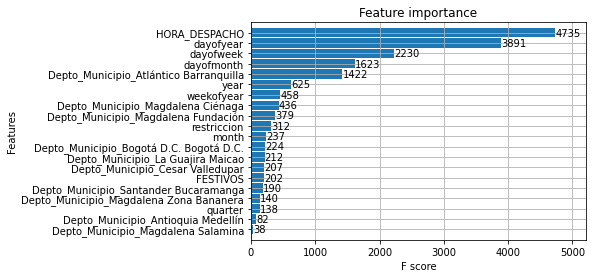

In [162]:
# 3 Evaluate the model

# Feature importance
%matplotlib inline
xgb.plot_importance(model_smarta, ax=plt.gca(),max_num_features=20, height = 0.9)

#Metrics
predtrain_smarta = model_smarta.predict(x_train_smarta)
print('R2',r2_score(y_train_smarta,predtrain_smarta))
print('MSE',mean_squared_error(y_train_smarta,predtrain_smarta))

predtest_smarta=model_smarta.predict(x_test_smarta)
print('R2',r2_score(y_test_smarta,predtest_smarta))
print('MSE',mean_squared_error(y_test_smarta,predtest_smarta))

In [163]:
# Export model for dash / plotly
file_name = "xgb_model_smarta.pkl"

# save
pickle.dump(model_smarta, open(file_name, "wb"))

### T.T. DE SOGAMOSO

In [164]:
# 1 Data wrangling

# a Select the terminal
t_sogamoso=df[df['TERMINAL'] =='T.T. DE SOGAMOSO']

# b. Select the main features for the model
# Features such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_sogamoso=t_sogamoso.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                     'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_sogamoso = data_sogamoso.rename(columns={'sum':'PASAJEROS'})

#Create new features
#Holidays
dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']
#Features date
data_sogamoso['FESTIVOS'] =   data_sogamoso['FECHA_DESPACHO'].isin(dias_festivos20_21)*1
data_sogamoso['dayofweek'] =  data_sogamoso['FECHA_DESPACHO'].dt.dayofweek
data_sogamoso['quarter'] =    data_sogamoso['FECHA_DESPACHO'].dt.quarter
data_sogamoso['month'] =      data_sogamoso['FECHA_DESPACHO'].dt.month
data_sogamoso['year'] =       data_sogamoso['FECHA_DESPACHO'].dt.year
data_sogamoso['dayofyear'] =  data_sogamoso['FECHA_DESPACHO'].dt.dayofyear
data_sogamoso['dayofmonth'] = data_sogamoso['FECHA_DESPACHO'].dt.day
data_sogamoso['weekofyear'] = data_sogamoso['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions
data_sogamoso["restriccion"] = np.where(data_sogamoso['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_sogamoso['FECHA_DESPACHO'] > '2020-03-26')&(data_sogamoso['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_sogamoso['FECHA_DESPACHO'] >='2020-09-01')&(data_sogamoso['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_sogamoso['FECHA_DESPACHO'] >='2021-03-01')&(data_sogamoso['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destination

data_sogamoso["Depto_Municipio"]=data_sogamoso['DEPARTAMENTO_DESTINO']+' '+data_sogamoso['MUNICIPIO_DESTINO']

<ipython-input-164-bb714ce48125>:27: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_sogamoso['weekofyear'] = data_sogamoso['FECHA_DESPACHO'].dt.weekofyear


In [165]:
# 2 Model

# Split data in features and target values
x_sogamoso=data_sogamoso.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_sogamoso=data_sogamoso['PASAJEROS']

# Encoding categorical data
x_sogamoso_encoded=pd.get_dummies(x_sogamoso, columns=["Depto_Municipio"])

# Data training and data test
x_train_sogamoso, x_test_sogamoso, y_train_sogamoso, y_test_sogamoso = train_test_split(x_sogamoso_encoded,y_sogamoso,test_size=0.2,random_state=42)
print(x_train_sogamoso.shape)
print(x_test_sogamoso.shape)

# define model
model_sogamoso = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_sogamoso.fit(x_train_sogamoso, y_train_sogamoso)

(91432, 37)
(22858, 37)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 0.9204299951308634
MSE 103.12172052089021
R2 0.8742053918201922
MSE 176.6242939834429


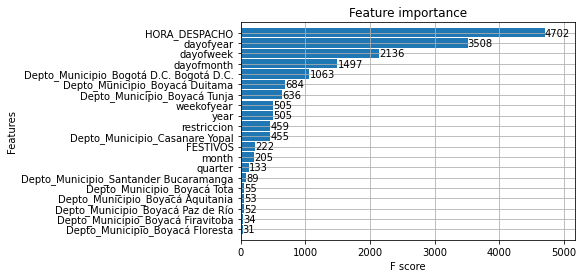

In [166]:
# 3 Evaluate the model

#Feature importance
%matplotlib inline
xgb.plot_importance(model_sogamoso, ax=plt.gca(),max_num_features=20, height = 0.9)

#Metrics
predtrain_sogamoso = model_sogamoso.predict(x_train_sogamoso)
print('R2',r2_score(y_train_sogamoso,predtrain_sogamoso))
print('MSE',mean_squared_error(y_train_sogamoso,predtrain_sogamoso))

predtest_sogamoso=model_sogamoso.predict(x_test_sogamoso)
print('R2',r2_score(y_test_sogamoso,predtest_sogamoso))
print('MSE',mean_squared_error(y_test_sogamoso,predtest_sogamoso))

In [167]:
# Export model for dash / plotly
file_name = "xgb_model_sogamoso.pkl"

# save
pickle.dump(model_sogamoso, open(file_name, "wb"))

### T.T. DE TULÚA

In [168]:
# 1 Data Wrangling

# a. Select the terminal
t_tulua=df[df['TERMINAL'] =='T.T. DE TULÚA']

# b. Select the main features for the model
# Features such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_tulua=t_tulua.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                     'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_tulua = data_tulua.rename(columns={'sum':'PASAJEROS'})

# c. Create new features

#Holidays
dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']
#Features date
data_tulua['FESTIVOS'] =   data_tulua['FECHA_DESPACHO'].isin(dias_festivos20_21)*1
data_tulua['dayofweek'] =  data_tulua['FECHA_DESPACHO'].dt.dayofweek
data_tulua['quarter'] =    data_tulua['FECHA_DESPACHO'].dt.quarter
data_tulua['month'] =      data_tulua['FECHA_DESPACHO'].dt.month
data_tulua['year'] =       data_tulua['FECHA_DESPACHO'].dt.year
data_tulua['dayofyear'] =  data_tulua['FECHA_DESPACHO'].dt.dayofyear
data_tulua['dayofmonth'] = data_tulua['FECHA_DESPACHO'].dt.day
data_tulua['weekofyear'] = data_tulua['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions
data_tulua["restriccion"] = np.where(data_tulua['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_tulua['FECHA_DESPACHO'] > '2020-03-26')&(data_tulua['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_tulua['FECHA_DESPACHO'] >='2020-09-01')&(data_tulua['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_tulua['FECHA_DESPACHO'] >='2021-03-01')&(data_tulua['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destination
data_tulua["Depto_Municipio"]=data_tulua['DEPARTAMENTO_DESTINO']+' '+data_tulua['MUNICIPIO_DESTINO']

<ipython-input-168-ef264edb45bc>:27: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_tulua['weekofyear'] = data_tulua['FECHA_DESPACHO'].dt.weekofyear


In [169]:
# 2 Model

# Split data in features and target values
x_tulua=data_tulua.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_tulua=data_tulua['PASAJEROS']

# Encoding categorical data
x_tulua_encoded=pd.get_dummies(x_tulua, columns=["Depto_Municipio"])

# Data training and data test
x_train_tulua, x_test_tulua, y_train_tulua, y_test_tulua = train_test_split(x_tulua_encoded,y_tulua,test_size=0.2,random_state=42)
print(x_train_tulua.shape)
print(x_test_tulua.shape)

# define model
model_tulua = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_tulua.fit(x_train_tulua, y_train_tulua)

(104651, 43)
(26163, 43)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 0.8986311911117801
MSE 157.15009378669598
R2 0.860095037638736
MSE 225.51544824922854


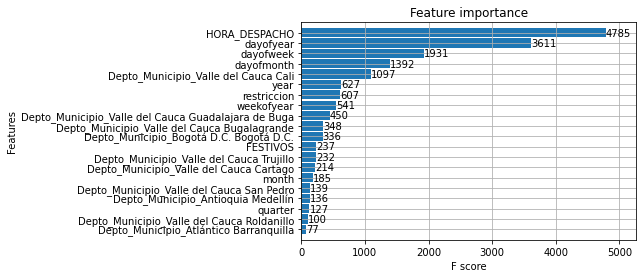

In [170]:
# 3 Evaluate the model

# Feature importance
%matplotlib inline
xgb.plot_importance(model_tulua, ax=plt.gca(),max_num_features=20, height = 0.9)

# Metrics
predtrain_tulua = model_tulua.predict(x_train_tulua)
print('R2',r2_score(y_train_tulua,predtrain_tulua))
print('MSE',mean_squared_error(y_train_tulua,predtrain_tulua))

predtest_tulua=model_tulua.predict(x_test_tulua)
print('R2',r2_score(y_test_tulua,predtest_tulua))
print('MSE',mean_squared_error(y_test_tulua,predtest_tulua))

In [171]:
# Export model for dash / plotly
file_name = "xgb_model_tulua.pkl"

# save
pickle.dump(model_tulua, open(file_name, "wb"))

### T.T. DE TUNJA

In [172]:
# 1 Data wrangling

# a. Select the terminal
t_tunja=df[df['TERMINAL'] =='T.T. DE TUNJA']

# b. Select the main features for the model
# Features such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_tunja=t_tunja.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                     'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_tunja = data_tunja.rename(columns={'sum':'PASAJEROS'})

# c. Create new features
# Holidays
dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']
#Features date
data_tunja['FESTIVOS'] =   data_tunja['FECHA_DESPACHO'].isin(dias_festivos20_21)*1
data_tunja['dayofweek'] =  data_tunja['FECHA_DESPACHO'].dt.dayofweek
data_tunja['quarter'] =    data_tunja['FECHA_DESPACHO'].dt.quarter
data_tunja['month'] =      data_tunja['FECHA_DESPACHO'].dt.month
data_tunja['year'] =       data_tunja['FECHA_DESPACHO'].dt.year
data_tunja['dayofyear'] =  data_tunja['FECHA_DESPACHO'].dt.dayofyear
data_tunja['dayofmonth'] = data_tunja['FECHA_DESPACHO'].dt.day
data_tunja['weekofyear'] = data_tunja['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions
data_tunja["restriccion"] = np.where(data_tunja['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_tunja['FECHA_DESPACHO'] > '2020-03-26')&(data_tunja['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_tunja['FECHA_DESPACHO'] >='2020-09-01')&(data_tunja['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_tunja['FECHA_DESPACHO'] >='2021-03-01')&(data_tunja['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destinations
data_tunja["Depto_Municipio"]=data_tunja['DEPARTAMENTO_DESTINO']+' '+data_tunja['MUNICIPIO_DESTINO']

<ipython-input-172-78a4fcc9a62b>:27: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_tunja['weekofyear'] = data_tunja['FECHA_DESPACHO'].dt.weekofyear


In [173]:
# 2 Model

# Split data in features and target values
x_tunja=data_tunja.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_tunja=data_tunja['PASAJEROS']

# Encoding categorical data
x_tunja_encoded=pd.get_dummies(x_tunja, columns=["Depto_Municipio"])

# Data training and data test
x_train_tunja, x_test_tunja, y_train_tunja, y_test_tunja = train_test_split(x_tunja_encoded,y_tunja,test_size=0.2,random_state=42)
print(x_train_tunja.shape)
print(x_test_tunja.shape)

# define model
model_tunja = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_tunja.fit(x_train_tunja, y_train_tunja)

(116359, 91)
(29090, 91)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 0.7828435485122712
MSE 71.05513037794033
R2 0.6903626592976932
MSE 97.47429982203823


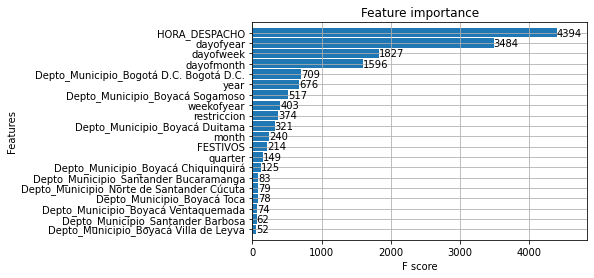

In [174]:
# 3 Evaluate the model

# Feature importance 
%matplotlib inline
xgb.plot_importance(model_tunja, ax=plt.gca(),max_num_features=20, height = 0.9)

#Metrics
predtrain_tunja = model_tunja.predict(x_train_tunja)
print('R2',r2_score(y_train_tunja,predtrain_tunja))
print('MSE',mean_squared_error(y_train_tunja,predtrain_tunja))

predtest_tunja=model_tunja.predict(x_test_tunja)
print('R2',r2_score(y_test_tunja,predtest_tunja))
print('MSE',mean_squared_error(y_test_tunja,predtest_tunja))

In [175]:
# Export model for dash / plotly
file_name = "xgb_model_tunja.pkl"

# save
pickle.dump(model_tunja, open(file_name, "wb"))

### T.T. DE VALLEDUPAR

In [176]:
# 1 Data wrangling

# a Select the terminal
t_vdupar=df[df['TERMINAL'] =='T.T. DE VALLEDUPAR']

# b. Select the main features for the model
# Features such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_vdupar=t_vdupar.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                     'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_vdupar = data_vdupar.rename(columns={'sum':'PASAJEROS'})

# c. Create new features
#Holidays
dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']
#Features date
data_vdupar['FESTIVOS'] =   data_vdupar['FECHA_DESPACHO'].isin(dias_festivos20_21)*1
data_vdupar['dayofweek'] =  data_vdupar['FECHA_DESPACHO'].dt.dayofweek
data_vdupar['quarter'] =    data_vdupar['FECHA_DESPACHO'].dt.quarter
data_vdupar['month'] =      data_vdupar['FECHA_DESPACHO'].dt.month
data_vdupar['year'] =       data_vdupar['FECHA_DESPACHO'].dt.year
data_vdupar['dayofyear'] =  data_vdupar['FECHA_DESPACHO'].dt.dayofyear
data_vdupar['dayofmonth'] = data_vdupar['FECHA_DESPACHO'].dt.day
data_vdupar['weekofyear'] = data_vdupar['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions
data_vdupar["restriccion"] = np.where(data_vdupar['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_vdupar['FECHA_DESPACHO'] > '2020-03-26')&(data_vdupar['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_vdupar['FECHA_DESPACHO'] >='2020-09-01')&(data_vdupar['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_vdupar['FECHA_DESPACHO'] >='2021-03-01')&(data_vdupar['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destinations
data_vdupar["Depto_Municipio"]=data_vdupar['DEPARTAMENTO_DESTINO']+' '+data_vdupar['MUNICIPIO_DESTINO']

<ipython-input-176-a731a124a13a>:27: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_vdupar['weekofyear'] = data_vdupar['FECHA_DESPACHO'].dt.weekofyear


In [177]:
# 2 Model

# Split data in features and target values
x_vdupar=data_vdupar.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_vdupar=data_vdupar['PASAJEROS']

# Encoding categorical data
x_vdupar_encoded=pd.get_dummies(x_vdupar, columns=["Depto_Municipio"])

# Data training and data test
x_train_vdupar, x_test_vdupar, y_train_vdupar, y_test_vdupar = train_test_split(x_vdupar_encoded,y_vdupar,test_size=0.2,random_state=42)
print(x_train_vdupar.shape)
print(x_test_vdupar.shape)

# define model
model_vdupar = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_vdupar.fit(x_train_vdupar, y_train_vdupar)

(81986, 43)
(20497, 43)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 0.7425219990124396
MSE 86.9138762535261
R2 0.6078910828871485
MSE 127.99179535606933


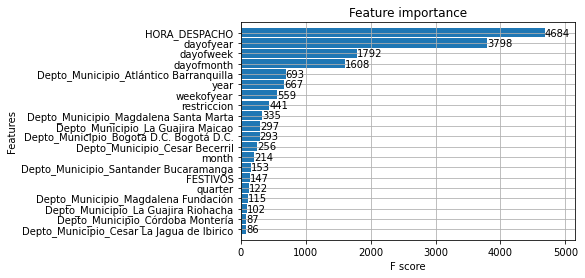

In [178]:
# 3 Evaluate the model

#Feature importance
%matplotlib inline
xgb.plot_importance(model_vdupar, ax=plt.gca(),max_num_features=20, height = 0.9)

#Metrics
predtrain_vdupar = model_vdupar.predict(x_train_vdupar)
print('R2',r2_score(y_train_vdupar,predtrain_vdupar))
print('MSE',mean_squared_error(y_train_vdupar,predtrain_vdupar))

predtest_vdupar=model_vdupar.predict(x_test_vdupar)
print('R2',r2_score(y_test_vdupar,predtest_vdupar))
print('MSE',mean_squared_error(y_test_vdupar,predtest_vdupar))

In [179]:
# Export model for dash / plotly
file_name = "xgb_model_vdupar.pkl"

# save
pickle.dump(model_vdupar, open(file_name, "wb"))

### T.T. DE VILLAGARZÓN

In [180]:
# 1 Data wrangling

# a Select the terminal
t_vgarzon=df[df['TERMINAL'] =='T.T. DE VILLAGARZÓN']

#Se descartan variables tales como tipo de vehiculo o tipo de servicio ya que son consecuencia de la demanda de pasajeros y se agrupa

data_vgarzon=t_vgarzon.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                     'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_vgarzon = data_vgarzon.rename(columns={'sum':'PASAJEROS'})

# c. Create new features
#Holidays
dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']
#Features date
data_vgarzon['FESTIVOS'] =   data_vgarzon['FECHA_DESPACHO'].isin(dias_festivos20_21)*1
data_vgarzon['dayofweek'] =  data_vgarzon['FECHA_DESPACHO'].dt.dayofweek
data_vgarzon['quarter'] =    data_vgarzon['FECHA_DESPACHO'].dt.quarter
data_vgarzon['month'] =      data_vgarzon['FECHA_DESPACHO'].dt.month
data_vgarzon['year'] =       data_vgarzon['FECHA_DESPACHO'].dt.year
data_vgarzon['dayofyear'] =  data_vgarzon['FECHA_DESPACHO'].dt.dayofyear
data_vgarzon['dayofmonth'] = data_vgarzon['FECHA_DESPACHO'].dt.day
data_vgarzon['weekofyear'] = data_vgarzon['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions
data_vgarzon["restriccion"] = np.where(data_vgarzon['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_vgarzon['FECHA_DESPACHO'] > '2020-03-26')&(data_vgarzon['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_vgarzon['FECHA_DESPACHO'] >='2020-09-01')&(data_vgarzon['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_vgarzon['FECHA_DESPACHO'] >='2021-03-01')&(data_vgarzon['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destination
data_vgarzon["Depto_Municipio"]=data_vgarzon['DEPARTAMENTO_DESTINO']+' '+data_vgarzon['MUNICIPIO_DESTINO']

<ipython-input-180-c13a655d301b>:27: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_vgarzon['weekofyear'] = data_vgarzon['FECHA_DESPACHO'].dt.weekofyear


In [181]:
# 2 Model

# Split data in features and target values
x_vgarzon=data_vgarzon.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_vgarzon=data_vgarzon['PASAJEROS']

# Encoding categorical data
x_vgarzon_encoded=pd.get_dummies(x_vgarzon, columns=["Depto_Municipio"])

# Data training and data test
x_train_vgarzon, x_test_vgarzon, y_train_vgarzon, y_test_vgarzon = train_test_split(x_vgarzon_encoded,y_vgarzon,test_size=0.2,random_state=42)
print(x_train_vgarzon.shape)
print(x_test_vgarzon.shape)

# define model
model_vgarzon = XGBRegressor(objective ='reg:squarederror', n_estimators = 300, seed = 123)

# fit model
model_vgarzon.fit(x_train_vgarzon, y_train_vgarzon)

(51392, 29)
(12849, 29)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 0.8158596402372413
MSE 36.957844378473
R2 0.7313569483519793
MSE 55.25905501138317


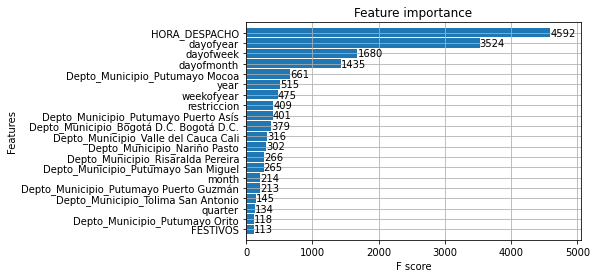

In [182]:
# 3 Evaluate the model

# Feature importance
%matplotlib inline
xgb.plot_importance(model_vgarzon, ax=plt.gca(),max_num_features=20, height = 0.9)

# Metrics
predtrain_vgarzon = model_vgarzon.predict(x_train_vgarzon)
print('R2',r2_score(y_train_vgarzon,predtrain_vgarzon))
print('MSE',mean_squared_error(y_train_vgarzon,predtrain_vgarzon))

predtest_vgarzon=model_vgarzon.predict(x_test_vgarzon)
print('R2',r2_score(y_test_vgarzon,predtest_vgarzon))
print('MSE',mean_squared_error(y_test_vgarzon,predtest_vgarzon))

In [183]:
# Export model for dash / plotly
file_name = "xgb_model_vgarzon.pkl"

# save
pickle.dump(model_vgarzon, open(file_name, "wb"))

## OVERFITTING TREATMENT

For terminals where an overfitting is identified, the following procedure is performed:

a. Test data is increased by reducing the training partition to 70% and 30% for tests.
b. The optimal level of the hyperparameters is searched through the RandomizedSearchCV algorithm.

The rule adopted to define when this procedure is applied was that the difference between the r2_score between training and test was equal to or greater than 0.15

In [30]:
## Params definition
params = {"learning_rate": [0.1,0.01,0.05, 0.10, 0.15, 0.20, 0.25, 0.30], # Giving some ones parameters to perform on randomized search and obtain the better combination
         "max_depth": [3, 4, 5, 6, 8, 10, 12, 15],
         "min_child_weight": [1, 3, 5, 7],
         "gamma": [0.0, 0.1, 0.2, 0.3, 0.4],
         "colsample_bytree": [0.3, 0.4, 0.5, 0.7],
         "n_estimator": [80,100,120,140,160,180,200]}

## TERMINALS WITH OVERFITTING

## T.T. DE AGUACHICA

In [47]:
# 1. Data wrangling

# a. Select the terminal

t_aguachica=df[df['TERMINAL'] =='T.T. DE AGUACHICA']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_aguachica=t_aguachica.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_aguachica = data_aguachica.rename(columns={'sum':'PASAJEROS'})

# c. Create new features

# Holidays
dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_aguachica['FESTIVOS'] = data_aguachica['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

# Features date
data_aguachica['dayofweek'] = data_aguachica['FECHA_DESPACHO'].dt.dayofweek
data_aguachica['quarter'] = data_aguachica['FECHA_DESPACHO'].dt.quarter
data_aguachica['month'] = data_aguachica['FECHA_DESPACHO'].dt.month
data_aguachica['year'] = data_aguachica['FECHA_DESPACHO'].dt.year
data_aguachica['dayofyear'] = data_aguachica['FECHA_DESPACHO'].dt.dayofyear
data_aguachica['dayofmonth'] = data_aguachica['FECHA_DESPACHO'].dt.day
data_aguachica['weekofyear'] = data_aguachica['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions
data_aguachica["restriccion"] = np.where(data_aguachica['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_aguachica['FECHA_DESPACHO'] > '2020-03-26')&(data_aguachica['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_aguachica['FECHA_DESPACHO'] >='2020-09-01')&(data_aguachica['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_aguachica['FECHA_DESPACHO'] >='2021-03-01')&(data_aguachica['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destination
data_aguachica["Depto_Municipio"]=data_aguachica['DEPARTAMENTO_DESTINO']+' '+data_aguachica['MUNICIPIO_DESTINO']


<ipython-input-47-522235287176>:32: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_aguachica['weekofyear'] = data_aguachica['FECHA_DESPACHO'].dt.weekofyear


In [48]:
# 2. Model
# Split data in features and target values
x_aguachica=data_aguachica.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_aguachica=data_aguachica['PASAJEROS']

# Encoding categorical data
x_aguachica_encoded=pd.get_dummies(x_aguachica, columns=["Depto_Municipio"])

# Data training and data test
x_train_aguachica, x_test_aguachica, y_train_aguachica, y_test_aguachica = train_test_split(x_aguachica_encoded,y_aguachica,test_size=0.3,random_state=42)

# create model XGBoost Regressor
model_aguachica = XGBRegressor(objective ='reg:squarederror', seed = 123)

# create random search model and fit training and test data
random_search = RandomizedSearchCV(model_aguachica, param_distributions=params, n_iter=5, scoring='r2', n_jobs=-1, cv=5, 
                                   verbose=3)
random_search.fit(x_train_aguachica, y_train_aguachica)

# Obtain best estimator to tuned model XGBoost Regressor
print(random_search.best_estimator_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0.3, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=12,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)


In [93]:
# Run model with best parameters given in Randomized Search
model_aguachica2 = XGBRegressor(objective ='reg:squarederror', seed = 123,base_score=0.5, booster='gbtree', 
                                colsample_bylevel=1,colsample_bynode=1, colsample_bytree=0.5, gamma=0.4, gpu_id=-1,
                                importance_type='gain', interaction_constraints='',learning_rate=0.25, 
                                max_delta_step=0, max_depth=7,min_child_weight=7, n_estimators=120, n_jobs=2, 
                                num_parallel_tree=1, random_state=123,reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
                                subsample=1, tree_method='exact', validate_parameters=1,
                                verbosity=None)

# fit model
model_aguachica2.fit(x_train_aguachica, y_train_aguachica)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.4, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.25, max_delta_step=0, max_depth=7,
             min_child_weight=7, missing=nan, monotone_constraints='()',
             n_estimators=120, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=0, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.5347480420340562
MSE train 34.12748752011541
RMSE train 5.841873630960825
R2 test 0.3943748131470497
MSE test 45.25003565290969
RMSE test 6.72681467359624
Percentil 99 Passengers 41.0


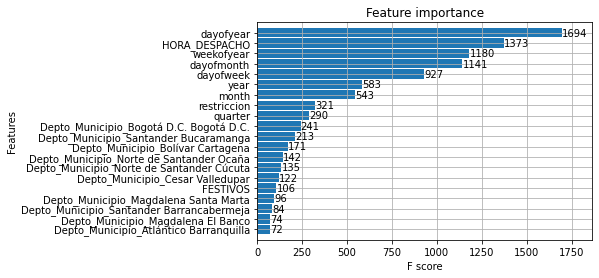

In [94]:
# 3. Evaluate the model

xgb.plot_importance(model_aguachica2, ax=plt.gca(),max_num_features=20, height = 0.9)

predtrain_aguachica = model_aguachica2.predict(x_train_aguachica)
print('R2 train',r2_score(y_train_aguachica,predtrain_aguachica))
print('MSE train',mean_squared_error(y_train_aguachica,predtrain_aguachica))
print('RMSE train',np.sqrt(mean_squared_error(y_train_aguachica,predtrain_aguachica)))

predtest_aguachica=model_aguachica2.predict(x_test_aguachica)
print('R2 test',r2_score(y_test_aguachica,predtest_aguachica))
print('MSE test',mean_squared_error(y_test_aguachica,predtest_aguachica))
print('RMSE test',np.sqrt(mean_squared_error(y_test_aguachica,predtest_aguachica)))

print('Percentil 99 Passengers',np.percentile(data_aguachica['PASAJEROS'],99))

In [125]:
# Export model for dash / plotly
file_name = "xgb_model_aguachica.pkl"

# save
pickle.dump(model_aguachica2, open(file_name, "wb"))

# T.T. DE AGUAZUL

In [51]:
# 1. Data wrangling

# a. Select the terminal

t_aguazul=df[df['TERMINAL'] =='T.T. DE AGUAZUL']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_aguazul=t_aguazul.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_aguazul = data_aguazul.rename(columns={'sum':'PASAJEROS'})

# c. Create new features

# Holidays
dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_aguazul['FESTIVOS'] = data_aguazul['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

# features date
data_aguazul['dayofweek'] = data_aguazul['FECHA_DESPACHO'].dt.dayofweek
data_aguazul['quarter'] = data_aguazul['FECHA_DESPACHO'].dt.quarter
data_aguazul['month'] = data_aguazul['FECHA_DESPACHO'].dt.month
data_aguazul['year'] = data_aguazul['FECHA_DESPACHO'].dt.year
data_aguazul['dayofyear'] = data_aguazul['FECHA_DESPACHO'].dt.dayofyear
data_aguazul['dayofmonth'] = data_aguazul['FECHA_DESPACHO'].dt.day
data_aguazul['weekofyear'] = data_aguazul['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions
data_aguazul["restriccion"] = np.where(data_aguazul['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_aguazul['FECHA_DESPACHO'] > '2020-03-26')&(data_aguazul['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_aguazul['FECHA_DESPACHO'] >='2020-09-01')&(data_aguazul['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_aguazul['FECHA_DESPACHO'] >='2021-03-01')&(data_aguazul['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# travel destination
data_aguazul["Depto_Municipio"]=data_aguazul['DEPARTAMENTO_DESTINO']+' '+data_aguazul['MUNICIPIO_DESTINO']


<ipython-input-51-4f12e31f3f62>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_aguazul['weekofyear'] = data_aguazul['FECHA_DESPACHO'].dt.weekofyear


In [52]:
# 2. Model
# Split data in features and target values
x_aguazul=data_aguazul.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_aguazul=data_aguazul['PASAJEROS']

# Encoding categorical data
x_aguazul_encoded=pd.get_dummies(x_aguazul, columns=["Depto_Municipio"])

# Data training and data test
x_train_aguazul, x_test_aguazul, y_train_aguazul, y_test_aguazul = train_test_split(x_aguazul_encoded,y_aguazul,test_size=0.3,random_state=42)

# create model XGBoost Regressor
model_aguazul = XGBRegressor(objective ='reg:squarederror', seed = 123)

# create random search model and fit training and test data
random_search = RandomizedSearchCV(model_aguazul, param_distributions=params, n_iter=5, scoring='r2', n_jobs=-1, cv=5, 
                                   verbose=3)
random_search.fit(x_train_aguazul, y_train_aguazul)

# Obtain best estimator to tuned model XGBoost Regressor
print(random_search.best_estimator_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.4, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=8,
             min_child_weight=7, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)


In [53]:
# Run model with best parameters given in Randomized Search

# define model
model_aguazul2 = XGBRegressor(objective ='reg:squarederror', seed = 123,base_score=0.5, booster='gbtree', colsample_bylevel=1,
                              colsample_bynode=1, colsample_bytree=0.7, gamma=0.4, gpu_id=-1,
                              importance_type='gain', interaction_constraints='',
                              learning_rate=0.1, max_delta_step=0, max_depth=8,
                              min_child_weight=7, n_estimator=100, n_jobs=2, num_parallel_tree=1,
                              random_state=123, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method='exact', validate_parameters=1,
                              verbosity=None)

# fit model
model_aguazul2.fit(x_train_aguazul, y_train_aguazul)


[05:13:38] WARNING: ../src/learner.cc:573: 
Parameters: { "n_estimator" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.4, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=8,
             min_child_weight=7, missing=nan, monotone_constraints='()',
             n_estimator=100, n_estimators=100, n_jobs=2, num_parallel_tree=1,
             random_state=123, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=123, subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.6812075776405273
MSE train 75.64866562211134
RMSE train 8.697624136631298
R2 test 0.5922566187094509
MSE test 90.9905420074397
RMSE test 9.538896267778558
Percentil 99 Passengers 73.0


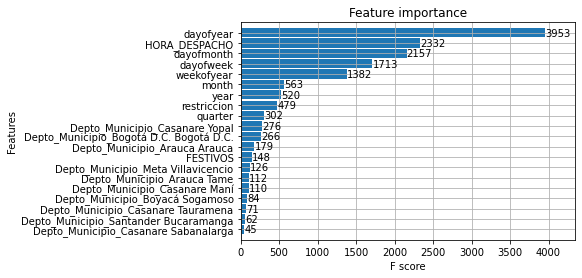

In [54]:
# 3. Evaluate the model

xgb.plot_importance(model_aguazul2, ax=plt.gca(),max_num_features=20, height = 0.9)

predtrain_aguazul = model_aguazul2.predict(x_train_aguazul)
print('R2 train',r2_score(y_train_aguazul,predtrain_aguazul))
print('MSE train',mean_squared_error(y_train_aguazul,predtrain_aguazul))
print('RMSE train',np.sqrt(mean_squared_error(y_train_aguazul,predtrain_aguazul)))

predtest_aguazul=model_aguazul2.predict(x_test_aguazul)
print('R2 test',r2_score(y_test_aguazul,predtest_aguazul))
print('MSE test',mean_squared_error(y_test_aguazul,predtest_aguazul))
print('RMSE test',np.sqrt(mean_squared_error(y_test_aguazul,predtest_aguazul)))

print('Percentil 99 Passengers',np.percentile(data_aguazul['PASAJEROS'],99))

In [131]:
# Export model for dash / plotly
file_name = "xgb_model_aguazul.pkl"

# save
pickle.dump(model_aguazul2, open(file_name, "wb"))

## T.T. DE BUENAVENTURA

In [57]:
# 1. Data wrangling

# a. Select the terminal
t_buenaventura=df[df['TERMINAL'] =='T.T. DE BUENAVENTURA']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_buenaventura=t_buenaventura.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_buenaventura = data_buenaventura.rename(columns={'sum':'PASAJEROS'})

# c. Create new features

# Holidays
dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_buenaventura['FESTIVOS'] = data_buenaventura['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

# Features date
data_buenaventura['dayofweek'] = data_buenaventura['FECHA_DESPACHO'].dt.dayofweek
data_buenaventura['quarter'] = data_buenaventura['FECHA_DESPACHO'].dt.quarter
data_buenaventura['month'] = data_buenaventura['FECHA_DESPACHO'].dt.month
data_buenaventura['year'] = data_buenaventura['FECHA_DESPACHO'].dt.year
data_buenaventura['dayofyear'] = data_buenaventura['FECHA_DESPACHO'].dt.dayofyear
data_buenaventura['dayofmonth'] = data_buenaventura['FECHA_DESPACHO'].dt.day
data_buenaventura['weekofyear'] = data_buenaventura['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions
data_buenaventura["restriccion"] = np.where(data_buenaventura['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_buenaventura['FECHA_DESPACHO'] > '2020-03-26')&(data_buenaventura['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_buenaventura['FECHA_DESPACHO'] >='2020-09-01')&(data_buenaventura['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_buenaventura['FECHA_DESPACHO'] >='2021-03-01')&(data_buenaventura['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destination
data_buenaventura["Depto_Municipio"]=data_buenaventura['DEPARTAMENTO_DESTINO']+' '+data_buenaventura['MUNICIPIO_DESTINO']


<ipython-input-57-85a8fd84fa26>:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_buenaventura['weekofyear'] = data_buenaventura['FECHA_DESPACHO'].dt.weekofyear


In [58]:
# 2. Model
# Split data in features and target values
x_buenaventura=data_buenaventura.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_buenaventura=data_buenaventura['PASAJEROS']

# Encoding categorical data
x_buenaventura_encoded=pd.get_dummies(x_buenaventura, columns=["Depto_Municipio"])

# Data training and data test
x_train_buenaventura, x_test_buenaventura, y_train_buenaventura, y_test_buenaventura = train_test_split(x_buenaventura_encoded,y_buenaventura,test_size=0.3,random_state=42)

# create model XGBoost Regressor
model_buenaventura = XGBRegressor(objective ='reg:squarederror', seed = 123)

# create random search model and fit training and test data
random_search = RandomizedSearchCV(model_buenaventura, param_distributions=params, n_iter=5, scoring='r2', n_jobs=-1, cv=5, 
                                   verbose=3)
random_search.fit(x_train_buenaventura, y_train_buenaventura)

# Obtain best estimator to tuned model XGBoost Regressor
print(random_search.best_estimator_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.3, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.15, max_delta_step=0, max_depth=8,
             min_child_weight=7, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)


In [59]:
# Run model with best parameters given in Randomized Search
model_buenaventura2 = XGBRegressor(objective ='reg:squarederror', seed = 123,base_score=0.5, booster='gbtree', 
                                   colsample_bylevel=1,colsample_bynode=1, colsample_bytree=0.5, gamma=0.3, gpu_id=-1,
                                   importance_type='gain', interaction_constraints='',
                                   learning_rate=0.15, max_delta_step=0, max_depth=8,
                                   min_child_weight=5,n_estimator=100, n_jobs=2, num_parallel_tree=1,
                                   random_state=123, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                                   subsample=1, tree_method='exact', validate_parameters=1,
                                   verbosity=None)

# fit model
model_buenaventura2.fit(x_train_buenaventura, y_train_buenaventura)

[05:24:25] WARNING: ../src/learner.cc:573: 
Parameters: { "n_estimator" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.3, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.15, max_delta_step=0, max_depth=8,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimator=100, n_estimators=100, n_jobs=2, num_parallel_tree=1,
             random_state=123, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=123, subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.7966311164230637
MSE train 73.71948259993854
RMSE train 8.586005043088347
R2 test 0.694203224426379
MSE test 104.86870090270608
RMSE test 10.24054202191984
Percentil 99 Passengers 85.0


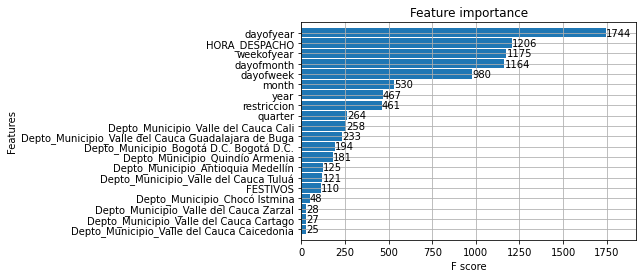

In [60]:
# 3. Evaluate the model

xgb.plot_importance(model_buenaventura2, ax=plt.gca(),max_num_features=20, height = 0.9)

predtrain_buenaventura = model_buenaventura2.predict(x_train_buenaventura)
print('R2 train',r2_score(y_train_buenaventura,predtrain_buenaventura))
print('MSE train',mean_squared_error(y_train_buenaventura,predtrain_buenaventura))
print('RMSE train',np.sqrt(mean_squared_error(y_train_buenaventura,predtrain_buenaventura)))

predtest_buenaventura=model_buenaventura2.predict(x_test_buenaventura)
print('R2 test',r2_score(y_test_buenaventura,predtest_buenaventura))
print('MSE test',mean_squared_error(y_test_buenaventura,predtest_buenaventura))
print('RMSE test',np.sqrt(mean_squared_error(y_test_buenaventura,predtest_buenaventura)))

print('Percentil 99 Passengers',np.percentile(data_buenaventura['PASAJEROS'],99))

In [137]:
# Export model for dash / plotly
file_name = "xgb_model_buenaventura.pkl"

# save
pickle.dump(model_buenaventura2, open(file_name, "wb"))

## T.T. DE CAUCASIA

In [61]:
# 1. Data wrangling

# a. Select the terminal

t_caucasia=df[df['TERMINAL'] =='T.T. DE CAUCASIA']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_caucasia=t_caucasia.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_caucasia = data_caucasia.rename(columns={'sum':'PASAJEROS'})

# c. Create new features
# Holidays
dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_caucasia['FESTIVOS'] = data_caucasia['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

# Features date
data_caucasia['dayofweek'] = data_caucasia['FECHA_DESPACHO'].dt.dayofweek
data_caucasia['quarter'] = data_caucasia['FECHA_DESPACHO'].dt.quarter
data_caucasia['month'] = data_caucasia['FECHA_DESPACHO'].dt.month
data_caucasia['year'] = data_caucasia['FECHA_DESPACHO'].dt.year
data_caucasia['dayofyear'] = data_caucasia['FECHA_DESPACHO'].dt.dayofyear
data_caucasia['dayofmonth'] = data_caucasia['FECHA_DESPACHO'].dt.day
data_caucasia['weekofyear'] = data_caucasia['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions
data_caucasia["restriccion"] = np.where(data_caucasia['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_caucasia['FECHA_DESPACHO'] > '2020-03-26')&(data_caucasia['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_caucasia['FECHA_DESPACHO'] >='2020-09-01')&(data_caucasia['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_caucasia['FECHA_DESPACHO'] >='2021-03-01')&(data_caucasia['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destination
data_caucasia["Depto_Municipio"]=data_caucasia['DEPARTAMENTO_DESTINO']+' '+data_caucasia['MUNICIPIO_DESTINO']


<ipython-input-61-5a177bd38f62>:30: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_caucasia['weekofyear'] = data_caucasia['FECHA_DESPACHO'].dt.weekofyear


In [62]:
# 2. Model
# Split data in features and target values
x_caucasia=data_caucasia.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_caucasia=data_caucasia['PASAJEROS']

# Encoding categorical data
x_caucasia_encoded=pd.get_dummies(x_caucasia, columns=["Depto_Municipio"])

# Data training and data test
x_train_caucasia, x_test_caucasia, y_train_caucasia, y_test_caucasia = train_test_split(x_caucasia_encoded,y_caucasia,test_size=0.3,random_state=42)

# create model XGBoost Regressor
model_caucasia = XGBRegressor(objective ='reg:squarederror', seed = 123)

# create random search model and fit training and test data
random_search = RandomizedSearchCV(model_caucasia, param_distributions=params, n_iter=5, scoring='r2', n_jobs=-1, cv=5, 
                                   verbose=3)
random_search.fit(x_train_caucasia, y_train_caucasia)

# Obtain best estimator to tuned model XGBoost Regressor
print(random_search.best_estimator_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.15, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)


In [73]:
# Run model with best parameters given in Randomized Search
model_caucasia2 = XGBRegressor(objective ='reg:squarederror', seed = 123,base_score=0.5, booster='gbtree', 
                               colsample_bylevel=1,colsample_bynode=1, colsample_bytree=0.7, gamma=0.1, gpu_id=-1,
                               importance_type='gain', interaction_constraints='',
                               learning_rate=0.15, max_delta_step=0, max_depth=7,
                               min_child_weight=1, n_estimators=100, n_jobs=2, num_parallel_tree=1, 
                               random_state=123,reg_alpha=0, reg_lambda=1, scale_pos_weight=1,subsample=1, 
                               tree_method='exact', validate_parameters=1,verbosity=None)

# fit model
model_caucasia2.fit(x_train_caucasia, y_train_caucasia)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.15, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.6628878214329706
MSE train 34.65004383059912
RMSE train 5.886428784127021
R2 test 0.5550274230736645
MSE test 42.320180492847626
RMSE test 6.505396259479328
Percentil 99 Passengers 48.0


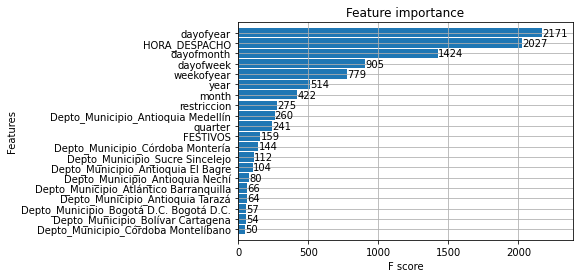

In [74]:
# 3. Evaluate the model

xgb.plot_importance(model_caucasia2, ax=plt.gca(),max_num_features=20, height = 0.9)

predtrain_caucasia = model_caucasia2.predict(x_train_caucasia)
print('R2 train',r2_score(y_train_caucasia,predtrain_caucasia))
print('MSE train',mean_squared_error(y_train_caucasia,predtrain_caucasia))
print('RMSE train',np.sqrt(mean_squared_error(y_train_caucasia,predtrain_caucasia)))

predtest_caucasia=model_caucasia2.predict(x_test_caucasia)
print('R2 test',r2_score(y_test_caucasia,predtest_caucasia))
print('MSE test',mean_squared_error(y_test_caucasia,predtest_caucasia))
print('RMSE test',np.sqrt(mean_squared_error(y_test_caucasia,predtest_caucasia)))

print('Percentil 99 Passengers',np.percentile(data_caucasia['PASAJEROS'],99))

In [143]:
# Export model for dash / plotly
file_name = "xgb_model_caucasia.pkl"

# save
pickle.dump(model_caucasia2, open(file_name, "wb"))

## T.T. DE LA PLATA

In [65]:
# 1. Data wrangling

# a. Select the terminal

t_laplata=df[df['TERMINAL'] =='T.T. DE LA PLATA']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_laplata=t_laplata.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                        'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_laplata = data_laplata.rename(columns={'sum':'PASAJEROS'})

# c. Create new features

# Holidays
dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_laplata['FESTIVOS'] = data_laplata['FECHA_DESPACHO'].isin(dias_festivos20_21)*1

# Features date
data_laplata['dayofweek'] = data_laplata['FECHA_DESPACHO'].dt.dayofweek
data_laplata['quarter'] = data_laplata['FECHA_DESPACHO'].dt.quarter
data_laplata['month'] = data_laplata['FECHA_DESPACHO'].dt.month
data_laplata['year'] = data_laplata['FECHA_DESPACHO'].dt.year
data_laplata['dayofyear'] = data_laplata['FECHA_DESPACHO'].dt.dayofyear
data_laplata['dayofmonth'] = data_laplata['FECHA_DESPACHO'].dt.day
data_laplata['weekofyear'] = data_laplata['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions
data_laplata["restriccion"] = np.where(data_laplata['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_laplata['FECHA_DESPACHO'] > '2020-03-26')&(data_laplata['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_laplata['FECHA_DESPACHO'] >='2020-09-01')&(data_laplata['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_laplata['FECHA_DESPACHO'] >='2021-03-01')&(data_laplata['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# travel destination
data_laplata["Depto_Municipio"]=data_laplata['DEPARTAMENTO_DESTINO']+' '+data_laplata['MUNICIPIO_DESTINO']


<ipython-input-65-7dfa883d9be0>:32: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_laplata['weekofyear'] = data_laplata['FECHA_DESPACHO'].dt.weekofyear


In [66]:
# 2. Model
# Split data in features and target values
x_laplata=data_laplata.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_laplata=data_laplata['PASAJEROS']

# Encoding categorical data
x_laplata_encoded=pd.get_dummies(x_laplata, columns=["Depto_Municipio"])

# Data training and data test
x_train_laplata, x_test_laplata, y_train_laplata, y_test_laplata = train_test_split(x_laplata_encoded,y_laplata,test_size=0.3,random_state=42)

# create model XGBoost Regressor
model_laplata = XGBRegressor(objective ='reg:squarederror', seed = 123)

# create random search model and fit training and test data
random_search = RandomizedSearchCV(model_laplata, param_distributions=params, n_iter=5, scoring='r2', n_jobs=-1, cv=5, 
                                   verbose=3)
random_search.fit(x_train_laplata, y_train_laplata)

# Obtain best estimator to tuned model XGBoost Regressor
print(random_search.best_estimator_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0.4, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)


In [69]:
# Run model with best parameters given in Randomized Search
model_laplata2 = XGBRegressor(objective ='reg:squarederror', seed = 123,base_score=0.5, booster='gbtree', 
                              colsample_bylevel=1,colsample_bynode=1, colsample_bytree=0.4, gamma=0.4, 
                              gpu_id=-1,importance_type='gain', interaction_constraints='',
                              learning_rate=0.1, max_delta_step=0, max_depth=8,min_child_weight=1, 
                              n_estimator=100, n_jobs=2, num_parallel_tree=1,random_state=123, reg_alpha=0, 
                              reg_lambda=1, scale_pos_weight=1,subsample=1, tree_method='exact', validate_parameters=1,
                              verbosity=None)

# fit model
model_laplata2.fit(x_train_laplata, y_train_laplata)


[05:48:35] WARNING: ../src/learner.cc:573: 
Parameters: { "n_estimator" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0.4, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimator=100, n_estimators=100, n_jobs=2, num_parallel_tree=1,
             random_state=123, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=123, subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 train 0.6783694032249923
MSE train 31.228952309830227
RMSE train 5.588287064014359
R2 test 0.5581875621620227
MSE test 43.78681931369987
RMSE test 6.6171609708167045
Percentil 99 Passengers 47.0


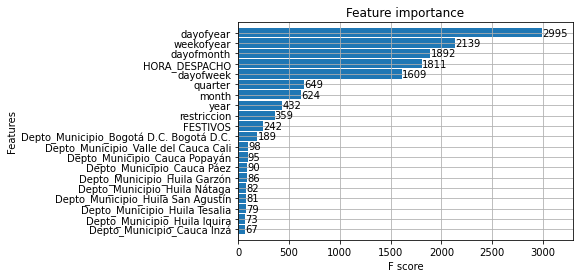

In [70]:
# 3. Evaluate the model

xgb.plot_importance(model_laplata2, ax=plt.gca(),max_num_features=20, height = 0.9)

predtrain_laplata = model_laplata2.predict(x_train_laplata)
print('R2 train',r2_score(y_train_laplata,predtrain_laplata))
print('MSE train',mean_squared_error(y_train_laplata,predtrain_laplata))
print('RMSE train',np.sqrt(mean_squared_error(y_train_laplata,predtrain_laplata)))

predtest_laplata=model_laplata2.predict(x_test_laplata)
print('R2 test',r2_score(y_test_laplata,predtest_laplata))
print('MSE test',mean_squared_error(y_test_laplata,predtest_laplata))
print('RMSE test',np.sqrt(mean_squared_error(y_test_laplata,predtest_laplata)))

print('Percentil 99 Passengers',np.percentile(data_laplata['PASAJEROS'],99))

In [149]:
# Export model for dash / plotly
file_name = "xgb_model_laplata.pkl"

# save
pickle.dump(model_laplata2, open(file_name, "wb"))

## T.T. DE MAICAO

In [3]:
# 1 Data wrangling

# a Select the terminal
t_maicao=df[df['TERMINAL'] =='T.T. DE MAICAO']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_maicao=t_maicao.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                     'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_maicao = data_maicao.rename(columns={'sum':'PASAJEROS'})

# b Create new features
# Holidays
dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_maicao['FESTIVOS'] =   data_maicao['FECHA_DESPACHO'].isin(dias_festivos20_21)*1
# Features date
data_maicao['dayofweek'] =  data_maicao['FECHA_DESPACHO'].dt.dayofweek
data_maicao['quarter'] =    data_maicao['FECHA_DESPACHO'].dt.quarter
data_maicao['month'] =      data_maicao['FECHA_DESPACHO'].dt.month
data_maicao['year'] =       data_maicao['FECHA_DESPACHO'].dt.year
data_maicao['dayofyear'] =  data_maicao['FECHA_DESPACHO'].dt.dayofyear
data_maicao['dayofmonth'] = data_maicao['FECHA_DESPACHO'].dt.day
data_maicao['weekofyear'] = data_maicao['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions

data_maicao["restriccion"] = np.where(data_maicao['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_maicao['FECHA_DESPACHO'] > '2020-03-26')&(data_maicao['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_maicao['FECHA_DESPACHO'] >='2020-09-01')&(data_maicao['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_maicao['FECHA_DESPACHO'] >='2021-03-01')&(data_maicao['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destination

data_maicao["Depto_Municipio"]=data_maicao['DEPARTAMENTO_DESTINO']+' '+data_maicao['MUNICIPIO_DESTINO']

<ipython-input-3-f3ae05cbf409>:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_maicao['weekofyear'] = data_maicao['FECHA_DESPACHO'].dt.weekofyear


In [6]:
# 2. Model
# Split data in features and target values
x_maicao=data_maicao.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_maicao=data_maicao['PASAJEROS']

# Encoding categorical data
x_maicao_encoded=pd.get_dummies(x_maicao, columns=["Depto_Municipio"])

# Data training and data test
x_train_maicao, x_test_maicao, y_train_maicao, y_test_maicao = train_test_split(x_maicao_encoded,y_maicao,test_size=0.3,random_state=42)

# create model XGBoost Regressor
model_maicao = XGBRegressor(objective ='reg:squarederror', seed = 123)

# create random search model and fit training and test data
random_search = RandomizedSearchCV(model_maicao, param_distributions=params, n_iter=5, scoring='r2', n_jobs=-1, cv=5, 
                                   verbose=3)
random_search.fit(x_train_maicao, y_train_maicao)

# Obtain best estimator to tuned model XGBoost Regressor
print(random_search.best_estimator_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[19:46:25] WARNING: ../src/learner.cc:573: 
Parameters: { "n_estimator" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=10,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimator=140, n_estimators=100, n_jobs=2, num_parallel_tree=1,
             random_state=123, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=123, subsample=1, tree_method='exact', validate_parameters=1,
             verbosity

In [7]:
# Run model with best parameters given in Randomized Search
model_maicao = XGBRegressor(objective ='reg:squarederror', seed = 123,
                           base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.2, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=5, n_estimators=100, n_jobs=8, 
             num_parallel_tree=1, random_state=123,reg_alpha=0, 
             reg_lambda=1, scale_pos_weight=1, subsample=1, 
             tree_method='exact', validate_parameters=1,
             verbosity=None)
model_maicao.fit(x_train_maicao, y_train_maicao)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.2, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 0.6512714557542236
MSE 98.32620747065994
RMSE train 9.915957214039397
R2 0.5458816972573904
MSE 117.44240270083856
RMSE test 10.837084603381047


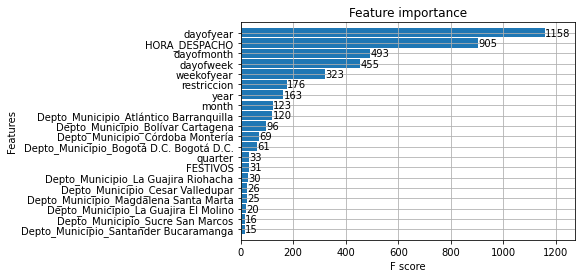

In [8]:
# 3 Evaluate the model

# Feature importance
%matplotlib inline
xgb.plot_importance(model_maicao, ax=plt.gca(),max_num_features=20, height = 0.9)

#Metrics
predtrain_maicao = model_maicao.predict(x_train_maicao)
print('R2',r2_score(y_train_maicao,predtrain_maicao))
print('MSE',mean_squared_error(y_train_maicao,predtrain_maicao))
print('RMSE train',np.sqrt(mean_squared_error(y_train_maicao,predtrain_maicao)))

predtest_maicao=model_maicao.predict(x_test_maicao)
print('R2',r2_score(y_test_maicao,predtest_maicao))
print('MSE',mean_squared_error(y_test_maicao,predtest_maicao))
print('RMSE test',np.sqrt(mean_squared_error(y_test_maicao,predtest_maicao)))

In [11]:
# Export model for dash / plotly
file_name = "xgb_model_maicao2.pkl"

# save
pickle.dump(model_maicao, open(file_name, "wb"))

### T.T. DE OCAÑA

In [12]:
# Data wrangling

# a Select the terminal
t_ocana=df[df['TERMINAL'] =='T.T. DE OCAÑA']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_ocana=t_ocana.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                     'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_ocana = data_ocana.rename(columns={'sum':'PASAJEROS'})

# c Create new features
# Holidays
dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_ocana['FESTIVOS'] =   data_ocana['FECHA_DESPACHO'].isin(dias_festivos20_21)*1
data_ocana['dayofweek'] =  data_ocana['FECHA_DESPACHO'].dt.dayofweek
data_ocana['quarter'] =    data_ocana['FECHA_DESPACHO'].dt.quarter
data_ocana['month'] =      data_ocana['FECHA_DESPACHO'].dt.month
data_ocana['year'] =       data_ocana['FECHA_DESPACHO'].dt.year
data_ocana['dayofyear'] =  data_ocana['FECHA_DESPACHO'].dt.dayofyear
data_ocana['dayofmonth'] = data_ocana['FECHA_DESPACHO'].dt.day
data_ocana['weekofyear'] = data_ocana['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions

data_ocana["restriccion"] = np.where(data_ocana['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_ocana['FECHA_DESPACHO'] > '2020-03-26')&(data_ocana['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_ocana['FECHA_DESPACHO'] >='2020-09-01')&(data_ocana['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_ocana['FECHA_DESPACHO'] >='2021-03-01')&(data_ocana['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destination

data_ocana["Depto_Municipio"]=data_ocana['DEPARTAMENTO_DESTINO']+' '+data_ocana['MUNICIPIO_DESTINO']

<ipython-input-12-3cc109cb34df>:28: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_ocana['weekofyear'] = data_ocana['FECHA_DESPACHO'].dt.weekofyear


In [13]:
# 2 Model 
# Split data in features and target values
x_ocana=data_ocana.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_ocana=data_ocana['PASAJEROS']

# Encoding categorical data
x_ocana_encoded=pd.get_dummies(x_ocana, columns=["Depto_Municipio"])

# Data training and data test
x_train_ocana, x_test_ocana, y_train_ocana, y_test_ocana = train_test_split(x_ocana_encoded,y_ocana,test_size=0.3,random_state=42)

# create model XGBoost Regressor
model_ocana = XGBRegressor(objective ='reg:squarederror', seed = 123)

# create random search model and fit training and test data
random_search = RandomizedSearchCV(model_ocana, param_distributions=params, n_iter=5, scoring='r2', n_jobs=-1, cv=5, 
                                   verbose=3)
random_search.fit(x_train_ocana, y_train_ocana)
# Obtain best estimator to tuned model XGBoost Regressor
random_search.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[20:13:34] WARNING: ../src/learner.cc:573: 
Parameters: { "n_estimator" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=5,
             min_child_weight=7, missing=nan, monotone_constraints='()',
             n_estimator=80, n_estimators=100, n_jobs=2, num_parallel_tree=1,
             random_state=123, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=123, subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [14]:
# Run model with best parameters given ni Randomized Search
model_ocana = XGBRegressor(objective ='reg:squarederror', seed = 123,
                           base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0.4, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.25, max_delta_step=0, max_depth=8,
             min_child_weight=5,n_estimators=100, n_jobs=8, 
             num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)
model_ocana.fit(x_train_ocana, y_train_ocana)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0.4, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.25, max_delta_step=0, max_depth=8,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 0.7003771769005419
MSE 29.95189550676342
RMSE train 5.4728324939434625
R2 0.5541469510569829
MSE 42.088369838020995
RMSE test 6.487554996916866
Mean of passengers 10.038845910304765


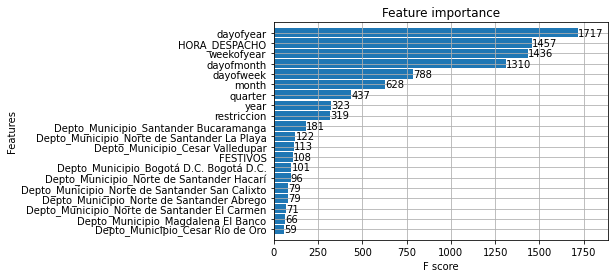

In [15]:
# 3 Evaluate the model

# Feature Importance
%matplotlib inline
xgb.plot_importance(model_ocana, ax=plt.gca(),max_num_features=20, height = 0.9)

# Metrics 
predtrain_ocana = model_ocana.predict(x_train_ocana)
print('R2',r2_score(y_train_ocana,predtrain_ocana))
print('MSE',mean_squared_error(y_train_ocana,predtrain_ocana))
print('RMSE train',np.sqrt(mean_squared_error(y_train_ocana,predtrain_ocana)))

predtest_ocana=model_ocana.predict(x_test_ocana)
print('R2',r2_score(y_test_ocana,predtest_ocana))
print('MSE',mean_squared_error(y_test_ocana,predtest_ocana))
print('RMSE test',np.sqrt(mean_squared_error(y_test_ocana,predtest_ocana)))
print('Mean of passengers',y_ocana.mean())

In [16]:
# Export model for dash / plotly
file_name = "xgb_model_ocana2.pkl"

# save
pickle.dump(model_ocana, open(file_name, "wb"))

### T.T. DE PAMPLONA

In [17]:
# Data Wrangling

# a. Select the terminal
t_pamplona=df[df['TERMINAL'] =='T.T. DE PAMPLONA']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_pamplona=t_pamplona.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                     'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_pamplona = data_pamplona.rename(columns={'sum':'PASAJEROS'})

# c. Create new features
# Holidays
dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']

data_pamplona['FESTIVOS'] =   data_pamplona['FECHA_DESPACHO'].isin(dias_festivos20_21)*1
data_pamplona['dayofweek'] =  data_pamplona['FECHA_DESPACHO'].dt.dayofweek
data_pamplona['quarter'] =    data_pamplona['FECHA_DESPACHO'].dt.quarter
data_pamplona['month'] =      data_pamplona['FECHA_DESPACHO'].dt.month
data_pamplona['year'] =       data_pamplona['FECHA_DESPACHO'].dt.year
data_pamplona['dayofyear'] =  data_pamplona['FECHA_DESPACHO'].dt.dayofyear
data_pamplona['dayofmonth'] = data_pamplona['FECHA_DESPACHO'].dt.day
data_pamplona['weekofyear'] = data_pamplona['FECHA_DESPACHO'].dt.weekofyear

# c. Mobility restrictions
data_pamplona["restriccion"] = np.where(data_pamplona['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_pamplona['FECHA_DESPACHO'] > '2020-03-26')&(data_pamplona['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_pamplona['FECHA_DESPACHO'] >='2020-09-01')&(data_pamplona['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_pamplona['FECHA_DESPACHO'] >='2021-03-01')&(data_pamplona['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destination
data_pamplona["Depto_Municipio"]=data_pamplona['DEPARTAMENTO_DESTINO']+' '+data_pamplona['MUNICIPIO_DESTINO']

<ipython-input-17-1729568f9d42>:28: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_pamplona['weekofyear'] = data_pamplona['FECHA_DESPACHO'].dt.weekofyear


In [18]:
# 2. Model
# Split data in features and target values
x_pamplona=data_pamplona.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_pamplona=data_pamplona['PASAJEROS']

# Encoding categorical data
x_pamplona_encoded=pd.get_dummies(x_pamplona, columns=["Depto_Municipio"])

# Data training and data test
x_train_pamplona, x_test_pamplona, y_train_pamplona, y_test_pamplona = train_test_split(x_pamplona_encoded,y_pamplona,test_size=0.3,random_state=42)

# create model XGBoost Regressor
model_pamplona = XGBRegressor(objective ='reg:squarederror', seed = 123)

# create random search model and fit training and test data
random_search = RandomizedSearchCV(model_pamplona, param_distributions=params, n_iter=5, scoring='r2', n_jobs=-1, cv=5, 
                                   verbose=3)
random_search.fit(x_train_pamplona, y_train_pamplona)

# Obtain best estimator to tuned model XGBoost Regressor
random_search.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[20:29:19] WARNING: ../src/learner.cc:573: 
Parameters: { "n_estimator" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.25, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimator=120, n_estimators=100, n_jobs=2, num_parallel_tree=1,
             random_state=123, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=123, subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [19]:
# Run model with best parameters given ni Randomized Search
model_pamplona = XGBRegressor(objective ='reg:squarederror', seed = 123,
                           base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0.3, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=6,
             min_child_weight=5,n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)
model_pamplona.fit(x_train_pamplona, y_train_pamplona)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0.3, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=6,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 0.5957765405670699
MSE 9.89408008387302
RMSE train 3.145485667408615
R2 0.5280895734197586
MSE 11.565603325761304
RMSE test 3.4008239186646083


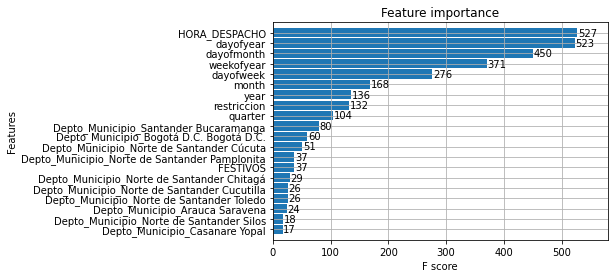

In [20]:
# 3. Evaluate the model

# Feature importance
%matplotlib inline
xgb.plot_importance(model_pamplona, ax=plt.gca(),max_num_features=20, height = 0.9)

# Metrics
predtrain_pamplona = model_pamplona.predict(x_train_pamplona)
print('R2',r2_score(y_train_pamplona,predtrain_pamplona))
print('MSE',mean_squared_error(y_train_pamplona,predtrain_pamplona))
print('RMSE train',np.sqrt(mean_squared_error(y_train_pamplona,predtrain_pamplona)))

predtest_pamplona=model_pamplona.predict(x_test_pamplona)
print('R2',r2_score(y_test_pamplona,predtest_pamplona))
print('MSE',mean_squared_error(y_test_pamplona,predtest_pamplona))
print('RMSE test',np.sqrt(mean_squared_error(y_test_pamplona,predtest_pamplona)))

In [21]:
# Export model for dash / plotly
file_name = "xgb_model_pamplona2.pkl"

# save
pickle.dump(model_pamplona, open(file_name, "wb"))

### T.T. DE QUIBDO

In [22]:
# 1 Data wrangling

# a. Select the terminal
t_quibdo=df[df['TERMINAL'] =='T.T. DE QUIBDO']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_quibdo=t_quibdo.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                     'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_quibdo = data_quibdo.rename(columns={'sum':'PASAJEROS'})

# c. Create new features

#Holidays
dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']
# Features date
data_quibdo['FESTIVOS'] =   data_quibdo['FECHA_DESPACHO'].isin(dias_festivos20_21)*1
data_quibdo['dayofweek'] =  data_quibdo['FECHA_DESPACHO'].dt.dayofweek
data_quibdo['quarter'] =    data_quibdo['FECHA_DESPACHO'].dt.quarter
data_quibdo['month'] =      data_quibdo['FECHA_DESPACHO'].dt.month
data_quibdo['year'] =       data_quibdo['FECHA_DESPACHO'].dt.year
data_quibdo['dayofyear'] =  data_quibdo['FECHA_DESPACHO'].dt.dayofyear
data_quibdo['dayofmonth'] = data_quibdo['FECHA_DESPACHO'].dt.day
data_quibdo['weekofyear'] = data_quibdo['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions

data_quibdo["restriccion"] = np.where(data_quibdo['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_quibdo['FECHA_DESPACHO'] > '2020-03-26')&(data_quibdo['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_quibdo['FECHA_DESPACHO'] >='2020-09-01')&(data_quibdo['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_quibdo['FECHA_DESPACHO'] >='2021-03-01')&(data_quibdo['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destination

data_quibdo["Depto_Municipio"]=data_quibdo['DEPARTAMENTO_DESTINO']+' '+data_quibdo['MUNICIPIO_DESTINO']

<ipython-input-22-3a2d0f5d30bc>:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_quibdo['weekofyear'] = data_quibdo['FECHA_DESPACHO'].dt.weekofyear


In [23]:
# 2. Model

# Split data in features and target values
x_quibdo=data_quibdo.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_quibdo=data_quibdo['PASAJEROS']

# Encoding categorical data
x_quibdo_encoded=pd.get_dummies(x_quibdo, columns=["Depto_Municipio"])

# Data training and data test
x_train_quibdo, x_test_quibdo, y_train_quibdo, y_test_quibdo = train_test_split(x_quibdo_encoded,y_quibdo,test_size=0.3,random_state=42)

# create model XGBoost Regressor
model_quibdo = XGBRegressor(objective ='reg:squarederror', seed = 123)

# create random search model and fit training and test data
random_search = RandomizedSearchCV(model_quibdo, param_distributions=params, n_iter=5, scoring='r2', n_jobs=-1, cv=5, 
                                   verbose=3)
random_search.fit(x_train_quibdo, y_train_quibdo)

# Obtain best estimator to tuned model XGBoost Regressor
random_search.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[21:47:28] WARNING: ../src/learner.cc:573: 
Parameters: { "n_estimator" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0.2, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=4,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimator=200, n_estimators=100, n_jobs=2, num_parallel_tree=1,
             random_state=123, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=123, subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [24]:
# Run model with best parameters given ni Randomized Search
model_quibdo = XGBRegressor(objective ='reg:squarederror', seed = 123,
                           base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.3, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=4,
             min_child_weight=1,n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)
model_quibdo.fit(x_train_quibdo, y_train_quibdo)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.3, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 0.45244071414045917
MSE 40.59883267414374
RMSE train 6.371721327407825
R2 0.38550838908989493
MSE 46.22072818689192
RMSE test 6.798582807239455


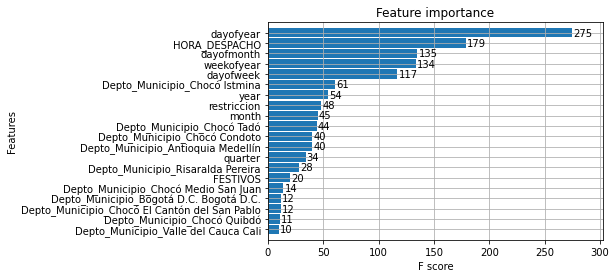

In [26]:
# 3. Evaluate the model

# Feature importance
%matplotlib inline
xgb.plot_importance(model_quibdo, ax=plt.gca(),max_num_features=20, height = 0.9)

# Metrics
predtrain_quibdo = model_quibdo.predict(x_train_quibdo)
print('R2',r2_score(y_train_quibdo,predtrain_quibdo))
print('MSE',mean_squared_error(y_train_quibdo,predtrain_quibdo))
print('RMSE train',np.sqrt(mean_squared_error(y_train_quibdo,predtrain_quibdo)))

predtest_quibdo=model_quibdo.predict(x_test_quibdo)
print('R2',r2_score(y_test_quibdo,predtest_quibdo))
print('MSE',mean_squared_error(y_test_quibdo,predtest_quibdo))
print('RMSE test',np.sqrt(mean_squared_error(y_test_quibdo,predtest_quibdo)))

In [27]:
# Export model for dash / plotly
file_name = "xgb_model_quibdo2.pkl"

# save
pickle.dump(model_quibdo, open(file_name, "wb"))

### T.T. DE SAN GIL

In [28]:
# 1. Data wrangling

# a. Select the terminal
t_sangil=df[df['TERMINAL'] =='T.T. DE SAN GIL']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_sangil=t_sangil.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                     'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_sangil = data_sangil.rename(columns={'sum':'PASAJEROS'})

# c. Create new features
# Holidays
dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']
# Features date
data_sangil['FESTIVOS'] =   data_sangil['FECHA_DESPACHO'].isin(dias_festivos20_21)*1
data_sangil['dayofweek'] =  data_sangil['FECHA_DESPACHO'].dt.dayofweek
data_sangil['quarter'] =    data_sangil['FECHA_DESPACHO'].dt.quarter
data_sangil['month'] =      data_sangil['FECHA_DESPACHO'].dt.month
data_sangil['year'] =       data_sangil['FECHA_DESPACHO'].dt.year
data_sangil['dayofyear'] =  data_sangil['FECHA_DESPACHO'].dt.dayofyear
data_sangil['dayofmonth'] = data_sangil['FECHA_DESPACHO'].dt.day
data_sangil['weekofyear'] = data_sangil['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions

data_sangil["restriccion"] = np.where(data_sangil['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_sangil['FECHA_DESPACHO'] > '2020-03-26')&(data_sangil['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_sangil['FECHA_DESPACHO'] >='2020-09-01')&(data_sangil['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_sangil['FECHA_DESPACHO'] >='2021-03-01')&(data_sangil['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destination

data_sangil["Depto_Municipio"]=data_sangil['DEPARTAMENTO_DESTINO']+' '+data_sangil['MUNICIPIO_DESTINO']

<ipython-input-28-997ed5d34716>:28: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_sangil['weekofyear'] = data_sangil['FECHA_DESPACHO'].dt.weekofyear


In [31]:
# 2. Model

# Split data in features and target values
x_sangil=data_sangil.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_sangil=data_sangil['PASAJEROS']

# Encoding categorical data
x_sangil_encoded=pd.get_dummies(x_sangil, columns=["Depto_Municipio"])

# Data training and data test
x_train_sangil, x_test_sangil, y_train_sangil, y_test_sangil = train_test_split(x_sangil_encoded,y_sangil,test_size=0.3,random_state=42)

# create model XGBoost Regressor
model_sangil = XGBRegressor(objective ='reg:squarederror', seed = 123)

# create random search model and fit training and test data
random_search = RandomizedSearchCV(model_sangil, param_distributions=params, n_iter=5, scoring='r2', n_jobs=-1, cv=5, 
                                   verbose=3)
random_search.fit(x_train_sangil, y_train_sangil)

# Obtain best estimator to tuned model XGBoost Regressor
random_search.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0.0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=6,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [32]:
# Run model with best parameters given in Randomized Search
model_sangil = XGBRegressor(objective ='reg:squarederror', seed = 123,
                           base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.4, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=8,
             min_child_weight=1,n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)
model_sangil.fit(x_train_sangil, y_train_sangil)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.4, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 0.8281807670733178
MSE 31.13486609041445
RMSE train 5.579862551211674
R2 0.7350497300321845
MSE 49.46651343409519
RMSE test 7.033243450506686


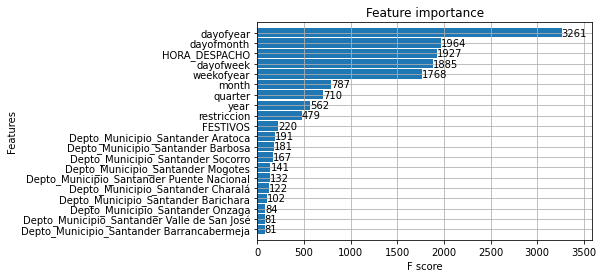

In [33]:
# Evaluate the model
%matplotlib inline
xgb.plot_importance(model_sangil, ax=plt.gca(),max_num_features=20, height = 0.9)

predtrain_sangil = model_sangil.predict(x_train_sangil)
print('R2',r2_score(y_train_sangil,predtrain_sangil))
print('MSE',mean_squared_error(y_train_sangil,predtrain_sangil))
print('RMSE train',np.sqrt(mean_squared_error(y_train_sangil,predtrain_sangil)))

predtest_sangil=model_sangil.predict(x_test_sangil)
print('R2',r2_score(y_test_sangil,predtest_sangil))
print('MSE',mean_squared_error(y_test_sangil,predtest_sangil))
print('RMSE test',np.sqrt(mean_squared_error(y_test_sangil,predtest_sangil)))

In [34]:
# Export model for dash / plotly
file_name = "xgb_model_sangil2.pkl"

# save
pickle.dump(model_sangil, open(file_name, "wb"))

### T.T. DE SOCORRO

In [36]:
# 1. Data Wrangling

# a. Select the terminal
t_socorro=df[df['TERMINAL'] =='T.T. DE SOCORRO']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_socorro=t_socorro.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                     'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_socorro = data_socorro.rename(columns={'sum':'PASAJEROS'})

# c. Create new features
# Holidays
dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']
# Features date
data_socorro['FESTIVOS'] =   data_socorro['FECHA_DESPACHO'].isin(dias_festivos20_21)*1
data_socorro['dayofweek'] =  data_socorro['FECHA_DESPACHO'].dt.dayofweek
data_socorro['quarter'] =    data_socorro['FECHA_DESPACHO'].dt.quarter
data_socorro['month'] =      data_socorro['FECHA_DESPACHO'].dt.month
data_socorro['year'] =       data_socorro['FECHA_DESPACHO'].dt.year
data_socorro['dayofyear'] =  data_socorro['FECHA_DESPACHO'].dt.dayofyear
data_socorro['dayofmonth'] = data_socorro['FECHA_DESPACHO'].dt.day
data_socorro['weekofyear'] = data_socorro['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions

data_socorro["restriccion"] = np.where(data_socorro['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_socorro['FECHA_DESPACHO'] > '2020-03-26')&(data_socorro['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_socorro['FECHA_DESPACHO'] >='2020-09-01')&(data_socorro['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_socorro['FECHA_DESPACHO'] >='2021-03-01')&(data_socorro['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destinations

data_socorro["Depto_Municipio"]=data_socorro['DEPARTAMENTO_DESTINO']+' '+data_socorro['MUNICIPIO_DESTINO']

<ipython-input-36-bd5fce1eae03>:28: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_socorro['weekofyear'] = data_socorro['FECHA_DESPACHO'].dt.weekofyear


In [37]:
# 2. Model

# Split data in features and target values
x_socorro=data_socorro.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_socorro=data_socorro['PASAJEROS']

# Encoding categorical data
x_socorro_encoded=pd.get_dummies(x_socorro, columns=["Depto_Municipio"])

# Data training and data test
x_train_socorro, x_test_socorro, y_train_socorro, y_test_socorro = train_test_split(x_socorro_encoded,y_socorro,test_size=0.3,random_state=42)

# create model XGBoost Regressor
model_socorro = XGBRegressor(objective ='reg:squarederror', seed = 123)

# create random search model and fit training and test data
random_search = RandomizedSearchCV(model_socorro, param_distributions=params, n_iter=5, scoring='r2', n_jobs=-1, cv=5, 
                                   verbose=3)
random_search.fit(x_train_socorro, y_train_socorro)

# Obtain best estimator to tuned model XGBoost Regressor
random_search.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=10,
             min_child_weight=7, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [38]:
# Run model with best parameters given ni Randomized Search
model_socorro = XGBRegressor(objective ='reg:squarederror', seed = 123,
                           base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0.2, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=6,
             min_child_weight=1,
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)
model_socorro.fit(x_train_socorro, y_train_socorro)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0.2, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 0.7784202508548816
MSE 31.81336926524653
RMSE train 5.640334144822142
R2 0.718608642049306
MSE 39.46081842231047
RMSE test 6.281784652653294


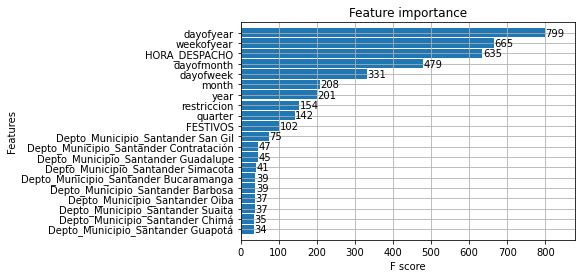

In [39]:
# 3. Evaluate the model

# Feature importance
%matplotlib inline
xgb.plot_importance(model_socorro, ax=plt.gca(),max_num_features=20, height = 0.9)

# Metrics
predtrain_socorro = model_socorro.predict(x_train_socorro)
print('R2',r2_score(y_train_socorro,predtrain_socorro))
print('MSE',mean_squared_error(y_train_socorro,predtrain_socorro))
print('RMSE train',np.sqrt(mean_squared_error(y_train_socorro,predtrain_socorro)))

predtest_socorro=model_socorro.predict(x_test_socorro)
print('R2',r2_score(y_test_socorro,predtest_socorro))
print('MSE',mean_squared_error(y_test_socorro,predtest_socorro))
print('RMSE test',np.sqrt(mean_squared_error(y_test_socorro,predtest_socorro)))

In [40]:
# Export model for dash / plotly
file_name = "xgb_model_socorro2.pkl"

# save
pickle.dump(model_socorro, open(file_name, "wb"))

### T.T. DE VILLAVICENCIO

In [41]:
# 1. Data wrangling

# a. Select the terminal
t_vvcio=df[df['TERMINAL'] =='T.T. DE VILLAVICENCIO']

# b. Select the main features for the model
# Variables such as type of vehicle or type of service are not considered since they are a consequence of passenger demand

data_vvcio=t_vvcio.groupby(['FECHA_DESPACHO','HORA_DESPACHO','DEPARTAMENTO_DESTINO',
                                     'MUNICIPIO_DESTINO'])['PASAJEROS'].agg([np.sum]).reset_index()
data_vvcio = data_vvcio.rename(columns={'sum':'PASAJEROS'})

# c. Create new features
# Holidays
dias_festivos20_21 = ['2020-01-01', '2020-01-06', '2020-03-23', '2020-04-09', '2020-04-10', '2020-05-01', '2020-05-25',
                         '2020-06-15', '2020-06-29', '2020-07-20', '2020-08-07', '2020-08-17', '2020-10-12', '2020-11-02',
                         '2020-11-16', '2020-12-08', '2020-12-25', '2021-01-01', '2021-01-11', '2021-03-22', '2021-04-01', 
                         '2021-04-02', '2021-05-01', '2021-05-17', '2021-06-7', '2021-06-14', '2021-07-05', '2021-07-20',
                         '2021-08-07', '2021-08-16', '2021-10-18', '2021-11-01', '2021-11-15', '2021-12-08', '2021-12-25']
# Features date
data_vvcio['FESTIVOS'] =   data_vvcio['FECHA_DESPACHO'].isin(dias_festivos20_21)*1
data_vvcio['dayofweek'] =  data_vvcio['FECHA_DESPACHO'].dt.dayofweek
data_vvcio['quarter'] =    data_vvcio['FECHA_DESPACHO'].dt.quarter
data_vvcio['month'] =      data_vvcio['FECHA_DESPACHO'].dt.month
data_vvcio['year'] =       data_vvcio['FECHA_DESPACHO'].dt.year
data_vvcio['dayofyear'] =  data_vvcio['FECHA_DESPACHO'].dt.dayofyear
data_vvcio['dayofmonth'] = data_vvcio['FECHA_DESPACHO'].dt.day
data_vvcio['weekofyear'] = data_vvcio['FECHA_DESPACHO'].dt.weekofyear

# Mobility restrictions

data_vvcio["restriccion"] = np.where(data_vvcio['FECHA_DESPACHO']<='2020-03-26',3,
np.where((data_vvcio['FECHA_DESPACHO'] > '2020-03-26')&(data_vvcio['FECHA_DESPACHO'] <='2020-08-31'),0,
np.where((data_vvcio['FECHA_DESPACHO'] >='2020-09-01')&(data_vvcio['FECHA_DESPACHO'] <= '2021-02-28'),1,
np.where((data_vvcio['FECHA_DESPACHO'] >='2021-03-01')&(data_vvcio['FECHA_DESPACHO'] <= '2021-11-30'),2,
3))))

# Travel destination

data_vvcio["Depto_Municipio"]=data_vvcio['DEPARTAMENTO_DESTINO']+' '+data_vvcio['MUNICIPIO_DESTINO']

<ipython-input-41-b226c626ae8a>:28: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data_vvcio['weekofyear'] = data_vvcio['FECHA_DESPACHO'].dt.weekofyear


In [42]:
# 2. Model

# Split data in features and target values
x_vvcio=data_vvcio.drop(['PASAJEROS','FECHA_DESPACHO','DEPARTAMENTO_DESTINO','MUNICIPIO_DESTINO'], axis=1)
y_vvcio=data_vvcio['PASAJEROS']

# Encoding categorical data
x_vvcio_encoded=pd.get_dummies(x_vvcio, columns=["Depto_Municipio"])

# Data training and data test
x_train_vvcio, x_test_vvcio, y_train_vvcio, y_test_vvcio = train_test_split(x_vvcio_encoded,y_vvcio,test_size=0.3,random_state=42)

# create model XGBoost Regressor
model_vvcio = XGBRegressor(objective ='reg:squarederror', seed = 123)

# create random search model and fit training and test data
random_search = RandomizedSearchCV(model_vvcio, param_distributions=params, n_iter=5, scoring='r2', n_jobs=-1, cv=5, 
                                   verbose=3)
random_search.fit(x_train_vvcio, y_train_vvcio)

# Obtain best estimator to tuned model XGBoost Regressor
random_search.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0.2, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.25, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [43]:
# Run model with best parameters given ni Randomized Search
model_vvcio = random_search.best_estimator_
model_vvcio.fit(x_train_vvcio, y_train_vvcio)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0.2, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.25, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

R2 0.4621211273793093
MSE 1228.344705173219
RMSE train 35.0477489316107
R2 0.35850036340318825
MSE 1793.1016155792845
RMSE test 42.34503058895205


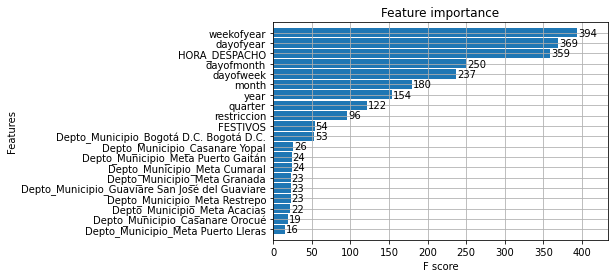

In [44]:
# 3. Evaluate the model

# Feature importance
%matplotlib inline
xgb.plot_importance(model_vvcio, ax=plt.gca(),max_num_features=20, height = 0.9)

# Metrics
predtrain_vvcio = model_vvcio.predict(x_train_vvcio)
print('R2',r2_score(y_train_vvcio,predtrain_vvcio))
print('MSE',mean_squared_error(y_train_vvcio,predtrain_vvcio))
print('RMSE train',np.sqrt(mean_squared_error(y_train_vvcio,predtrain_vvcio)))

predtest_vvcio=model_vvcio.predict(x_test_vvcio)
print('R2',r2_score(y_test_vvcio,predtest_vvcio))
print('MSE',mean_squared_error(y_test_vvcio,predtest_vvcio))
print('RMSE test',np.sqrt(mean_squared_error(y_test_vvcio,predtest_vvcio)))

In [45]:
# Export model for dash / plotly
file_name = "xgb_model_vvcio2.pkl"

# save
pickle.dump(model_vvcio, open(file_name, "wb"))